### Import the necesarry librabies

In [1]:
#!pip install pandas
#!pip install gdown
#!pip install openpyxl
!pip install langdetect googletrans==4.0.0-rc1
!pip install bertopic
!pip install --upgrade httpx
!pip install gensim
!pip install pyLDAvis

  Using cached httpx-0.13.3-py3-none-any.whl.metadata (25 kB)
  Using cached httpcore-0.9.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached h11-0.9.0-py2.py3-none-any.whl.metadata (8.1 kB)
Using cached httpx-0.13.3-py3-none-any.whl (55 kB)
Using cached httpcore-0.9.1-py3-none-any.whl (42 kB)
Using cached h11-0.9.0-py2.py3-none-any.whl (53 kB)
  Attempting uninstall: h11
    Found existing installation: h11 0.16.0
    Uninstalling h11-0.16.0:
      Successfully uninstalled h11-0.16.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.9
    Uninstalling httpcore-1.0.9:
      Successfully uninstalled httpcore-1.0.9
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
firebase-admin 6.9.0 req

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import re
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
from transformers import pipeline
from bertopic import BERTopic

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Load the dataset

# Load Excel files
google_df = pd.read_excel("Google_12_months.xlsx", engine='openpyxl')
trustpilot_df = pd.read_excel("Trustpilot_12_months.xlsx", engine='openpyxl')

Downloading...
From: https://drive.google.com/uc?id=13TeZTT6oqk3iPELBhFx9hComIfChKw4m
To: /content/Google_12_months.xlsx
100%|██████████| 2.08M/2.08M [00:00<00:00, 77.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V6Pr6xWrHSHaothB61MJbR7mPFHwQ1u6
To: /content/Trustpilot_12_months.xlsx
100%|██████████| 2.83M/2.83M [00:00<00:00, 175MB/s]


In [4]:
# View the Google DataFrame
print(google_df.shape)
google_df.head()

(23250, 7)


Customer Name SurveyID for external use (e.g. tech support)  \
0            **                      ekkt2vyxtkwrrrfyzc5hz6rk   
1            **                      e9b62vyxtkwrrrfyzc5hz6rk   
2            **                      e2dkxvyxtkwrrrfyzc5hz6rk   
3            **                      e3tfxvyxtkwrrrfyzc5hz6rk   
4            **                      edkrxvyxtkwrrrfyzc5hz6rk   

                         Club's Name Social Media Source       Creation Date  \
0            Leeds City Centre North      Google Reviews 2024-05-09 23:49:18   
1             Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
2                     London Holborn      Google Reviews 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park      Google Reviews 2024-05-09 21:58:07   
4                 Bristol Union Gate      Google Reviews 2024-05-09 21:48:00   

                                             Comment  Overall Score  
0                                                NaN              4  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1

In [5]:
# View the Trustpilot Datafarme
print(trustpilot_df.shape)
trustpilot_df.head()

(16673, 15)


Review ID Review Created (UTC)   Review Consumer User ID  \
0  663d40378de0a14c26c2f63c  2024-05-09 23:29:00  663d4036d5fa24c223106005   
1  663d3c101ccfcc36fb28eb8c  2024-05-09 23:11:00  5f5e3434d53200fa6ac57238   
2  663d375859621080d08e6198  2024-05-09 22:51:00  57171ba90000ff000a18f905   
3  663d4fa1f25670a3339ccf6d  2024-05-09 22:35:00  663d4fa0d5fa24251d1068e7   
4  663d3251d8367b7b3c4ace64  2024-05-09 22:30:00  60c20598384d84001a4250de   

                    Review Title  \
0        A very good environment   
1  I love to be part of this gym   
2                 Extremely busy   
3                    Great vibes   
4      Everything it needs to be   

                                      Review Content  Review Stars  \
0                            A very good environment             5   
1  I love to be part of this gym. Superb value fo...             5   
2                      Extremely busy, no fresh air.             1   
3                         Great vibes, fantastic gym             5   
4             Clean, well managed, classes are good.             5   

  Source Of Review Review Language              Domain URL Webshop Name  \
0            AFSv2              en  http://www.puregym.com   PureGym UK   
1            AFSv2              en  http://www.puregym.com   PureGym UK   
2            AFSv2              en  http://www.puregym.com   PureGym UK   
3            AFSv2              en  http://www.puregym.com   PureGym UK   
4            AFSv2              en  http://www.puregym.com   PureGym UK   

           Business Unit ID  Tags Company Reply Date (UTC)  \
0  508df4ea00006400051dd7b1   NaN      2024-05-10 08:12:00   
1  508df4ea00006400051dd7b1   NaN      2024-05-10 08:13:00   
2  508df4ea00006400051dd7b1   NaN                      NaT   
3  508df4ea00006400051dd7b1   NaN                      NaT   
4  508df4ea00006400051dd7b1   NaN      2024-05-10 08:14:00   

                Location Name                           Location ID  
0  Solihull Sears Retail Park  7b03ccad-4a9d-4a33-9377-ea5bba442dfc  
1                   Aylesbury  612d3f7e-18f9-492b-a36f-4a7b86fa5647  
2         Sutton Times Square  0b78c808-f671-482b-8687-83468b7b5bc1  
3             London Finchley  bc3a9a8c-defe-47b3-8ee6-f73a03b7447e  
4                    Crayford  9ce470b7-57df-4533-af2f-c539422fed14

In [6]:
google_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23250 entries, 0 to 23249
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Customer Name                                  23250 non-null  object        
 1   SurveyID for external use (e.g. tech support)  23250 non-null  object        
 2   Club's Name                                    23250 non-null  object        
 3   Social Media Source                            23250 non-null  object        
 4   Creation Date                                  23250 non-null  datetime64[ns]
 5   Comment                                        13898 non-null  object        
 6   Overall Score                                  23250 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.2+ MB


In [7]:
trustpilot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16673 entries, 0 to 16672
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Review ID                 16673 non-null  object        
 1   Review Created (UTC)      16673 non-null  datetime64[ns]
 2   Review Consumer User ID   16673 non-null  object        
 3   Review Title              16673 non-null  object        
 4   Review Content            16673 non-null  object        
 5   Review Stars              16673 non-null  int64         
 6   Source Of Review          16673 non-null  object        
 7   Review Language           16673 non-null  object        
 8   Domain URL                16673 non-null  object        
 9   Webshop Name              16673 non-null  object        
 10  Business Unit ID          16673 non-null  object        
 11  Tags                      0 non-null      float64       
 12  Company Reply Date

#####  Remove any rows with missing values in the Comment column (Google review) and Review Content column (Trustpilot).

In [8]:
# Remove rows with missing values in the Comment for both DataFrame.
google_df = google_df.dropna(subset=['Comment'])
trustpilot_df = trustpilot_df.dropna(subset=['Review Content'])

print(google_df.shape)
print(trustpilot_df.shape)

(13898, 7)
(16673, 15)


The Trustpilot dataframe had no missing values in the Comment column.
In contrast, over 40% of the rows in the Google dataframe had missing values in the Review Content column.

# Data Investigation

#### Data Cleaning

##### Remove rows with non english reviews in both datasets

In [9]:
from langdetect import detect, DetectorFactory,LangDetectException
DetectorFactory.seed = 0  # For consistent results

def count_non_english_comments(df, column):
    non_english_count = 0
    total_valid_count = 0

    for text in df[column].dropna():
        try:
            if detect(text) != 'en':
                non_english_count += 1
            total_valid_count += 1
        except:
            # Handle texts that can't be detected - skip but don't count towards total
            continue

    # Calculate percentage
    percentage = (non_english_count / total_valid_count * 100) if total_valid_count > 0 else 0

    return non_english_count, total_valid_count, percentage

# Analyze both datasets
google_non_english, google_total, google_percentage = count_non_english_comments(google_df, 'Comment')
trustpilot_non_english, trustpilot_total, trustpilot_percentage = count_non_english_comments(trustpilot_df, 'Review Content')

print("=== Language Analysis Results ===")
print(f"Google dataset:")
print(f"  Non-English comments: {google_non_english:,} out of {google_total:,} ({google_percentage:.2f}%)")
print(f"  English comments: {google_total - google_non_english:,} ({100 - google_percentage:.2f}%)")

print(f"\nTrustpilot dataset:")
print(f"  Non-English reviews: {trustpilot_non_english:,} out of {trustpilot_total:,} ({trustpilot_percentage:.2f}%)")
print(f"  English reviews: {trustpilot_total - trustpilot_non_english:,} ({100 - trustpilot_percentage:.2f}%)")

=== Language Analysis Results ===
Google dataset:
  Non-English comments: 1,976 out of 13,855 (14.26%)
  English comments: 11,879 (85.74%)

Trustpilot dataset:
  Non-English reviews: 844 out of 16,657 (5.07%)
  English reviews: 15,813 (94.93%)


In [10]:
def is_english(text):
    """Safely check if text is English with comprehensive error handling"""
    text = str(text).strip()
    if len(text) < 3:  # Too short for reliable detection
        return False

    try:
        return detect(text) == 'en'
    except (LangDetectException, Exception):
        return False

# Filter the dataframe
google_df = google_df[google_df['Comment'].notna() &
                     (google_df['Comment'].astype(str).str.strip().str.len() > 0)]

google_df = google_df[google_df['Comment'].apply(is_english)]

print(f"Filtered dataset shape: {google_df.shape}")
google_df.head()

Filtered dataset shape: (11879, 7)


Customer Name SurveyID for external use (e.g. tech support)  \
1            **                      e9b62vyxtkwrrrfyzc5hz6rk   
2            **                      e2dkxvyxtkwrrrfyzc5hz6rk   
3            **                      e3tfxvyxtkwrrrfyzc5hz6rk   
4            **                      edkrxvyxtkwrrrfyzc5hz6rk   
7            **                      erx6f88stkwrrrfyzc5hz6rk   

                         Club's Name Social Media Source       Creation Date  \
1             Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
2                     London Holborn      Google Reviews 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park      Google Reviews 2024-05-09 21:58:07   
4                 Bristol Union Gate      Google Reviews 2024-05-09 21:48:00   
7                         New Barnet      Google Reviews 2024-05-09 20:16:04   

                                             Comment  Overall Score  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1  
7  This gym is way too hot to even workout in. Th...              2

In [11]:
# Filter and apply the english function to the trustpilot dataframe
trustpilot_df = trustpilot_df[trustpilot_df['Review Content'].notna() &
                     (trustpilot_df['Review Content'].astype(str).str.strip().str.len() > 0)]

trustpilot_df = trustpilot_df[trustpilot_df['Review Content'].apply(is_english)]

print(f"Filtered dataset shape: {trustpilot_df.shape}")
trustpilot_df.head()

Filtered dataset shape: (15813, 15)


Review ID Review Created (UTC)   Review Consumer User ID  \
1  663d3c101ccfcc36fb28eb8c  2024-05-09 23:11:00  5f5e3434d53200fa6ac57238   
2  663d375859621080d08e6198  2024-05-09 22:51:00  57171ba90000ff000a18f905   
3  663d4fa1f25670a3339ccf6d  2024-05-09 22:35:00  663d4fa0d5fa24251d1068e7   
4  663d3251d8367b7b3c4ace64  2024-05-09 22:30:00  60c20598384d84001a4250de   
5  663d2f33a15443210984c7a2  2024-05-09 22:16:00  4e85872700006400010c9f80   

                    Review Title  \
1  I love to be part of this gym   
2                 Extremely busy   
3                    Great vibes   
4      Everything it needs to be   
5                Good budget gym   

                                      Review Content  Review Stars  \
1  I love to be part of this gym. Superb value fo...             5   
2                      Extremely busy, no fresh air.             1   
3                         Great vibes, fantastic gym             5   
4             Clean, well managed, classes are good.             5   
5  Good budget gym. Open 24/7. Young, keen and fr...             4   

  Source Of Review Review Language              Domain URL Webshop Name  \
1            AFSv2              en  http://www.puregym.com   PureGym UK   
2            AFSv2              en  http://www.puregym.com   PureGym UK   
3            AFSv2              en  http://www.puregym.com   PureGym UK   
4            AFSv2              en  http://www.puregym.com   PureGym UK   
5        BasicLink              en  http://www.puregym.com   PureGym UK   

           Business Unit ID  Tags Company Reply Date (UTC)  \
1  508df4ea00006400051dd7b1   NaN      2024-05-10 08:13:00   
2  508df4ea00006400051dd7b1   NaN                      NaT   
3  508df4ea00006400051dd7b1   NaN                      NaT   
4  508df4ea00006400051dd7b1   NaN      2024-05-10 08:14:00   
5  508df4ea00006400051dd7b1   NaN                      NaT   

         Location Name                           Location ID  
1            Aylesbury  612d3f7e-18f9-492b-a36f-4a7b86fa5647  
2  Sutton Times Square  0b78c808-f671-482b-8687-83468b7b5bc1  
3      London Finchley  bc3a9a8c-defe-47b3-8ee6-f73a03b7447e  
4             Crayford  9ce470b7-57df-4533-af2f-c539422fed14  
5             Stirling  0630ec1a-c4b4-443e-b4b5-8def9d41f9ad

**we will also drop unuseful columns inboth dataframes**

In [12]:
# Drop Identifier columns in both Google Dataset
google_df = google_df.drop(columns=['Customer Name', 'SurveyID for external use (e.g. tech support)', 'Social Media Source'])
print(google_df.shape)
google_df.head()

(11879, 4)


Club's Name       Creation Date  \
1             Cambridge Leisure Park 2024-05-09 22:48:39   
2                     London Holborn 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park 2024-05-09 21:58:07   
4                 Bristol Union Gate 2024-05-09 21:48:00   
7                         New Barnet 2024-05-09 20:16:04   

                                             Comment  Overall Score  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1  
7  This gym is way too hot to even workout in. Th...              2

The 'Customer Name' and 'SurveyID for external use (e.g. tech support)' columns were dropped because they are identifier columns that do not contribute to the analysis.


The 'Social Media Source' column was also removed since it was redundant—all the data came from Google Reviews.

In [13]:
# Drop Identifier columns in both Trustpilot Dataset
trustpilot_df = trustpilot_df.drop(columns=['Review ID', 'Review Consumer User ID', 'Source Of Review',
                                            'Domain URL', 'Webshop Name', 'Business Unit ID',
                                            'Tags', 'Location ID'])
print(trustpilot_df.shape)
trustpilot_df.head()

(15813, 7)


Review Created (UTC)                   Review Title  \
1  2024-05-09 23:11:00  I love to be part of this gym   
2  2024-05-09 22:51:00                 Extremely busy   
3  2024-05-09 22:35:00                    Great vibes   
4  2024-05-09 22:30:00      Everything it needs to be   
5  2024-05-09 22:16:00                Good budget gym   

                                      Review Content  Review Stars  \
1  I love to be part of this gym. Superb value fo...             5   
2                      Extremely busy, no fresh air.             1   
3                         Great vibes, fantastic gym             5   
4             Clean, well managed, classes are good.             5   
5  Good budget gym. Open 24/7. Young, keen and fr...             4   

  Review Language Company Reply Date (UTC)        Location Name  
1              en      2024-05-10 08:13:00            Aylesbury  
2              en                      NaT  Sutton Times Square  
3              en                      NaT      London Finchley  
4              en      2024-05-10 08:14:00             Crayford  
5              en                      NaT             Stirling

'Review ID', 'Review Consumer User ID', 'Business Unit ID', &  'Location ID' are dropped because they are identifiers and don’t add analytical value.

'Source Of Review', 'Domain URL', 'Webshop Name' &  'Review Language' have redundant or static values  which don't vary or provide insights.

The Tags column is entirely null, offering no usable data.

#### **Initial data investigation**

Find the number of unique locations in the Google data set & Trustpilot data set.

In [14]:
# Find unique locations in the google dataset
unique_locations_google = google_df["Club's Name"].nunique()
print("Number of unique locations in the Google data set:", unique_locations_google)

# Find unique locations in the Trustpilot dataset
unique_locations_trustpilot = trustpilot_df["Location Name"].nunique()
print("Number of unique locations in the Trustpilot data set:", unique_locations_trustpilot)

Number of unique locations in the Google data set: 455
Number of unique locations in the Trustpilot data set: 376


##### Find the number of common locations between the Google data set and the Trustpilot data set.

In [15]:
# Find the number of common locations between the Google data set and the Trustpilot data set.
common_locations = set(google_df["Club's Name"]).intersection(set(trustpilot_df["Location Name"]))
print("Number of common locations:", len(common_locations))
common_locations

Number of common locations: 310


{'Aberdeen Kittybrewster',
 'Aberdeen Rubislaw',
 'Aberdeen Shiprow',
 'Aintree',
 'Alloa',
 'Altrincham',
 'Andover',
 'Aylesbury',
 'Bangor Northern Ireland',
 'Bangor Wales',
 'Barnstaple',
 'Basildon',
 'Bath Spring Wharf',
 'Bath Victoria Park',
 'Bedford Heights',
 'Belfast Adelaide Street',
 'Belfast Boucher Road',
 "Belfast St Anne's Square",
 'Bicester',
 'Billericay',
 'Birmingham Arcadian Centre',
 'Birmingham Beaufort Park',
 'Birmingham City Centre',
 'Birmingham Longbridge',
 'Birmingham Maypole',
 'Birmingham West',
 'Blackburn The Mall',
 'Bletchley',
 'Blyth',
 'Boston',
 'Bracknell',
 'Bradford Idle',
 'Bradford Thornbury',
 'Bridgwater',
 'Brierley Hill',
 'Brighton Central',
 'Brighton London Road',
 'Bristol Abbey Wood Retail Park',
 'Bristol Brislington',
 'Bristol Eastgate',
 'Bristol Harbourside',
 'Bristol Union Gate',
 'Bromborough',
 'Bromsgrove Retail Park',
 'Buckingham',
 'Burgess Hill',
 'Burnham',
 'Bury',
 'Byfleet',
 'Caerphilly',
 'Camberley',
 'Cambr

Number of common locations between both DataSets are: 310

#### ***Proceeding with the data processing we will filter out reviews locations that are not common to both data set***

In [16]:
# Proceeding with the data processing we will filter out reviews locations that are not common to both data set
google_df = google_df[google_df["Club's Name"].isin(common_locations)]
trustpilot_df = trustpilot_df[trustpilot_df["Location Name"].isin(common_locations)]

In [17]:
print(google_df.shape)
print(trustpilot_df.shape)

(9777, 4)
(8823, 7)


#### **Data Preprocessing**

To preprocess the text data, we will:

* Convert all text to lowercase
* Remove stopwords using NLTK
* Remove numbers from the text
* Tokenise the data using

In [18]:
# Create a function to preprocess all text in the comment column of both dataset
def clean_text(text):
    # Check if the input is a string, otherwise return empty list
    #if not isinstance(text, str):
     #   return []

    # Convert to lowercase
    text = text.lower()

    # Remove specific words/phrases before tokenization
    text = re.sub(r'\bpure\b', ' ', text)  # Remove "pure"
    text = re.sub(r'\bpuregym\b', ' ', text)   # Remove "puregym"
    text = re.sub(r'\bgym\b', ' ', text)       # Remove "gym"

    # Remove non-alphabetic characters (keeps spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Tokenize text
    cleaned_text = word_tokenize(text)

    # Remove stopwords and numbers
    stop_words = set(stopwords.words('english'))
    cleaned_text = [word for word in cleaned_text if word not in stop_words and not word.isnumeric() and len(word) > 2]

    return cleaned_text

In [19]:
# Apply the modified clean_text function to each row of the 'Comment' and 'Review Content' columns
google_df['google_tokens'] = google_df['Comment'].apply(clean_text)
trustpilot_df['trustpilot_tokens'] = trustpilot_df['Review Content'].apply(clean_text)

In [20]:
print(google_df.shape)
google_df.head()

(9777, 5)


Club's Name       Creation Date  \
1             Cambridge Leisure Park 2024-05-09 22:48:39   
2                     London Holborn 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park 2024-05-09 21:58:07   
4                 Bristol Union Gate 2024-05-09 21:48:00   
7                         New Barnet 2024-05-09 20:16:04   

                                             Comment  Overall Score  \
1  Too many students from two local colleges go h...              1   
2  Best range of equipment, cheaper than regular ...              5   
3  Good gym when it’s not busy, tend to get too b...              4   
4  (current member)\n\nGym is quite dirty, more o...              1   
7  This gym is way too hot to even workout in. Th...              2   

                                       google_tokens  
1  [many, students, two, local, colleges, leave, ...  
2  [best, range, equipment, cheaper, regular, gym...  
3  [good, busy, tend, get, busy, late, afternoon,...  
4  [current, member, quite, dirty, often, soap, b...  
7  [way, hot, even, workout, windows, open, barel...

In [21]:
print(trustpilot_df.shape)
trustpilot_df.head()

(8823, 8)


Review Created (UTC)                              Review Title  \
1  2024-05-09 23:11:00             I love to be part of this gym   
2  2024-05-09 22:51:00                            Extremely busy   
3  2024-05-09 22:35:00                               Great vibes   
7  2024-05-09 21:52:00  Great gym felt very comfortable enjoyed…   
9  2024-05-09 21:29:00                                      Fun!   

                                      Review Content  Review Stars  \
1  I love to be part of this gym. Superb value fo...             5   
2                      Extremely busy, no fresh air.             1   
3                         Great vibes, fantastic gym             5   
7  Great gym felt very comfortable enjoyed my ses...             5   
9                           Fun, worth the work out.             4   

  Review Language Company Reply Date (UTC)        Location Name  \
1              en      2024-05-10 08:13:00            Aylesbury   
2              en                      NaT  Sutton Times Square   
3              en                      NaT      London Finchley   
7              en      2024-05-10 08:19:00           Barnstaple   
9              en                      NaT       London Aldgate   

                                   trustpilot_tokens  
1  [love, part, superb, value, money, time, day, ...  
2                      [extremely, busy, fresh, air]  
3                          [great, vibes, fantastic]  
7      [great, felt, comfortable, enjoyed, sessions]  
9                                 [fun, worth, work]

##### **Visualize the most frequent words from both datasets using bar charts and word clouds**

In [22]:
def display_wordcloud(tokens, title):
    # Generate word frequency
    freq_dist = nltk.FreqDist(tokens)
    df_freq = pd.DataFrame(freq_dist.most_common(100), columns=['Word', 'Frequency'])

    # Set up a figure with 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Word Frequency and Cloud - {title}', fontsize=16)

    # Bar plot for top 10 words
    sns.barplot(x='Frequency', y='Word', data=df_freq.head(10), ax=axs[0], palette='Blues_d')
    axs[0].set_title('Top 10 Frequent Words')
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('Word')

    # Create word cloud from the same frequency distribution
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,  # Limit to top 200 words
        max_font_size=60,
        colormap='viridis'
    ).generate_from_frequencies(freq_dist)

    axs[1].imshow(wordcloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Word Cloud')

    plt.tight_layout()
    plt.show()

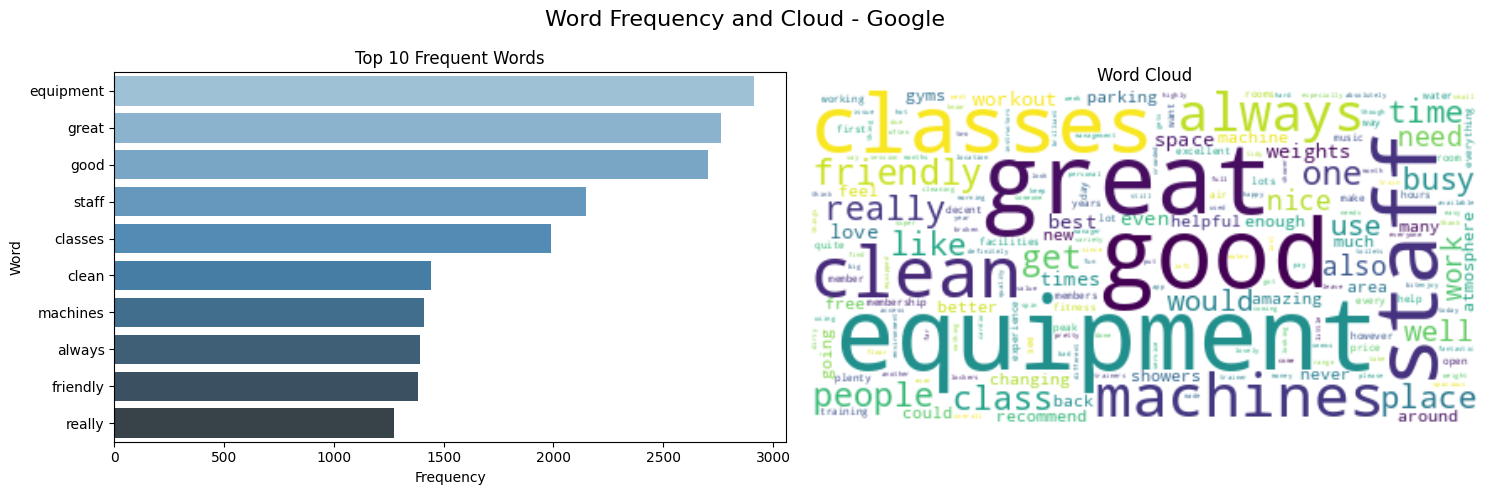

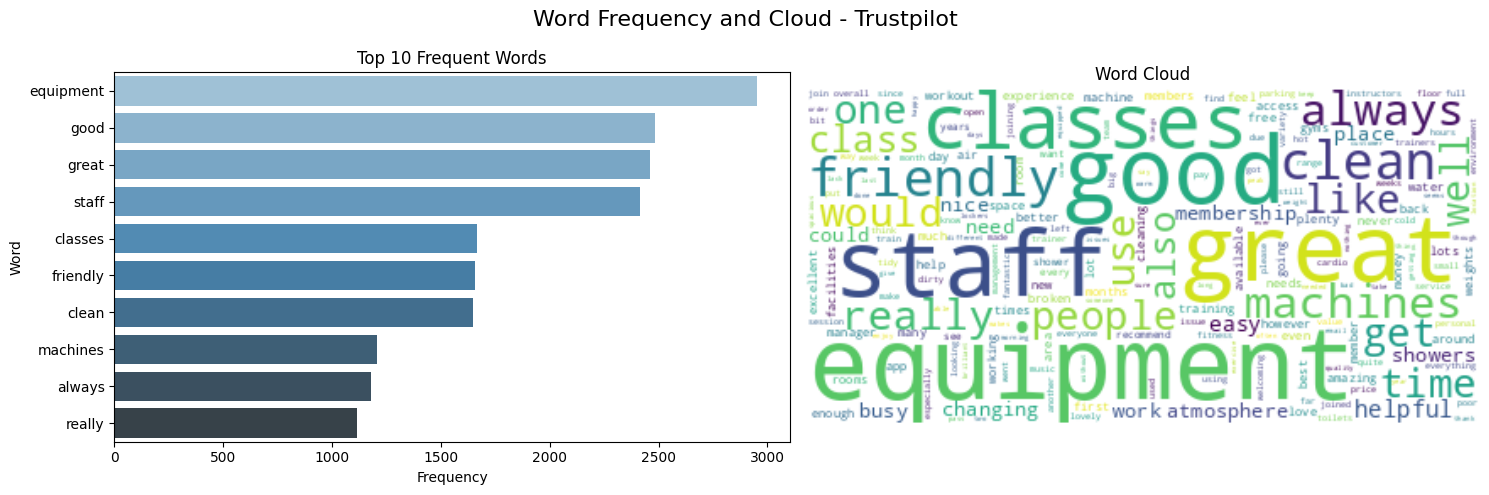

In [23]:
# Apply the display_wordcloud` function to both datasets after flattening their token columns into single lists of words.
# Flatten the list of token lists into a single list
google_tokens_flat = [word for tokens in google_df['google_tokens'] for word in tokens]
trustpilot_tokens_flat = [word for tokens in trustpilot_df['trustpilot_tokens'] for word in tokens]

# Apply the function
display_wordcloud(google_tokens_flat, 'Google')
display_wordcloud(trustpilot_tokens_flat, 'Trustpilot')


Both the Google Reviews and Trustpilot charts show strong positive sentiment, with shared keywords like equipment, great, good, staff, clean, friendly, and classes reflecting high approval of facilities, staff, and cleanliness across both platforms. Google Reviews leans toward consistent satisfaction with words like always and really, while Trustpilot adds easy, hinting at user-friendly experiences such as booking or using machines. The presence of classes on both lists shows appreciation for structured offerings, and the overlap in keywords suggests a cohesive brand reputation across channels.

##### **Identify negative reviews in both dataset**

In [24]:
# Create a new dataframe by filtering out the data to extract only the negative reviews from both data sets.
# Using reviews that have less than 3 overall scores or stars
google_df_negative = google_df[google_df['Overall Score'] < 3]
trustpilot_df_negative = trustpilot_df[trustpilot_df['Review Stars'] < 3]
print(google_df_negative.shape)
print(trustpilot_df_negative.shape)

(2036, 5)
(1814, 8)


In [25]:
google_df_negative.head()

Club's Name       Creation Date  \
1     Cambridge Leisure Park 2024-05-09 22:48:39   
4         Bristol Union Gate 2024-05-09 21:48:00   
7                 New Barnet 2024-05-09 20:16:04   
19  Manchester Cheetham Hill 2024-05-09 17:03:50   
29    Newcastle Eldon Garden 2024-05-09 08:38:07   

                                              Comment  Overall Score  \
1   Too many students from two local colleges go h...              1   
4   (current member)\n\nGym is quite dirty, more o...              1   
7   This gym is way too hot to even workout in. Th...              2   
19  No access for wc 😢.  Empty and no assistance t...              2   
29  After being at this gym for over a year I'm fi...              2   

                                        google_tokens  
1   [many, students, two, local, colleges, leave, ...  
4   [current, member, quite, dirty, often, soap, b...  
7   [way, hot, even, workout, windows, open, barel...  
19  [access, empty, assistance, gain, access, faul...  
29  [year, finally, leaving, gutted, staff, pts, l...

In [26]:
trustpilot_df_negative.head()

Review Created (UTC)                              Review Title  \
2   2024-05-09 22:51:00                            Extremely busy   
19  2024-05-09 18:09:00        The men’s changing rooms smell bad   
48  2024-05-09 09:16:00  No one was cleaning the equipment after…   
51  2024-05-09 08:03:00      Not the best experience at 7am on a…   
69  2024-05-08 18:16:00       Staff are great but not the company   

                                       Review Content  Review Stars  \
2                       Extremely busy, no fresh air.             1   
19  The men’s changing rooms smell bad. They need ...             2   
48  No one was cleaning the equipment after use. C...             1   
51  Not the best experience at 7am on a week day. ...             1   
69  Staff have their hands tied but surely head of...             1   

   Review Language Company Reply Date (UTC)            Location Name  \
2               en                      NaT      Sutton Times Square   
19              en                      NaT  Leeds City Centre South   
48              en                      NaT              Dunfermline   
51              en                      NaT      Bristol Harbourside   
69              en                      NaT               Sunderland   

                                    trustpilot_tokens  
2                       [extremely, busy, fresh, air]  
19  [men, changing, rooms, smell, bad, need, deep,...  
48  [one, cleaning, equipment, use, cleaning, stat...  
51  [best, experience, week, day, bought, day, pas...  
69  [staff, hands, tied, surely, head, office, cou...

##### **Visualize the most frequent words in negative reviews for both datasets using bar charts and word clouds**


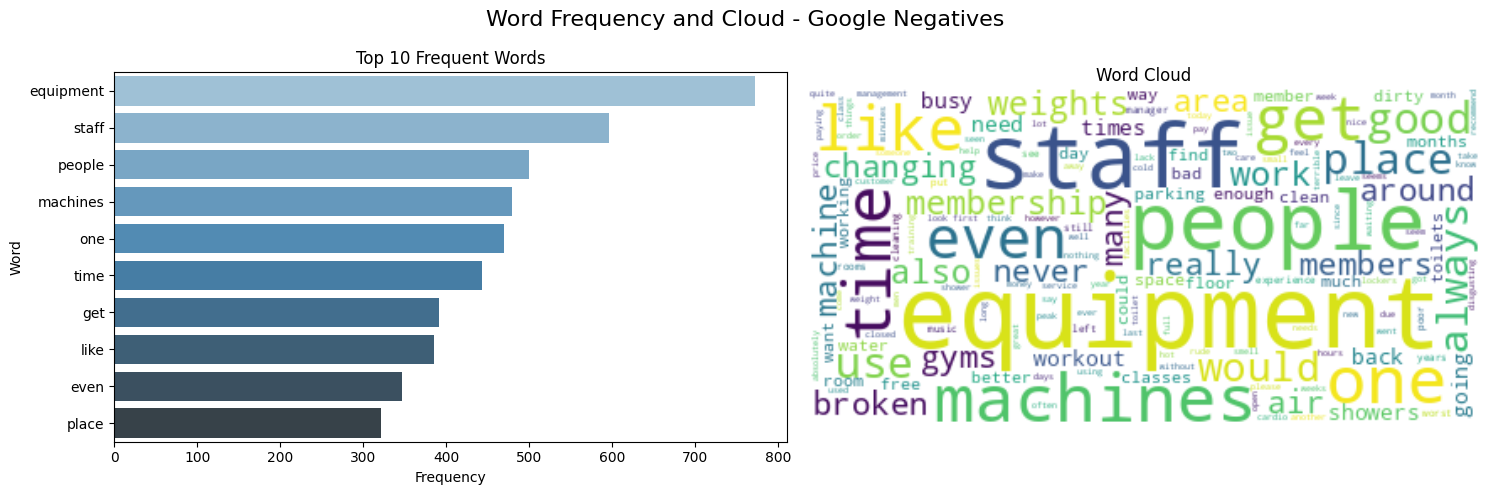

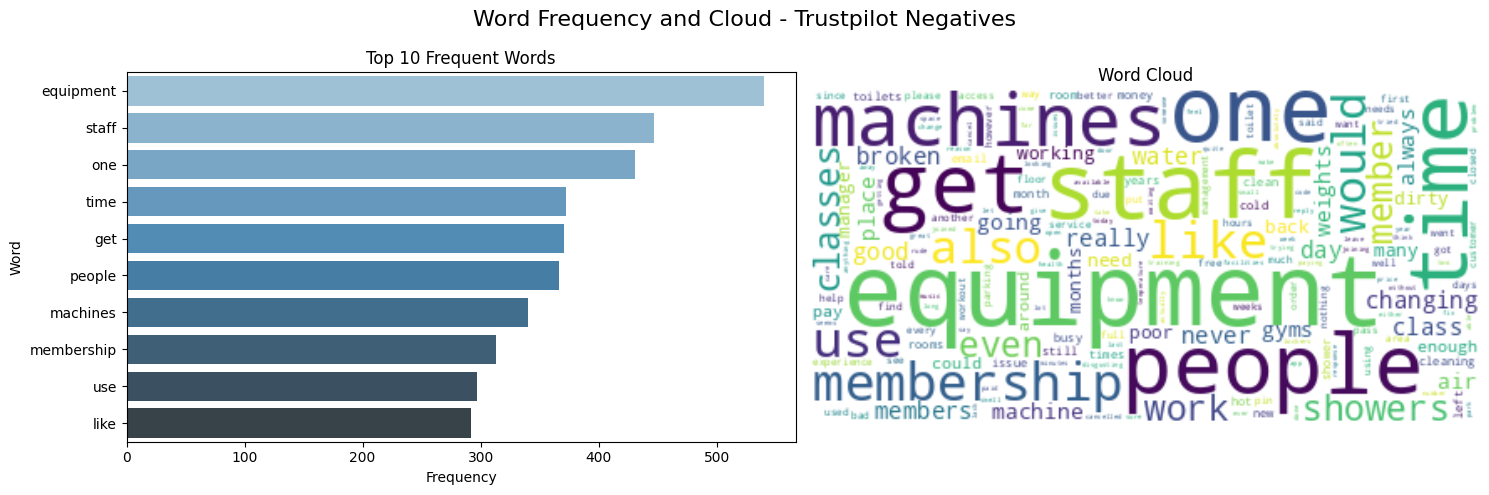

In [27]:
# Visualize the most frequent words for the negative reviews.

# Flatten the list of token lists into a single list
google_neg_flat = [word for tokens in google_df_negative['google_tokens'] for word in tokens]
trustpilot_neg_flat = [word for tokens in trustpilot_df_negative['trustpilot_tokens'] for word in tokens]

# Apply the function
display_wordcloud(google_neg_flat, 'Google Negatives')
display_wordcloud(trustpilot_neg_flat, 'Trustpilot Negatives')

Both Google and Trustpilot negative reviews point to concerns with equipment, staff, and specific incidents that shape customer dissatisfaction. Frequent mentions of equipment, staff, and machines on both platforms suggest issues with maintenance and service, while words like one, time, and get hint at bad experiences with broken machines or unhelpful staff. The appearance of people and place may reflect complaints about crowding or the environment, Trustpilot’s mention of membership indicates frustrations with billing or access. All the above higlighting areas that could be improve upon.

In [29]:
google_df_negative.to_csv('google_df_negative.csv', index=False)
trustpilot_df_negative.to_csv('trustpilot_df_negative.csv', index=False)

In [31]:
from google.colab import files
#files.download('google_df_negative.csv')
files.download('trustpilot_df_negative.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Initial Topic Modelling (Negative Reviews - Common location)

In [ ]:
# With the Negative reviews dataframe filter out the reviews that are from the locations common to both data sets
# Filter both datasets
google_filtered = google_df_negative[google_df_negative["Club's Name"].isin(common_locations)]
trustpilot_filtered = trustpilot_df_negative[trustpilot_df_negative["Location Name"].isin(common_locations)]

# Extract review text from both dataset
google_reviews = google_filtered['Comment'].astype(str).tolist()
trustpilot_reviews = trustpilot_filtered['Review Content'].astype(str).tolist()

# Merge both review lists
all_reviews = google_reviews + trustpilot_reviews


In [ ]:
# clean the reviews for BRETtopic
all_reviews_clean = []
for review in all_reviews:
  #print(review)
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    all_reviews_clean.append(review)

In [ ]:
print(all_reviews_clean[0])

too many students two local colleges go leave rubbish changing rooms sit like canteen going years cancel membership go gym group gym disgusting students hanging around machines messing around like school crowded ceo supports genocide civilians israel disgusting people 


##### Preprocess review list using BERTopic

In [ ]:
# Pass our cleaned reviws through BERTtopic
topic_model = BERTopic(verbose=True)
topic_model.fit(all_reviews_clean)
topics, probs = topic_model.fit_transform(all_reviews_clean)

2025-07-05 08:10:03,538 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

2025-07-05 08:10:09,264 - BERTopic - Embedding - Completed ✓
2025-07-05 08:10:09,266 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-05 08:10:29,576 - BERTopic - Dimensionality - Completed ✓
2025-07-05 08:10:29,577 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-05 08:10:29,712 - BERTopic - Cluster - Completed ✓
2025-07-05 08:10:29,717 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-05 08:10:29,866 - BERTopic - Representation - Completed ✓
2025-07-05 08:10:30,031 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

2025-07-05 08:10:32,212 - BERTopic - Embedding - Completed ✓
2025-07-05 08:10:32,213 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-05 08:10:53,215 - BERTopic - Dimensionality - Completed ✓
2025-07-05 08:10:53,216 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-05 08:10:53,351 - BERTopic - Cluster - Completed ✓
2025-07-05 08:10:53,355 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-05 08:10:53,506 - BERTopic - Representation - Completed ✓


In [ ]:
# List the top 10 topics from th BERTopic preprocessing with their document frequencies
topic_model.get_topic_freq().head(10)


Topic  Count
4      -1   1758
2       0    193
3       1    132
9       2    129
15      3    114
22      4     94
17      5     86
21      6     83
26      7     77
23      8     66

outlier topic (topic-1) had the highest number of complaints

In [ ]:
# View the list of top words in outlier topics
topic_model.get_topic(-1)

[('gym', np.float64(0.015918944272072817)),
 ('equipment', np.float64(0.011696529685959741)),
 ('staff', np.float64(0.010438133557254089)),
 ('people', np.float64(0.010077905118823505)),
 ('one', np.float64(0.009859954397356504)),
 ('machines', np.float64(0.009622681895766668)),
 ('get', np.float64(0.0086783904896358)),
 ('time', np.float64(0.008584056744106526)),
 ('use', np.float64(0.008165564869023806)),
 ('like', np.float64(0.008048822698662854))]

the outliers (topic -1) had the largest number count but will be ignored.

In [ ]:
# Get topic information as a DataFrame
topic_info = topic_model.get_topic_info()

print(topic_info)

    Topic  Count                                  Name  \
0      -1   1758         -1_gym_equipment_staff_people   
1       0    193         0_air_conditioning_hot_aircon   
2       1    132                   1_code_pass_pin_day   
3       2    129       2_toilets_toilet_changing_dirty   
4       3    114               3_parking_car_park_fine   
5       4     94               4_music_loud_noise_hear   
6       5     86          5_closed_open_christmas_days   
7       6     83        6_smell_smells_ventilation_air   
8       7     77        7_broken_machines_rowing_order   
9       8     66     8_cold_shower_showers_temperature   
10      9     57      9_class_classes_cancelled_booked   
11     10     51          10_showers_shower_sort_order   
12     11     51          11_water_yanga_machine_order   
13     12     48         12_lockers_locker_lock_stolen   
14     13     44       13_machines_machine_cable_chest   
15     14     44    14_membership_cancel_account_month   
16     15     

###### View top 2 topics and their list of top words

In [ ]:
# View first topic and their list of top words
topic_model.get_topic(0)

[('air', np.float64(0.06523497066186688)),
 ('conditioning', np.float64(0.03970601247864202)),
 ('hot', np.float64(0.03326901800567589)),
 ('aircon', np.float64(0.030822538691425393)),
 ('con', np.float64(0.027256826635327254)),
 ('ac', np.float64(0.024945420454300187)),
 ('summer', np.float64(0.024534157564336495)),
 ('heat', np.float64(0.021551155111849556)),
 ('temperature', np.float64(0.019802120222307165)),
 ('working', np.float64(0.01878951453728667))]

Topic 0 focuses on air conditioning, with key words like aircon, AC, hot, and summer, indicating negative about cooling systems and temperature comfort.The presence of working suggests some complaints about functionality of the Aircon

In [ ]:
# View second topic and their list of top words
topic_model.get_topic(1)

[('code', np.float64(0.08138979654953184)),
 ('pass', np.float64(0.08087154374789092)),
 ('pin', np.float64(0.07277816153983188)),
 ('day', np.float64(0.06702625027541743)),
 ('bought', np.float64(0.02976402865934256)),
 ('email', np.float64(0.02904508026672347)),
 ('paid', np.float64(0.028200100268732344)),
 ('get', np.float64(0.02702683598176124)),
 ('sent', np.float64(0.02599886772814117)),
 ('access', np.float64(0.025763141008571))]

This topic focuses on digital access systems, with keywords like code, pass, and pin pointing to complains about membership authentication, while email, sent, and access suggest dissatisfaction around how users receive and use digital credentials. The inclusion of day, bought, and paid hints at negative reviews related to temporary passes or transactional experiences, indicating this theme covers both functionality and user convenience in digital entry processes.

##### **Interactive Visualization of top Topics and Their Relationships Using Intertopic Distance Mapping, Bar Chat and heatmap**

In [ ]:
# Interactive Visualization of top Topics and Their Relationships Using Intertopic Distance Mapping
topic_model.visualize_topics()

In [ ]:
# Barchart of the topics displaying the top 5 words in each topic
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
# Heatmap showing the similarity matrix.
topic_model.visualize_heatmap()

In [ ]:
from collections import defaultdict
from umap import UMAP

# 5. Perform dimensionality reduction with UMAP
# Assuming `topic_model.embeddings_` contains the document embeddings used for topic modeling
# You might need to adjust this based on where your embeddings are stored in the BERTopic object
# If you used fit_transform, embeddings are generated internally. You might need to re-fit or access internal states.
# A common practice is to re-run UMAP on the topic embeddings if available, or document embeddings.
# Let's assume we need to re-run UMAP on the document embeddings for visualization purposes.
# If you need topic embeddings, you might need to access internal BERTopic components or re-calculate.

# Access document embeddings used by BERTopic (assuming they were stored or can be re-generated)
# If you used fit_transform, embeddings are often stored internally. A safer way might be to re-generate or use topic embeddings.
# Let's use topic embeddings for clustering visualization as it's more common for intertopic distance.
# BERTopic provides topic embeddings after fitting: topic_model.topic_embeddings_

# Check if topic embeddings exist
if hasattr(topic_model, 'topic_embeddings_'):
    topic_embeddings = topic_model.topic_embeddings_

    # Reduce dimensionality of topic embeddings
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    reduced_embeddings = umap_model.fit_transform(topic_embeddings)

    # BERTopic automatically handles the mapping from original topics to reduced topics/clusters internally
    # when visualizing. The `mappings` variable was likely intended for a manual clustering approach.
    # For BERTopic's built-in visualization, you just need the fitted model and the original documents.

    # BERTopic does not directly expose a simple `mappings` dictionary like intended.
    # The clustering and reduction are handled internally for visualizations.
    # The original code was trying to manually map after BERTopic's internal process.

    # To describe clusters, we can use the topic hierarchy or visual inspection of the map and barcharts.
    # We already have the topic information and can use the visualizations.

    print("BERTopic handles internal mapping for visualizations.")
    print("Instead of a 'mappings' variable, use BERTopic's visualization functions.")

    # 8. Print clusters, their topics, and top 5 words (using topic info directly)
    # The 'cluster_id' in the original code likely refers to the reduced dimensionality space,
    # but BERTopic's get_topic_info gives original topic IDs and their representations.
    print("\nTopic Descriptions (based on BERTopic's topic representation):")
    for index, row in topic_info.iterrows():
        topic_id = row['Topic']
        if topic_id == -1:
            continue  # skip outliers
        name = row['Name']
        representation = row['Representation']
        print(f"\nTopic {topic_id}: {name}")
        print(f"  Top words: {', '.join(representation[:10])}") # Print top 10 words from representation

else:
    print("Topic embeddings not found in the BERTopic model. Cannot perform dimensionality reduction for visualization.")
    print("Ensure BERTopic was fitted correctly.")

# Optional: Visualize hierarchy for an interactive map
# This visualization uses the internal topic structure
topic_model.visualize_hierarchy(topics=topic_info.Topic.tolist(), orientation='top') # Use the cleaned reviews list

BERTopic handles internal mapping for visualizations.
Instead of a 'mappings' variable, use BERTopic's visualization functions.

Topic Descriptions (based on BERTopic's topic representation):

Topic 0: 0_air_conditioning_hot_aircon
  Top words: air, conditioning, hot, aircon, con, ac, summer, heat, temperature, working

Topic 1: 1_code_pass_pin_day
  Top words: code, pass, pin, day, bought, email, paid, get, sent, access

Topic 2: 2_toilets_toilet_changing_dirty
  Top words: toilets, toilet, changing, dirty, rooms, always, smell, soap, cleaning, room

Topic 3: 3_parking_car_park_fine
  Top words: parking, car, park, fine, free, fines, reg, ticket, website, enter

Topic 4: 4_music_loud_noise_hear
  Top words: music, loud, noise, hear, classes, volume, headphones, class, play, instructor

Topic 5: 5_closed_open_christmas_days
  Top words: closed, open, christmas, days, opening, day, gym, email, closing, th

Topic 6: 6_smell_smells_ventilation_air
  Top words: smell, smells, ventilation, 

 **10 clusters**, their included topics, and their overarching themes based on the top words:  


### **Cluster 1: Shower/Temperature Issues**  
**Topics**: 10, 36, 0, 17, 8  
**Theme**: Complaints about **shower conditions** (cold, filthy, broken) and **air conditioning** (hot, malfunctioning).  
**Key Words**: *showers, cold, water, aircon, hot, temperature, freezing, dirty*.  

### **Cluster 2: Membership & Billing Problems**  
**Topics**: 14, 30  
**Theme**: Issues with **membership cancellations, fees, and discounts** (hidden charges, refunds).  
**Key Words**: *membership, cancel, fee, charged, discount, joining, paid*.  

### **Cluster 3: Equipment & Overcrowding**  
**Topics**: 41, 11, 7, 35, 22  
**Theme**: **Broken machines**, long wait times, and **overcrowding** during peak hours.  
**Key Words**: *machines, broken, wait, overcrowded, busy, equipment, order*.  

### **Cluster 4: Facility Cleanliness & Maintenance**  
**Topics**: 39, 29, 48  
**Theme**: Mixed feedback on **cleanliness standards** (spacious but dirty) and maintenance.  
**Key Words**: *cleanliness, toilets, dirty, spacious, showers, changing*.  

### **Cluster 5: Hygiene Complaints**  
**Topics**: 15, 6, 2, 37, 33  
**Theme**: Strong focus on **poor hygiene** (smells, dirty toilets, lack of cleaning supplies).  
**Key Words**: *smell, dirty, cleaning, toilets, bins, sweat, hygiene*.  

### **Cluster 6: Noise & Conduct Issues**  
**Topics**: 4, 32, 49, 23, 45  
**Theme**: **Loud music**, disruptive behavior (kids, phones), and **controversial staff/CEO actions**.  
**Key Words**: *music, loud, kids, phones, rude, genocide, boycott*.  

### **Cluster 7: Locker & Security Problems**  
**Topics**: 42, 12  
**Theme**: **Theft/damage** in lockers and inadequate security.  
**Key Words**: *lockers, stolen, bag, padlock, room, space*.  

### **Cluster 8: Equipment Availability & Layout**  
**Topics**: 31, 13, 25  
**Theme**: **Insufficient equipment**, crowded spaces, and long waits for machines.  
**Key Words**: *equipment, small, busy, weights, cable, wait, crowded*.  

### **Cluster 9: Weight Area Organization**  
**Topics**: 27, 40  
**Theme**: Disorganized **weight sections** (plates, benches, bars).  
**Key Words**: *plates, weights, bench, bars, squat, safety*.  

### **Cluster 10: Access & Operational Policies**  
**Topics**: 5, 47, 46, 1, 3  
**Theme**: Frustrations with **opening hours, inductions, parking fines, and digital access**.  
**Key Words**: *closed, open, parking, fine, code, pass, induction, door*.  


#  Further data investigation (Negative reviews)

In [ ]:
google_locations = google_df["Club's Name"].unique()
trustpilot_locations = trustpilot_df["Location Name"].unique()

In [ ]:
# Top 20 locations with the highest number of negative reviews for google dataset
google_df_negative["Club's Name"].value_counts().head(20)

Club's Name
London Stratford            59
London Canary Wharf         26
London Enfield              24
London Swiss Cottage        22
London Leytonstone          21
Birmingham City Centre      20
Bradford Thornbury          19
London Hoxton               18
New Barnet                  18
Wakefield                   18
London Seven Sisters        17
Walsall Crown Wharf         17
Manchester Exchange Quay    17
London Hayes                17
Nottingham Colwick          16
London Greenwich            15
Sutton Times Square         15
London Bermondsey           15
London Park Royal           15
London Piccadilly           15
Name: count, dtype: int64

In [ ]:
# Top 20 locations with the highest number of negative reviews for trustpilot dataset
trustpilot_df_negative["Location Name"].value_counts().head(20)

Location Name
Leicester Walnut Street      48
London Enfield               23
London Stratford             22
Burnham                      19
London Bermondsey            18
York                         16
London Seven Sisters         16
London Finchley              16
Maidenhead                   16
London Hayes                 16
London Swiss Cottage         15
Northwich                    15
London Hammersmith Palais    15
London Bromley               15
Birmingham City Centre       14
Telford                      14
Bradford Thornbury           14
Dudley Tipton                14
Basildon                     14
New Barnet                   14
Name: count, dtype: int64

The analysis reveals that several London locations; including Stratford, Enfield, Bermondsey, Hayes, Swiss Cottage, and Seven Sisters, appear on both platforms' lists of top negative reviews. However, certain locations, such as London Woolwich and Canary Wharf, are prominent only on Google, while others like Leicester Walnut Street, 345 and Burnham feature mainly on Trustpilot. Notably, London-based venues dominate both datasets, pointing to a higher volume of customer complaints in the city compared to other region.

In [ ]:
# Get value counts for each dataset (no limit yet)
google_counts = google_df_negative["Club's Name"].value_counts().rename('Google Reviews')
trustpilot_counts = trustpilot_df_negative["Location Name"].value_counts().rename('Trustpilot Reviews')

# Merge with INNER join (only locations present in both)
combined_reviews = pd.merge(
    google_counts,
    trustpilot_counts,
    left_index=True,
    right_index=True,
    how='inner'
)

# Calculate total reviews and sort
combined_reviews['Total Reviews'] = combined_reviews['Google Reviews'] + combined_reviews['Trustpilot Reviews']
combined_reviews = combined_reviews.sort_values('Total Reviews', ascending=False)

# Take the top 30 locations
top_30_common = combined_reviews.head(30).reset_index().rename(columns={'index': 'Location'})

# Display
top_30_common

Location  Google Reviews  Trustpilot Reviews  \
0            London Stratford              59                  22   
1     Leicester Walnut Street              11                  48   
2              London Enfield              24                  23   
3        London Swiss Cottage              22                  15   
4      Birmingham City Centre              20                  14   
5          Bradford Thornbury              19                  14   
6                London Hayes              17                  16   
7        London Seven Sisters              17                  16   
8           London Bermondsey              15                  18   
9         London Canary Wharf              26                   6   
10                 New Barnet              18                  14   
11        Walsall Crown Wharf              17                  13   
12  London Hammersmith Palais              14                  15   
13                    Burnham              10                  19   
14            London Finchley              12                  16   
15              London Hoxton              18                   8   
16        London Muswell Hill              15                  11   
17                   Basildon              12                  14   
18                 Maidenhead              10                  16   
19         Nottingham Colwick              16                  10   
20   Birmingham Beaufort Park              12                  13   
21                  Wakefield              18                   7   
22         London Leytonstone              21                   3   
23          London Park Royal              15                   9   
24                    Chatham              14                   9   
25             London Holborn              14                   9   
26   Manchester Exchange Quay              17                   6   
27        Sutton Times Square              15                   7   
28   Leicester St Georges Way              10                  12   
29        Southampton Central              11                  11   

    Total Reviews  
0              81  
1              59  
2              47  
3              37  
4              34  
5              33  
6              33  
7              33  
8              33  
9              32  
10             32  
11             30  
12             29  
13             29  
14             28  
15             26  
16             26  
17             26  
18             26  
19             26  
20             25  
21             25  
22             24  
23             24  
24             23  
25             23  
26             23  
27             22  
28             22  
29             22

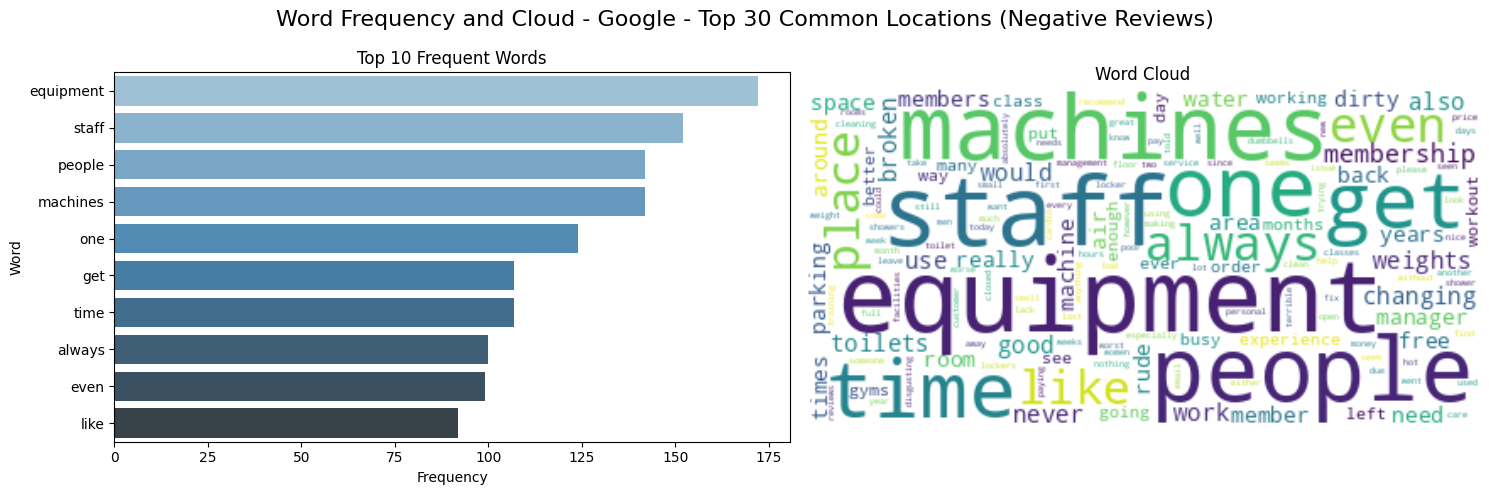

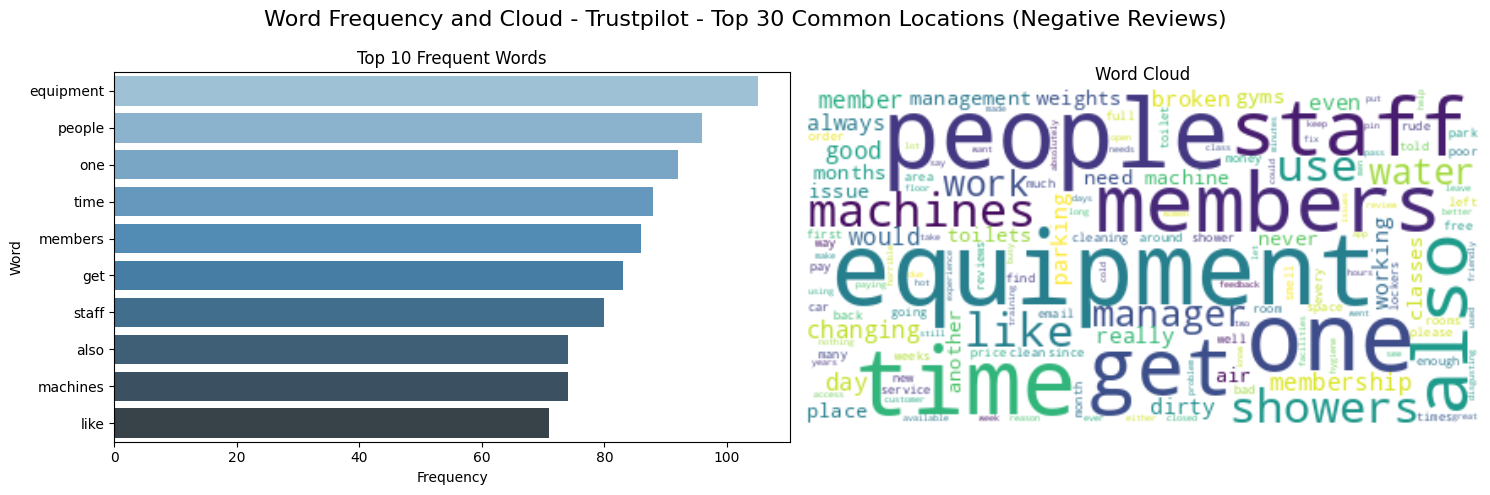

In [ ]:
# Get the list of top 30 common locations from the previously created DataFrame
top_30_common_locations = top_30_common['Location'].tolist()

# Filter both datasets for these top 30 common locations
google_top30_common = google_df_negative[google_df_negative["Club's Name"].isin(top_30_common_locations)]
trustpilot_top30_common = trustpilot_df_negative[trustpilot_df_negative["Location Name"].isin(top_30_common_locations)]

# Flatten token lists for each dataset from the filtered dataframes
google_tokens_top30_common = [word for tokens in google_top30_common['google_tokens'] for word in tokens]
trustpilot_tokens_top30_common = [word for tokens in trustpilot_top30_common['trustpilot_tokens'] for word in tokens]

# Generate wordclouds for negative reviews at top 30 common locations
display_wordcloud(google_tokens_top30_common, 'Google - Top 30 Common Locations (Negative Reviews)')
display_wordcloud(trustpilot_tokens_top30_common, 'Trustpilot - Top 30 Common Locations (Negative Reviews)')

Compared to the initial run on all locations, there is a noticeable improvement in the themes when the word frequency and word cloud for the top 30 sites are redone.  These locations' top Google review terms; equipment, people, staff, machines, one, time, even, always, get, like; remain consistent with the larger dataset, but "people" and "always" are becoming more prominent, suggesting worries about crowding and recurring problems that users may feel are unavoidable.  Equipment, people, members, get, one, time, like, use, machines, and staff are all included in the Trustpilot reviews for these top locations. However, "members" and "people" now stand out more, reflecting user annoyances related to membership procedures and interactions with other members in these particular clubs.Compared to the first run, the refined focus on high-traffic locations amplifies issues tied to overcrowding, ongoing equipment concerns, and customer service consistency, shifting from a general scan of dissatisfaction to a clearer, location-sensitive portrait of user pain points that can guide practical actions for staff retraining, clearer communication, and targeted equipment upkeep in these specific clubs.

#####  BERTopic for the top 30 location

In [ ]:
# Extract review text from both top 30 negative revies for both dataset
google_reviews_top30 = google_top30_common['Comment'].dropna().astype(str).tolist()
trustpilot_reviews_top30 = google_top30_common['Review Content'].dropna().astype(str).tolist()

# Merge both review lists
all_reviews_top30 = google_reviews_top30 + trustpilot_reviews_top30

# clean the reviews for BRETtopic
all_reviews_top30 = []
for review in all_reviews:
  #print(review)
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    all_reviews_top30.append(review)

In [ ]:
all_reviews_top30[0]

'too many students two local colleges go leave rubbish changing rooms sit like canteen going years cancel membership go gym group gym disgusting students hanging around machines messing around like school crowded ceo supports genocide civilians israel disgusting people '

In [ ]:
topic_model_negative = BERTopic(verbose=True)
topic_model_negative.fit(all_reviews_top30)
topic, probabilities = topic_model_negative.transform(all_reviews_top30)

2025-07-05 09:40:58,998 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

2025-07-05 09:41:04,766 - BERTopic - Embedding - Completed ✓
2025-07-05 09:41:04,767 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-05 09:41:27,870 - BERTopic - Dimensionality - Completed ✓
2025-07-05 09:41:27,871 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-05 09:41:28,001 - BERTopic - Cluster - Completed ✓
2025-07-05 09:41:28,007 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-05 09:41:28,159 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

2025-07-05 09:41:30,977 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-05 09:41:30,991 - BERTopic - Dimensionality - Completed ✓
2025-07-05 09:41:30,994 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-05 09:41:31,202 - BERTopic - Cluster - Completed ✓


In [ ]:
# List the top 10 topics from th BERTopic preprocessing with their document frequencies
topic_model_negative.get_topic_freq().head(11)

Topic  Count
1      -1   1694
4       0    301
2       1    193
3       2    144
8       3    114
16      4    110
24      5     92
19      6     91
22      7     87
18      8     68
6       9     53

same as before we will ignore the outlier topics

In [ ]:
topic_model_negative.visualize_topics()

In [ ]:
topic_model_negative.visualize_barchart(top_n_topics=10)

In [ ]:
# Heatmap showing the similarity matrix.
topic_model_negative.visualize_heatmap()

In [ ]:
from collections import defaultdict
from umap import UMAP

# Generate topic_info for the negative model
topic_info_negative = topic_model_negative.get_topic_info()

# Check if topic embeddings exist
if hasattr(topic_model_negative, 'topic_embeddings_'):
    topic_embeddings = topic_model_negative.topic_embeddings_

    # Reduce dimensionality of topic embeddings
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    reduced_embeddings = umap_model.fit_transform(topic_embeddings)

    print("BERTopic handles internal mapping for visualizations.")
    print("Using visualization functions below.")

    # Print clusters, their topics, and top 5 words
    print("\nTopic Descriptions (from topic_model_negative):")
    for index, row in topic_info_negative.iterrows():
        topic_id = row['Topic']
        if topic_id == -1:
            continue  # skip outliers
        name = row['Name']
        representation = row['Representation']
        print(f"\nTopic {topic_id}: {name}")
        print(f"  Top words: {', '.join(representation[:10])}")  # Top 10 words

else:
    print("Topic embeddings not found in topic_model_negative. Ensure it was fitted correctly.")

# Optional: Visualize hierarchy interactively
topic_model_negative.visualize_hierarchy(
    topics=topic_info_negative.Topic.tolist(),
    orientation='top'
)


BERTopic handles internal mapping for visualizations.
Using visualization functions below.

Topic Descriptions (from topic_model_negative):

Topic 0: 0_machines_equipment_weights_machine
  Top words: machines, equipment, weights, machine, weight, broken, enough, cable, bench, one

Topic 1: 1_air_conditioning_hot_aircon
  Top words: air, conditioning, hot, aircon, con, summer, ac, heat, temperature, working

Topic 2: 2_pin_code_pass_day
  Top words: pin, code, pass, day, paid, get, access, bought, email, help

Topic 3: 3_toilets_toilet_changing_dirty
  Top words: toilets, toilet, changing, dirty, rooms, always, smell, roll, cleaned, cleaning

Topic 4: 4_parking_car_park_fine
  Top words: parking, car, park, fine, free, fines, reg, ticket, website, enter

Topic 5: 5_music_loud_noise_hear
  Top words: music, loud, noise, hear, classes, volume, headphones, class, gym, play

Topic 6: 6_closed_open_days_christmas
  Top words: closed, open, days, christmas, opening, day, gym, notice, email, a


Running BERTopic on **combined Google and Trustpilot negative reviews for the top 30 locations** led to **more granular and location-specific topics** compared to the first run on all locations.

**Key differences from the first BERTopic run:**

* The **first run** grouped complaints broadly (equipment, staff, cleanliness, membership, air conditioning).
* This **run split those into precise, actionable subtopics**:

  * Air conditioning issues became **separate hot vs. cold complaints**.
  * Shower issues split into **cold water, fungus, dirty conditions**.
  * Equipment complaints now include **machine types, refurbishment delays, broken cables**.
  * Membership issues split into **fees, subscription, joining discounts, suspensions**.
  * Location-specific mentions appeared (e.g., **Bradford, Finchley, Abbey Wood, Tottenham Court**).
  * Social issues emerged (e.g., **Palestine/Israel boycott topic, staff rudeness with named staff, voice/mental bullying concerns**).

**What changed:**

* **More location references** surfaced, showing user frustration with specific gyms.
* **Granularity in common complaints** (showers, temperature, membership, cleanliness) clarifies which sub-issues matter most.
* Unusual niche topics (e.g., genocide boycott, mental health bullying, privacy in changing rooms) appeared, indicating topics with **low volume but high emotional intensity**.
* Some topics previously grouped under "equipment" are now separated into **refurbishment timelines, overcrowding around machines, and specific machine faults**.

**Additional insights gained:**

* Users are frustrated with **inconsistent water temperature**, requiring targeted maintenance tracking.
* **Air quality and ventilation complaints** are recurring and linked with gym overuse.
* **Peak time overcrowding** remains a top frustration despite location focus.
* Security concerns (locker theft, privacy in changing rooms) emerged as high-sensitivity issues.
* Complaints about **induction and class booking delays** indicate procedural bottlenecks impacting user experience.
* Negative sentiment towards management (specific names) shows reputational risks at certain sites.

# Emotion analysis

In [ ]:
#Import the BERT model bhadresh-savani/bert-base-uncased-emotion from Hugging Face, and set up a pipeline for text classification
classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", return_all_scores=True)


config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Use an example to test the emotion classification pipeline
example = "I am excited about the product"
classifier(example)

[[{'label': 'sadness', 'score': 0.0002085427986457944},
  {'label': 'joy', 'score': 0.9983842372894287},
  {'label': 'love', 'score': 0.0003700514498632401},
  {'label': 'anger', 'score': 0.00027803174452856183},
  {'label': 'fear', 'score': 0.0003054807602893561},
  {'label': 'surprise', 'score': 0.0004536988853942603}]]

In [ ]:
example_one = "I was shocked at his outburst"
classifier(example_one)

[[{'label': 'sadness', 'score': 0.00042066379683092237},
  {'label': 'joy', 'score': 0.0011910507455468178},
  {'label': 'love', 'score': 0.001337101450189948},
  {'label': 'anger', 'score': 0.0034400951117277145},
  {'label': 'fear', 'score': 0.007188653107732534},
  {'label': 'surprise', 'score': 0.9864223599433899}]]

In [ ]:
# Define a function to get top emotion and classify emotions

def get_top_emotion(text):
    """
    Function to get the top emotion for a given text
    """
    try:
        # Ensure text is string and not empty
        if not isinstance(text, str) or len(text.strip()) == 0:
            return 'neutral'

        # Truncate text to 512 characters (BERT limit)
        text = str(text)[:512]

        # Get emotion predictions
        results = classifier(text)

        # Get the emotion with highest score
        top_emotion = max(results[0], key=lambda x: x['score'])['label']

        return top_emotion

    except Exception as e:
        print(f"Error processing text: {e}")
        return 'neutral'  # Default emotion if error occurs

def classify_emotions_batch(df, text_column, batch_size=32):
    """
    Function to classify emotions in batches for better performance
    """
    # Prepare texts
    texts = df[text_column].fillna('').astype(str).str[:512].tolist()

    # Process in batches
    all_emotions = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        try:
            # Get predictions for batch
            batch_results = classifier(batch_texts, truncation=True)

            # Extract top emotion for each text in batch
            batch_emotions = []
            for result in batch_results:
                top_emotion = max(result, key=lambda x: x['score'])['label']
                batch_emotions.append(top_emotion)

            all_emotions.extend(batch_emotions)

            # Progress indicator
            print(f"Processed {min(i+batch_size, len(texts))}/{len(texts)} texts")

        except Exception as e:
            print(f"Error processing batch {i//batch_size + 1}: {e}")
            # Fill with neutral for failed batch
            batch_emotions = ['neutral'] * len(batch_texts)
            all_emotions.extend(batch_emotions)

    return all_emotions

In [ ]:
# Run emotion classification on Google dataset
print("Classifying emotions for Google dataset...")
google_emotions = classify_emotions_batch(google_df, 'Comment', batch_size=32)
google_df['top_emotion'] = google_emotions

print(f"Google dataset: {len(google_emotions)} emotions classified")
print("Google emotion distribution:")
print(google_df['top_emotion'].value_counts())

# Run emotion classification on Trustpilot dataset
print("\nClassifying emotions for Trustpilot dataset...")
trustpilot_emotions = classify_emotions_batch(trustpilot_df, 'Review Content', batch_size=32)
trustpilot_df['top_emotion'] = trustpilot_emotions

print(f"Trustpilot dataset: {len(trustpilot_emotions)} emotions classified")
print("Trustpilot emotion distribution:")
print(trustpilot_df['top_emotion'].value_counts())

Classifying emotions for Google dataset...
Processed 32/11879 texts
Processed 64/11879 texts
Processed 96/11879 texts
Processed 128/11879 texts
Processed 160/11879 texts
Processed 192/11879 texts
Processed 224/11879 texts


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 256/11879 texts
Processed 288/11879 texts
Processed 320/11879 texts
Processed 352/11879 texts
Processed 384/11879 texts
Processed 416/11879 texts
Processed 448/11879 texts
Processed 480/11879 texts
Processed 512/11879 texts
Processed 544/11879 texts
Processed 576/11879 texts
Processed 608/11879 texts
Processed 640/11879 texts
Processed 672/11879 texts
Processed 704/11879 texts
Processed 736/11879 texts
Processed 768/11879 texts
Processed 800/11879 texts
Processed 832/11879 texts
Processed 864/11879 texts
Processed 896/11879 texts
Processed 928/11879 texts
Processed 960/11879 texts
Processed 992/11879 texts
Processed 1024/11879 texts
Processed 1056/11879 texts
Processed 1088/11879 texts
Processed 1120/11879 texts
Processed 1152/11879 texts
Processed 1184/11879 texts
Processed 1216/11879 texts
Processed 1248/11879 texts
Processed 1280/11879 texts
Processed 1312/11879 texts
Processed 1344/11879 texts
Processed 1376/11879 texts
Processed 1408/11879 texts
Processed 1440/11879 text

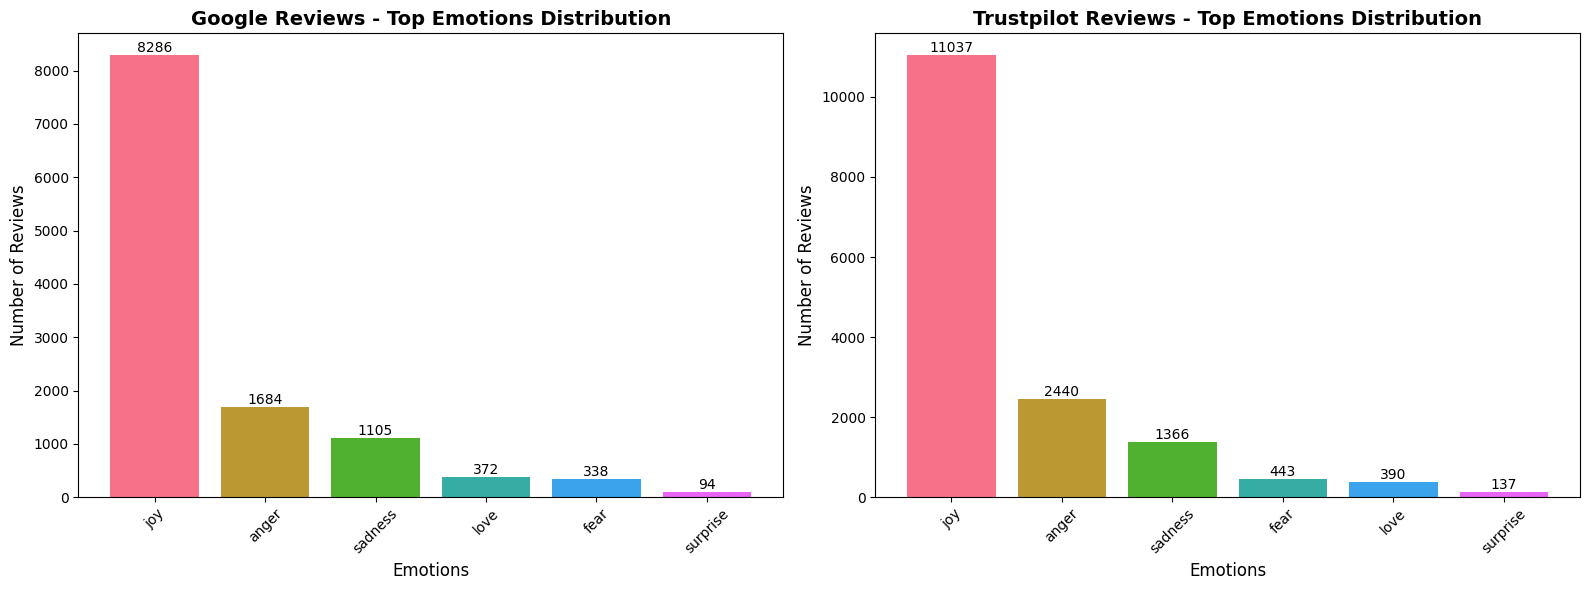

In [ ]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for both datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Google Dataset Emotions
google_emotion_counts = google_df['top_emotion'].value_counts()
bars1 = ax1.bar(google_emotion_counts.index, google_emotion_counts.values,
                color=sns.color_palette("husl", len(google_emotion_counts)))
ax1.set_title('Google Reviews - Top Emotions Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotions', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# Plot 2: Trustpilot Dataset Emotions
trustpilot_emotion_counts = trustpilot_df['top_emotion'].value_counts()
bars2 = ax2.bar(trustpilot_emotion_counts.index, trustpilot_emotion_counts.values,
                color=sns.color_palette("husl", len(trustpilot_emotion_counts)))
ax2.set_title('Trustpilot Reviews - Top Emotions Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Emotions', fontsize=12)
ax2.set_ylabel('Number of Reviews', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

##### Extract all the negative reviews (from both data sets) where anger is top emotion.

In [ ]:
# Extract all the negative reviews from both data set where anger is a top emotion where overall score is less than 3
anger_reviews_google = google_df[(google_df['top_emotion'] == 'anger') & (google_df['Overall Score'] < 3)]
anger_reviews_trustpilot = trustpilot_df[(trustpilot_df['top_emotion'] == 'anger') & (trustpilot_df['Review Stars'] < 3)]

In [ ]:
anger_reviews_google.head(3)

Club's Name       Creation Date  \
1   Cambridge Leisure Park 2024-05-09 22:48:39   
7               New Barnet 2024-05-09 20:16:04   
57             London Oval 2024-05-08 22:31:31   

                                              Comment  Overall Score  \
1   Too many students from two local colleges go h...              1   
7   This gym is way too hot to even workout in. Th...              2   
57  The gym is huge but where is all the equipment...              1   

                                        google_tokens top_emotion  
1   [many, students, two, local, colleges, leave, ...       anger  
7   [way, hot, even, workout, windows, open, barel...       anger  
57  [huge, equipment, could, easily, fit, double, ...       anger

In [ ]:
anger_reviews_trustpilot.head(3)

Review Created (UTC)                              Review Title  \
49  2024-05-09 08:47:00   I payed twice and i still didnt get my…   
51  2024-05-09 08:03:00      Not the best experience at 7am on a…   
59  2024-05-08 21:28:00  Got raped in this location multiple time   

                                       Review Content  Review Stars  \
49    I payed twice and i still didnt get my day pass             1   
51  Not the best experience at 7am on a week day. ...             1   
59  Got raped in this location multiple time wait ...             1   

   Review Language Company Reply Date (UTC)        Location Name  \
49              en                      NaT                  NaN   
51              en                      NaT  Bristol Harbourside   
59              en                      NaT                  345   

                                    trustpilot_tokens top_emotion  
49       [payed, twice, still, didnt, get, day, pass]       anger  
51  [best, experience, week, day, bought, day, pas...       anger  
59  [got, raped, location, multiple, time, wait, s...       anger

In [ ]:
# Extract review text and clean from both Anger datasets
google_reviews_top30 = google_top30['Comment'].dropna().astype(str).tolist()
trustpilot_reviews_top30 = trustpilot_top30['Review Content'].dropna().astype(str).tolist()

# Merge both review lists
all_reviews_top30 = google_reviews_top30 + trustpilot_reviews_top30

# clean the reviews for BRETtopic
all_reviews_top30 = []
for review in all_reviews:
  #print(review)
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    all_reviews_top30.append(review)
    all_reviews_top30[0]

###### Run BERTopic on the output of the Anger reviews

In [ ]:
# Extract review from both top emotion datasets
anger_reviews_google_topemo = anger_reviews_google['Comment'].dropna().astype(str).tolist()
anger_reviews_trustpilot_topemo = anger_reviews_trustpilot['Review Content'].dropna().astype(str).tolist()


# Merge both review lists
all_reviews_topemo = anger_reviews_google_topemo + anger_reviews_trustpilot_topemo

# clean the reviews for BRETtopic
all_reviews_topemo = []
for review in all_reviews:
  #print(review)
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    all_reviews_topemo.append(review)

In [ ]:
all_reviews_topemo[0]

'too many students two local colleges go leave rubbish changing rooms sit like canteen going years cancel membership go gym group gym disgusting students hanging around machines messing around like school crowded ceo supports genocide civilians israel disgusting people '

In [ ]:
topic_model_negative_topemo = BERTopic(verbose=True)
topic_model_negative_topemo.fit(all_reviews_top30)
topic, probabilities = topic_model_negative_topemo.transform(all_reviews_top30)

2025-07-05 10:41:44,882 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

2025-07-05 10:41:50,717 - BERTopic - Embedding - Completed ✓
2025-07-05 10:41:50,718 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-05 10:42:16,530 - BERTopic - Dimensionality - Completed ✓
2025-07-05 10:42:16,531 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-05 10:42:16,656 - BERTopic - Cluster - Completed ✓
2025-07-05 10:42:16,661 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-05 10:42:16,805 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/121 [00:00<?, ?it/s]

2025-07-05 10:42:19,774 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-05 10:42:19,786 - BERTopic - Dimensionality - Completed ✓
2025-07-05 10:42:19,787 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-05 10:42:19,948 - BERTopic - Cluster - Completed ✓


In [ ]:
topic_model_negative_topemo.visualize_topics()

In [ ]:
topic_model_negative_topemo.visualize_barchart(top_n_topics=10)

In [ ]:
from collections import defaultdict
from umap import UMAP

# Generate topic_info for the negative_topemo model
topic_info_negative_topemo = topic_model_negative_topemo.get_topic_info()

# Check if topic embeddings exist
if hasattr(topic_model_negative_topemo, 'topic_embeddings_'):
    topic_embeddings = topic_model_negative_topemo.topic_embeddings_

    # Reduce dimensionality of topic embeddings
    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )
    reduced_embeddings = umap_model.fit_transform(topic_embeddings)

    print("BERTopic handles internal mapping for visualizations.")
    print("Using visualization functions below.")

    # Print clusters, their topics, and top 10 words
    print("\nTopic Descriptions (from topic_model_negative_topemo):")
    for index, row in topic_info_negative_topemo.iterrows():
        topic_id = row['Topic']
        if topic_id == -1:
            continue  # skip outliers
        name = row['Name']
        representation = row['Representation']
        print(f"\nTopic {topic_id}: {name}")
        print(f"  Top words: {', '.join(representation[:10])}")  # Top 10 words

else:
    print("Topic embeddings not found in topic_model_negative_topemo. Ensure it was fitted correctly.")

# Optional: Visualize hierarchy interactively
topic_model_negative_topemo.visualize_hierarchy(
    topics=topic_info_negative_topemo.Topic.tolist(),
    orientation='top'
)


BERTopic handles internal mapping for visualizations.
Using visualization functions below.

Topic Descriptions (from topic_model_negative_topemo):

Topic 0: 0_air_conditioning_hot_aircon
  Top words: air, conditioning, hot, aircon, con, summer, ac, heat, working, warm

Topic 1: 1_toilets_toilet_changing_cleaning
  Top words: toilets, toilet, changing, cleaning, dirty, rooms, soap, smell, always, clean

Topic 2: 2_code_pass_pin_day
  Top words: code, pass, pin, day, bought, email, get, paid, sent, qr

Topic 3: 3_parking_car_park_fine
  Top words: parking, car, park, fine, free, fines, reg, ticket, website, enter

Topic 4: 4_manager_rude_member_staff
  Top words: manager, rude, member, staff, gym, personal, said, aggressive, voice, told

Topic 5: 5_closed_open_christmas_days
  Top words: closed, open, christmas, days, opening, day, gym, email, closing, boxing

Topic 6: 6_smell_smells_ventilation_air
  Top words: smell, smells, ventilation, air, bad, gym, smelly, stinks, like, sweat

Topi

**Comparative Analysis: BERTopic Results for Top 30 Negative Locations vs. Emotionally Negative Reviews**  

*(Key Changes, Improvements, and Insights)*  
## Key Changes

* **Cleaner, more consistent labelling** in `topic_model_negative_topemo` (e.g., Topic 0: air conditioning) compared to slight noise in `topic_model_negative` (e.g., “0\_machines\_equipment\_weights\_machine”).

* **Overlap in core pain points**, but `topemo` shows:

  * More topics on **equipment condition** split across multiple angles:

    * Topic 18 (machine, cable, chest)
    * Topic 22 (equipment broken, dated)
    * Topic 23 (rowing machines)
    * Topic 32 (benches, squat racks)
    * Topic 34 (weights, plates)
  * Whereas the first output clusters these under broader equipment/machines categories.

* **More nuanced crowding issues:**

  * `topemo` splits into:

    * Topic 29 (busy, peak wait)
    * Topic 30 (busy, too small)
    * Topic 31 (equipment small, not enough)
  * Earlier output lumps into:

    * Topic 15 (waiting, busy)
    * Topic 22 (overcrowded).

* **Sanitation and showers** remain consistent, but `topemo` expands:

  * Topic 16 (showers, fix)
  * Topic 19 (cold showers)
  * Topic 26 (toilet, showers, privacy)
  * Topic 28 (dirty toilets cleaned)
  * Whereas `topic_model_negative` has:

    * Topic 3 (toilets dirty)
    * Topic 14 (showers dirty)
    * Topic 21/23/44 (cold showers).

* **Complaint about CEO/Israel boycott** consistently appears in both as a dedicated topic (Topic 40/42).


## Improvements in `topemo` output

* **Finer granularity** in issues around **machines, weights, and equipment type.**

* Clearer separation between **equipment space issues** and **overcrowding issues**.

* Slightly **better separation of location-specific complaints** (e.g., Finchley, Abbey Wood, Totterham).

* **Language around staff rudeness** becomes more clustered (Topics 4, 13), avoiding split clusters across unrelated terms.




# LLM-Augmented Topic Analysis & Actionable Insights Generation from Negative reviews dataset

##### Clean comment column in both dataset for LLM model

Due to computing limitations we will use a subset of the negative reviews for the LLM

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving trustpilot_neg.csv to trustpilot_neg.csv
Saving google_neg.csv to google_neg.csv


In [ ]:
import pandas as pd

# Load the datasets
google_df_negative = pd.read_csv('/content/google_neg.csv')
trustpilot_df_negative = pd.read_csv('/content/trustpilot_neg.csv')

# Check shape
print(google_df_negative.shape)
print(trustpilot_df_negative.shape)

(2423, 5)
(3403, 8)


In [ ]:
# Create subset of negative reviews for both dataset
google_subset_neg = google_df_negative.sample(n=1000, random_state=42)
trustpilot_subset_neg = trustpilot_df_negative.sample(n=1000, random_state=42)

In [ ]:
import torch
import json
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
torch.random.manual_seed(0)

In [ ]:
model_llm = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-4-mini-instruct",
    device_map="auto",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-4-mini-instruct")

config.json: 0.00B [00:00, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model_llm,
    tokenizer=tokenizer,
)

Device set to use cuda:0


In [ ]:
generation_args = {
    "max_new_tokens": 1000,
    "return_full_text": False,
    "do_sample": False,
}

In [ ]:
# Create subset of negative reviews for both dataset
google_subset_neg = google_df_negative.sample(n=1000, random_state=42)
trustpilot_subset_neg = trustpilot_df_negative.sample(n=1000, random_state=42)

# Extract review text columns as lists
bad_google_reviews_list = google_subset_neg['Comment'].astype(str).tolist()
bad_trustpilot_list = trustpilot_subset_neg['Review Content'].astype(str).tolist()

# Combine the lists
bad_reviews_list = bad_google_reviews_list + bad_trustpilot_list

print(f"Total reviews to process: {len(bad_reviews_list)}")

Total reviews to process: 2000


In [ ]:
topics_llm = []

print("Total reviews:", len(bad_reviews_list))

for idx, review in enumerate(bad_reviews_list):
    if len(str(review)) >= 500:
        continue

    print(f"\nReview {idx + 1}: {review}\n")

    messages = [
        {
            "role": "system",
            "content": (
                "You are a data analyst extracting top 3 improvement topics from customer reviews. "
                "Return ONLY a valid JSON array of strings using double quotes. "
                "If any topic contains apostrophes, replace them with backticks. "
                "Example output: [\"Trainer`s attitude\", \"Communication\"]"
            )
        },
        {
            "role": "user",
            "content": f"Extract the top 3 improvement topics from this customer review: {review}"
        },
    ]

    try:
        output = pipe(messages, **generation_args)
        generated_text = output[0]['generated_text'].strip()

        # Clean common LLM output issues:
        # Replace unescaped apostrophes inside double quotes with backticks
        generated_text = re.sub(r'(".*?)(\'s)(.*?)"', lambda m: m.group(0).replace("'s", "`s"), generated_text)

        # Optional: remove trailing commas
        generated_text = re.sub(r",\s*\]", "]", generated_text)

        # Parse safely
        topic_list = json.loads(generated_text)

        if isinstance(topic_list, list):
            topics_llm.append(topic_list)
        else:
            print("Skipped, output not a list:", generated_text)

    except Exception as e:
        print(f"Error on review {idx + 1}: {e}")
        print("Generated text:", generated_text)
        continue

print("\nSample collected topics:", topics_llm[:3])
print("Total topic lists collected:", len(topics_llm))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Total reviews: 2000

Review 4: To much equipment in small area .. can lift incline bench while somebody is takeing lond dumbels. Guy was hit by barbel of guy doing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 4: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Space utilization", "Equipment organization", "Safety"]
```

Review 5: Not good at all, most of the male lockers are damaged, when is busy you need to waste too much time to find locker which is working properly to keep to stuff securly locked, only one private shower, second out of service for months



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 5: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Locker condition", "Locker availability", "Shower facilities"]
```

Review 6: Unbelievably crowded ridiculous staff attitude when needing help always waiting for someone to answer the speak to your gym team button waited 20mins never evan came outrageous I DO NOT RECOMMEND MAIDENHEAD PUREGYM



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 6: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff attitude", "Waiting time", "Gym team response"]
```

Review 7: Gym is small but clean. The showers are so cold though (after a workout). Reported numerous times but nothing has been done. The shower head is for anyone that would be 9 feet tall so maybe they would benefit from the heat.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 7: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower temperature", "Shower head size", "Maintenance"]
```

Review 8: Any time there is an issue it takes ages to get fixed, with this heat the gym smells like sweaty and poo :)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 8: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Response time", "Cleanliness", "Odor"]
```

Review 9: Too many people, always full and terrible ventilation.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 10: Lots of equipment and good size but now oversubscribed and so busy even at 5am. Plus they have had no handwash in the toilets for four days now and no hand sanitiser (puke emoji) if you can afford another gym I suggest you stay away from PureGym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 11: Air con in the spin room doesn't work, not nice conditions to exercise in.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 12: very spacious equipment uses the entire gym space making people squeeze together to work out.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 13: Decent gym with good equipment just too small for its own good. don't expect to get anything done during term time holidays as the place gets absolutely packed to the point where it's stupid and impossible to do anything, desperately needs expanding



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 15: Twice the door opened only from one side and then refused to let me in. I'm so angry and shows me that I am in BUT I am out. I hate this door !!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 16: High quality good vibrations wear my hair back to front



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 17: No wifi , a/c and old equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 18: Don't even waste your time at the gym. Everything is broken, they run out of paper towels to wipe down the machines,  the bubble doors never work and there is no way to contact the staff to let you in. Even the trainers look  like they hate it. This is the worse gym that I've ever been to. I've been with this gym for 5 months and I'm cutting ties. I plan to cancel my membership and not look back. I wish I could give this gym a negative 10.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 19: used to be good until they increased the membership price. now it’s squashy, stinks and gets way too hot and stuffy. AC never seems to be on either. also love when i’m working out in the rainy weather and the tiles cave into my head



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 19: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["AC performance", "Temperature control", "Air quality"]
```

Review 20: Was like walking into a zoo. Couldn’t find the exit either, massive maze - disappointing, will never go back here



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 21: Terrible customer service



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 22: Terrible, I lost money during lockdown, which I never get



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 24: Just paid a day pass and waited an hour to get my code outside in the cold. No staff no telephone contact and local messages what stupid system I wont be going back.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 24: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Communication system", "Customer service"]
```

Review 26: Member of staff who gave me a class was very helpful, knowledgeable and friendly. I decided the gym wasn't for me though as it was too over crowded unfortunately at a time of the evening you wouldn't expect it to be. This meant I couldn't get to use the equipment I wanted to and in particular the free weights and benches.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 26: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["crowded", "equipment availability", "free weights and benches"]
```

Review 27: I’ve been to this gym for about a year now, the changing rooms are smelly even with the refurbishment. Staff rarely smile or say hello.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 27: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing room cleanliness", "Staff friendliness", "Smell in changing rooms"]
```

Review 29: I am not happy with this gym, a lot of machines are out of order from days, they dont care to fix them, i think i will change the gym cause they don t do nothing new or at least fix the one you have them.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 30: I paid for Beaufort gym and they sent me to city center . I tried refund option and .......nothing  .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 30: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Location", "Refund process", "Customer service"]
```

Review 33: I will not lie, I am always in Belfast for the last 3 years and always went to PureGym at Adelaide st but my last experience was terrible.
A group of 3 guys working at puregym as personal trainers were talking about me and laughing - I felt very uncomfortable and couldn’t believe that was happening.
I have 2 girl friends that went in different days and also experienced that kind of behavior recently from the staff - unacceptable



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 33: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Unacceptable staff conduct", "Personal trainers' conduct"]
```

Review 34: Turned up here at 0400 to see a sign that the gym won't open until 0600 due to CCTV fault. Told it would be fixed, wait around till 0600 get told it shpuld be fixed today and be ok tomorrow. Turn up at 0400 again to the same message. There should be a way of informing this on the app. It takes a lot of motivation to get here for 0400 to get my workout in before busy days. Complete waste of my time 🙄



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 35: Poor management, no staff and trainers, classes cancelled all the time without notice



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 37: The parking supposed to free. Apparently it is not as most of time the machines are not working properly and so far I ended up paying over £20 for parking in one month!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 39: Don't know never went in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 40: Why replace machines with ones without the in-built AC feature? 😭



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 41: The gym has really gone down hill. The equipment are in awful condition. Has been like this for a while and nothing has been done to replace the equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 43: Super unfriendly staff - service does not seem to lie within their DNA



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 44: No longer supply cleaning supplies by cardio equipment, but they now have it  by the free weights area &  the studio, go figure



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 46: It's always too busy, not enough space or equipment to accommodate everyone and there's always people hanging about waiting to use equipment.
I agree with others it is quite an unsanitary gym and could use improvement in that area.
Staff are unapproachable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 47: Machines always busy as gym is constantly rammed no matter what time you attend. The whole gym is stupidly hot with no ventilation causing working out to be unbearable and the whole gym smelling of sweat. Also noticed weights being left all over the floor and not being put back which makes it impossible to find anything.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 48: The showers are terrible and are not cleaned often. I reported mould and 2 weeks later still showing. Staff are really nice cannot make excuses for showers.
Update: received message advising they are AWARE of issue and discussing with contractors. Which basically means you pay full price for a service you can’t use! Unreal response



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 49: I've not been to that gym in three years ago it was clean enough but now that gym has gone downhill



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 50: More like a youth centre, full of young kids play fighting,groups of sikny little boys messing about !not a proper gym go elsewhere 💯 % pathetic needs new management and staff also ! Shocking actually



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 51: Usually very nice but on weekends cleanliness is horrible.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 52: There is a personal thief in this gym. I had my locker broken into and my valuables taken. Gym staff confirmed this has happened before, where they open the padlocks, take what they want and then re lock the lockers. Making it a smooth and clean job! It’s funny no appropriate measures are put in place to tackle this issue.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 54: Very annoyed I couldn't even access this place even with a premium membership! I couldn't even upgrade it or get a day pass for it as "I'm already a member" ridiculous!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 54: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access issues", "Upgrade process", "Day pass availability"]
```

Review 58: gym is great some staff are rude and unpleasant tho



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 60: Good place, good equipment.  But the changing room and unisex bathrooms are terrible.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 61: Too small. Have to go at silly hours to get on any equipment or machines



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 63: Has the potential to be a good gym, however some of the members don’t have good etiquette as well parking in disabled bays without a blue badge.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 64: The gym is filthy, and there's no manager here.

When I came in, Ben ( one of the PT'S was hoovering and cleaning downstairs, but when I got into the female changing rooms, they are disgusting.

The amount of hair on the  floor is gross.

The evening cleaners do absolutely nothing.

The only cleaner who actually does clean properly is the Muslim lady who  comes on a Thursday.

You need to sort out the cleaning company, this isn't acceptable



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 64: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning", "Management", "Staffing"]
```

Review 67: I'm.sute it's great if you like very loud music and sweat



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 69: The Members are always parking in the disabled bays. You would think that these super fit people could manage to walk a few more feet



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 70: Classes are always cut short if not enough bookings or cancelled with no notice.

Waste of a monthly fee as you rarely get a good full workout.

I dont use the gym so can't comment on that side of things.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 70: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Class duration", "Cancellation policy", "Value for money"]
```

Review 71: Repair the door or it's gonna injure someone! Been like this for last 2 days. Ignorant management!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 72: £1200 for 5 parking notices in my 1st week. Avoid, Puregym won't help you to cancel the notices
Many years have passed and customers still pay hundreds of pounds every day for parking. They cannot solve this problem, and on the website they have information that parking is free. It is clear that they are happy with it.
Naturally, I changed the gym to one with free parking.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 73: No stretching area for boys (always classes going on) ,after paying 25pounds per month it should be open early morning 5am because so many people prefer early morning workout. Less dumbbells sets of lower weight 5 to 10kg. Always occupied and have to weight long. Not feeling like 25pounds fees per month is worth it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 74: EDIT 21.12.23: In addition to below, showers icecold for two weeks, and now not working at all. Puregym should reimburse its members, at least in part. The noise here is unbearable. I feel sorry for my ears. No chance to even listen to my own music. It's an inconsiderate youth culture here. Ok for training but the noise pollution is just nasty, meaning the volume they put that 'music' on. My own tunes over headphones don't keep the racket out. It's inconsiderate. Hence, only two stars



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 74: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Noise pollution", "Music volume", "Customer service"]
```

Review 76: Too many cars in the car park that you can't ever park there for halfords



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 77: I love Pure gyms but get the feeling this one isn't being run to its fully potential.
It needs cleaning more frequently and loo paper stocking up etc! And there are loads of unused cardio equipment, but for the size of the place very little stretching area or free weights space. Always a queue for bench press and deadlift.

Need more plates and also more safety grips for the free weights.

Missing some good bits of kit that other pure gyms have too (for example assault bikes).



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 77: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["cleaning frequency", "cardio equipment", "free weights space"]
```

Review 79: The staff at this gym are unbelievably rude and unprofessional.
The assistant manager there looks down at people. One of the "personal trainers" there kept making sly comments to me when walking past. I tried speaking to the manager and higher up but no one seems to care.If you are shy or anxious this gym is really not for you.

The gym itself is alright and at a good price but the staff there ruin it.
Definitely wouldn't recommend especially for women.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 81: The manger at puregym leytonstone was very disrespectful and verbally abusive towards me the customer service was poor he also seemed to have a personal problem with me and he had zero manners whatsoever I don't recommend this gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 81: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Manager`s behavior", "Gym atmosphere"]
```

Review 83: Exercise machines facing each other in a circle (great planning!), now looking at other hot sweaty faces, instead of having cardio machines facing out the huge windows.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 84: Staff are a bit rude, apart from the female manager she was nice. Such a lovely big space but it’s missing quite a lot of important equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 86: Would help if theyd update is on how long the gym out for



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 88: I love this gym because is the gym I go to. HOWEVER, the hygiene of this particular gym is very much below average. I know they clean because I see the cleaners all the time but they’re job…very very poor in particular the women’s toilet 🤮 otherwise is fine. But it definitely affects your experience when you are trying to go to the gym to improve yourself and you see the lack of cleanliness at the toilet



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 88: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hygiene", "Cleanliness", "Women’s toilet"]
```

Review 89: Very dirty and poorly maintained. Have seen the manager ( tall mixed race man) smoking weed next to the gym multiple times (i work in the starbucks next door). Which probably explains why the cleaning standards are so low in the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 90: Broken treadmills everywhere.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 91: Must be one of the worst puregyms I’ve been to, desperately needs a refurb, weights are always everywhere never put back and people aren’t told to, hand sanitizer is never filled, toilets aren’t cleaned and nowhere else is



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 92: Price is the only plus. Equipment is not maintained. Better chose a different gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 93: Gym is poorly kempt, female changing rooms stinking to the point eyes watering, beyond a disgrace, equipment constantly broken



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 94: Really good gym in terms of equipment, tonnes of racks and benches and lots of space to do everything. This is however, the filthiest gym I have ever seen. Weights and equipment scattered all over the floor throughout the gym. The changing rooms are the worst I have seen and I have visited many pure gyms, staff checks are signed and place is still a tip. The showers are also very cold.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 94: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Changing rooms", "Shower temperature"]
```

Review 95: Closed! 365 days a year is a lie



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 96: People hog equipment using it as a rest area,others stand posing beside them. There was a number of thefts from lockers etc,no shower open at night, vacuuming begins whenever you start your workout.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 97: Consistently no soap in the toilets



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 98: Tell my y there is a homeless man sleeping in the entry inside the gym please I’m trying to find a phone number on the website no help this was around 2:30 in the morning Wednesday 12th July



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 98: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security", "Customer Service", "Website Help"]
```

Review 99: Spacious gym, a lot of machines to work with. I like the studio hall, very spacious too.

My only complain is the shower and toilet facilities need to be looked after, for me cleanliness is a big deal this why I have it a 2 star.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 99: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower and toilet facilities", "Cleanliness", "Maintenance"]
```

Review 102: To many people for a 10 ft gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 103: Good but if it wasn't for the loud, banging music they inconsiderately play for classes!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 104: Worst gym in the area not worth it too many machines out of order kids around running and seating on benches playing on phone. the other issue I don't know why didn't close the gym when the ceiling is leaking and taping the weight area too many people on 7 machines, disgraceful



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 104: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Crowding", "Facility cleanliness"]
```

Review 105: Cleaning stations not often available around the gym. They removed cleaning stations, the ones they have don’t work at the best of times.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 107: No way to enter and no-one to contact.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 108: Couldn't get into the gym for 20 minutes, no staff members were present (this was at 6pm). When I finally got inside the lock I bought off the vending machine didn't work, had to carry my bag around the gym. Staff super unhelpful. Horrible experience, stay clear.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 108: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Vending machine functionality", "Customer service"]
```

Review 109: Charged double payment as fee for missing one payment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 110: Cramped and dirty. Air conditioning broken for 2+ weeks in the middle of a heatwave. At the same time, no drinking water available due to low water pressure. Avoid at all costs!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 111: Numerous machines in the spin room are malfunctioning, and despite multiple assurances that they will be replaced once approved by Pure Gym headquarters, this has not happened. I empathize with the management and staff at Pure Gym who must repeatedly communicate this issue.Pure Gym, I urge you not to compromise on standards any further. I've heard that some individuals are contemplating switching to another gym due to these concerns.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 111: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine malfunctions", "Communication with headquarters", "Gym standards"]
```

Review 113: Worst gym ever machines are always broken equipments are not always available toilets re not clean…waste of money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 113: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Cleanliness", "Availability"]
```

Review 114: Sick of going no matter what time day or night and constantly waiting over 30-40 minutes just for a set of weights or god forbid a machine! Outdated btw. If so many of us use the weights from 4-10kg get in another set of them like the other puregym branches do. Just gonna cancel and try a new gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 116: I have been a member of this gym for two months. The water in the showers comes out very cold and they are very dirty, now that it is winter it should be warmer. and the wifi doesn't work so I have to use my data traffic. In addition, the flavored water dispensing machine always works. I think there are things that need to be improved



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 120: Not many equipments, too busy even when not busy(I mean the equipments) and 90mins free parking is not enough at all. I just used  a day pass with O2(for £1) so I am happy thay did not buy the membership pass.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 120: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Parking space", "Membership pass value"]
```

Review 123: For its size it's disappointing let some one in because there's no sign up screen and within hours my membership is stopped but no one can help you



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 123: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Sign-up process", "Customer support", "Membership management"]
```

Review 124: I have had my airpods stolen from me while doing my workout and they wouldn’t even check cctv. As well as this staff are extremely rude and have favouritism between certain members



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 125: The changing rooms and showers smell stale and like mould they need a deep clean ASAP. also people act like filthy animals. A notice needs to go up to inform people of their cleanliness. Some machines are tired and used especially some of the treadmills not having always functioning buttons have to press hard for it to work. Would love to see mainly the changing rooms cleaner 😁



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 126: Too crowded with teenagers as young as 15 hanging around each equipment, chatting. More like a teenage youthclub. Very off putting for mature Adults unfortunately.  Too expensive now considering you don't get a pool or steamroom. No pure gyms have these facilities.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 126: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Crowded with teenagers", "Expensive", "Lack of facilities"]
```

Review 127: Honestly one of the worst gym ever. This gym is super packed. You have to wait in line just to use some of these machines. I wanted to join a gym that’s 24/7 but it’s the evening that’s the worst. At 9pm there over 100 people at the gym. They put loud and horrible music I think they want you to come deaf. I only went three times but cancelled my membership today I have no regrets.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 127: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["24/7 hours", "Crowded", "Music volume"]
```

Review 128: Awful gym. For £21.99 a month it’s small, cramped, lacks equipment and is extremely busy. Avoid if you can.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 129: I have send many emails in regards to noise issues on the upper flats but everything fell on deaf ears. There is a huge banging noise each morning at 7 am coming from the gym.
The gym generally is overcrowded and the free weights area is inadequate in the sense that if someone uses a lot of discs on the leg press and deadlifts then good luck finding the discs for yourself to train. Pure gym in finchley is much better



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 129: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Noise issues", "Overcrowded gym", "Inadequate free weights area"]
```

Review 130: Overcrowded and limited gym hours. Initially advertised at 24 hours and I signed up. Recently they even increased the membership price and guess what, gym closes at 10pm. What is the point if the gym is literally busy from 5-10pm. Very disappointing!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 131: The gym has only 2 sets of cable fly machine that were all hogged by roadmen for 2 hours.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 132: Have tried to book twice now and they’ve cancelled both appointments with no reason.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 134: Absolutely crowded. Not possible to train, i already cancel my membership. They just allow new members but not increasing the capacity.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 135: The gym is fine but it has poor equipment and the changing rooms and showers are the worst, there has been no hot water for a long time and when you mention it to the stuff they do nothing to fix it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 135: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment", "Changing rooms and showers", "Hot water"]
```

Review 136: Way too small for the amount of people who live in the area.and thus not enough machines. But it’s the only option in close vicinity.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 138: Decent gym but costumer service is lacking. I tried contacting them to buy one day access but the phone number that's listed just has an answering machine saying they don't accept phone calls. Then when I reach out on fb messenger they announce a 12hr wait for answers. And on the website I can't find anything about buying one day access without cancelling my current subscription at another branch



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 139: Had a friend add me as a buddy, turns out you can only accompany them at their "home" gym, you can't just pay for a day session though because you have an "active membership" - manager's response: "there's nothing I can do about it". Dreadful experience, but at least I didn't have to use a puregym...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 141: Why are your machines and equipment older than my grandfather's?
It is like everything in the UK: High Price > Low Quality!?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 142: Wouldn't ever step foot in here again.
Shame as it had the potential to be lovely but it was disgustingly filthy, smelt like broken toilets, equipment everywhere, machines broken and no signs to say so.
Honestly vulgar



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 143: The place is flooding (recent pic 10/09/23) and not one manager in sight to sort out. As a member I've had to put a bin under the leaking roof because there's no one around to do anything else. It's the age old saying. "Ain't a pure gym without a leaky roof"



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 144: Like the atmosphere of this gym. It is not very spacious but still good not overly crowded like Salford gym. Although why the male staff members of this gym be acting like the owners of Pure gym?! They need to work on their attitude and behaviour when dealing with ladies. You are just an employee so act like that!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 144: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff attitude", "Staff behaviour", "Staff professionalism"]
```

Review 145: This is a batterd gym. Only reason I'm still a member is that its 24hour. Definitely needs money spending on new equipment don't even have a calf machine. You just need to grind away. Personal trainers/staff are all good very helpful.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 145: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["New equipment", "Calf machine", "24-hour access"]
```

Review 146: No free parking sending parking tickets people be aware



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 147: Was ok until recently they started locking some of equipment and even the whole floor after the regular working hours, so 25% of the area is not accessible.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 150: Surprisingly pretty good inside changing review to 1 stars though because its been over 2 years and they still don't have the plus membership benefits e.g. yang sports water and or massage facilites



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 153: Most of the equipment is old and dated. Very well used. In dire need of full upgrade of all the equipment. If it wasn't for the fact that it's cheap and no contract it would receive one star.

I said this in the survey they sent me and their manager emailed very promptly. So the customer service appears to be good.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 153: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment upgrade", "Equipment condition", "Cost and contract"]
```

Review 155: Don't waste your time joining here. I tried to join recently, they took the money from my account and set up a direct debit.
I still haven't received Any membership information and there isn't really any way of contacting customer services.
3 days I have been waiting for a response and still nothing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 155: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership information", "Contact customer services", "Response time"]
```

Review 157: Stinks, everything is dirty, nothing even works, close this down cuz!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 158: Need to cap number of memberships, got a 6 month membership and I am deep in pain - 20% training 80% waiting. I hate this place (gym goer of about 2.5 years 5 times a week consistent)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 158: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Reduce waiting time", "Improve training quality", "Cap number of memberships"]
```

Review 160: The classes are so unnecessarily loud makes it so overstimulating



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 161: There is no WIFI in the gym, especially at the peak time. and there is no signal too
I went to ask and complain to the staff. All they explained is : “ its peak time “ ???
So i have no signal to find my work out
Also the gym sometimes closed for longtime, due to flooded floor. No refund or any discount. I will stop my membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 162: Under equipped gym, queue times of 40 mins



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 163: Machines always broken, full of kids, no space at peak times, disabled toilet always filthy. Been coming for 7 years but looking elsewhere



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 164: Rubbish, no one to talk to when you press the yellow button the staff are no where to be seen, 2 wasted trips now from Bexhill. Payment system keeps saying error and no phone number to call. Don't bother with this place!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 165: Recently moved to the area from Brighton was keen to find a new gym closer rather then travel into Brighton however I found Poor, cheap equipment rock hard benches that are slippery compared to the my old Gym in Brighton the Gym was over crowded and parking was a nightmare. Showers were dirty and had hair everywhere. I have now gone back to my old Gym in Brighton the travel is a pain but it’s worth it for the environment and far superior equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 165: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Crowding", "Parking"]
```

Review 167: Walked past it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 168: If I were to ever go again, it would only be because of the beautiful blonde who works their no other reason



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 170: Very bad communication with the staff manager. Someone stole my property from the gym and they don’t care at all. Very disappointed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 170: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Communication", "Security", "Customer service"]
```

Review 171: OBS! The changing rooms and showers are out of order due to maintenance so there’s no where to change your clothes! They refer to the toilets upstairs but they are also locked due to maintenance. So if you want to workout here, change from home or you’ll have to change in a corner (if brave enough) or wait to use the tiny 1m2 toilets in the back. I usually workout here but will go somewhere else when coming from work until it’s all fixed on the 27th of December



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 171: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing rooms and showers", "Toilets", "Lockdown"]
```

Review 172: The music please they have to change the music



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 173: Their website is so confusing. Pure gym in the uk allows to cancel membership before a few days the billing day but in Denmark you need to cancel more than 1 month before. And there is no indication if the website is uk’s or Danish. When I cancel my membership couple of weeks before they charged for one month more. It was pretty annoying.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 174: Out of date



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 175: Good gym but let down by most who use it. Constantly was going in and finding college students sat around on equipment and not using it. Nobody puts weights back so have to travel around the whole gym to find what you need. Really poor considering all the alternatives you have now. Staff are few and far between and try their best but need to be a bit stricter. Went to a newer gym out of town and gym etiquette is miles better.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 175: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym Etiquette", "Staff Availability", "Equipment Management"]
```

Review 176: Tgere is machines to train  the back (lats) rowing and lat pull down ,, super small gym . Only because it doesn’t have the machines to train your back that means its not a GYM . You are paying to train all of your muscles.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 176: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Back training equipment", "Gym size", "Muscle training"]
```

Review 177: booked a get started class, arrived there 15 mins before schedule, turns out there is no available instructor. bad start, should have cancelled the class instead.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 179: Such a poor and outdated gym. The layout is confused, a very small weights section, alot of the machines are rusty or out of action. I see why they charge such a decent rate now for membership, it's the classic cheap but not so cheerful motto. Snap fitness where I am now is leading the way and makes PureGym look a laughing stock



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 179: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Layout", "Equipment condition", "Service quality"]
```

Review 180: They banned me but otherwise it’s a decent gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 180: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership policies", "Customer service", "Gym facilities"]
```

Review 181: Terrible absolutely Terrible.
I could talk about the space but I would rather mention this.
They tell you it's contract FREE ! but trust me DO NOT MISS A PAYMENT.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 182: Generally good gym with decent equipment and kept tidy by staff and members, but the lack of working air con means workouts are muggy and 25 plus degrees is fairly usual now would recommend town centre most of the time due to the temperature inside this gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 182: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning", "Temperature control", "Comfort"]
```

Review 183: Most of the wiping stations have been removed (0 downstairs in free weights area) - why? cost savings? Toilets are often filthy, especially on weekends, and soap dispensers usually empty so install another.  Mens toilets /urinals often overflowing. Recent investment in additional equipment = 2 stars.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 184: I’m so sorry but idk what the the reviews are on about. This gym is clean Because the cleaners do a good job but the rest is absolute ridiculous. It’s a mess and most of the wires on equipment is broken… a bunch of pins and clips missing. You have to do a whole treasure hunt before you find what you need.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 184: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Organization", "Instruction clarity"]
```

Review 186: Class cancelled without notice. No notification, no information on the white board.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 187: It’s so bad that you almost have to laugh 😂 old equipment that no one ever puts away in the right spot and the layout makes no sense whatsoever



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 188: Location is wrong. Its a caravan park??



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 190: I’m really disappointed from puregymhayes today I went and they are closed today with no notice yesterday there was no water. I have not received any email regarding closing gym today I want to cancel membership from hayes. Really disappointed from hayes pure gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 190: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym closure notice", "Water availability", "Communication"]
```

Review 191: Good basic gym and good basic equipment. However 1 star because of two main reasons.
1)Cold showers due to a PureGym policy of lowering the temperature to save money under the pretence of cutting carbon footprint. I don't like Luke warm showers and they are not hygienic.
2) poor hygiene and maintenance of toilets that are always blocked, broken or poorly cleaned or maintained.
They really need to put customers before costs and improve hygiene.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 192: PURE GYM LICHFIELD HAS DECIDED TO GIVE THE NEW EQUIPMENT A MISS. THEY'VE HAD THESE MACHINES SINCE DAY DOT! If you pop into a few of the newer gyms in Lichfield, you'll be in for a shock to the new tech machines and equipment's . They're still rocking the ancient shoulder press machine, which you can't tweak and could do a number on your shoulder. Quite a few folks have ended up nursing shoulder injuries. And there's that old abs machine lingering about, too



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 192: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["New tech machines and equipment", "Ancient shoulder press machine", "Old abs machine"]
```

Review 194: Very poor that the opening offer of £12.99 has been increased to £17.99 within the first few days of opening. You would expect an opening offer to last at least the first week



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 195: Expired protein shakes in the vending machine. Which made me sick. Already complained to manager & he didn't bother about it🤮🤢



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 196: New gym and charged you more but dont even have enough lockers here



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 197: The lazy gym managers need to fix the horrendous dumbell situation here, considering how they do nothing else but stand around looking up people or on their phones



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 198: Got stolen in the female changing room,  Then no staff here at 4pm on Friday…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 200: Am I the only person that is concerned about AC not working for over a month? I have told the staff and all I got was to workout near the entrance door? Which is a joke!
For a gym that is fairly new (just about a year since opening) the facilities are run down and as I said AC is really important in a gym with such low ceilings that gets really busy even after 9pm.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 200: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["AC not working", "Staff communication", "Facility maintenance"]
```

Review 201: Hi. I’ve been coming since september about 5.30 AM 4-5 days a week. There’s a woman who sings and gets way to close to people while they’re performing sets. When using the Dumbbells she’d have 6 pairs of Dumbbells around her. Even when moving to machines she gets really close. I have had a word with her about it but there has been no change.

But other than these events. I really enjoy the gym as it’s kept in an immaculate condition.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 201: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Personal space", "Gym cleanliness"]
```

Review 203: HORRIBLE EXPERIENCE paid for nothing can’t access the gym and i can’t reach out to any HUAMB to help me,  pin doesn’t work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 204: It's like a sauna in there no AC whatsoever.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 205: The personal trainers are very rude and condescending. Sort your attitude out. Most people coming here are beginners



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 205: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Trainer`s attitude", "Communication", "Beginner-friendly"]
```

Review 206: Not been there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 207: Can you tell me
When there will be staff in the gym in resection?????



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 209: Super disorganised gym full of people who doesn’t care about putting weights on the same place…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 210: Every single shower broken. Massively oversubscribed. Go somewhere else.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 211: Very bad smell and has mold I have been going to this gym  several times, it is not clean at all, it is very dirty, and the employees who work here do not care at all.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 212: The gym is spacious and well equipped, but it gets very busy during peak hours and the crowd is mainly young kids who don't understand basic gym etiquettes. Don't care for the prison style enterance doors either.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 212: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["crowd management", "gym etiquettes", "entrance doors"]
```

Review 214: Be aware of the 5 days cancellation policy. If you pass the 5 days cancellation policy, you will be entitled to pay for the next month automatically.

Not easy to cancel membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 216: Just a basic gym...
Loved going at 2 in the morning..not many people there..
But alas I had to leave to join another gym...new crowd and the odour is disgusting...
I don't pay money to sniff people's stink...awful.
Sorry I had to move as I really liked it here...but times change..
Maybe day time is better and if it's just a basic gym you're looking ,then you can't go wrong here...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 216: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Odour", "Crowd", "Basic facilities"]
```

Review 217: For a gym this size there’s almost no proper equipment, 1 bench and 2 squat racks, barbells suck and it’s super overcrowded. But well it’s cheap, you get a hat you pay for. Gym Group and Anytime Fitness are better options.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 217: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Proper equipment", "Overcrowded", "Quality of barbells"]
```

Review 219: Showers and changing rooms stink. must be some sort of drainage issue but it has been this way for a few months now



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 220: Needs proper regular cleaning



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 222: Fine for cardio work, but weight machines are frequently out of order, not enough bench stations, dumbbell's are usually in the wrong places and finding the right ones can take a while as weight area is usually a mess. Treat new members a lot better than existing ones with better deals etc. Overpriced imo



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 224: Used to be good, now they screw up something with the air conditioning. Sweat box. I suggest to cancel the subscription for the summer and join back in for the winter.. Unbearable!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 227: First time at this pure gym. It was packed, lots of equipment great space for free weights but… it was so busy that the free weights and plates were left everywhere. There was a cleaning station but no spray so nobody was wiping down the machines after Great selection of machines though. Might try this gym again at a more quiet time but will stick to my normal pure gym in the early evening.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 227: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment cleanliness", "Gym busyness", "Machine selection"]
```

Review 228: Having been at this gym since its opened.. I recently cancelled. This gym has one focus - get as many students in as possible. It's becoming unusable as a gym, no matter what time or day you go. When universities are on holiday it gets even worse. With 4 or 5 more student tower blocks under construction just a few metres away... if this gym doesn't limit members or expand - then don't bother. You open up the app to see how busy it is and just laugh.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 228: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Capacity management", "Expansion", "App functionality"]
```

Review 229: Usual Pure Gym, Dumbells on rack all over the place mixed up, due to lazy people.  clips on cable machines / lat pulldowns  missing , you have to go on a search to find one.
Been using gyms over 35 years and unfortunately this gym chain wants to call it a day and  go into some other business.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 230: Equipment is fine, but's it hot as a sauna...and smelly like an old one



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 231: PureGym SAVEHALF deals’ EXCLUDES the Bayswater PureGym branch. Taken discrimination to another level…….how sad.

False advertising and misrepresentation.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 234: This gym never has hot water for showers i have been here for more than a year and it never has hot water at least tell us that there is not hot water but no time and time again there “boiler” is broken. Im scared that i will get ill and have to go hospital but if i do are you guys gonna pay for that?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 235: Showers are freezing! Been like it for 4 weeks and apparently it’s due to financial cuts



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 237: One minute 24 hours the next no 24 hours.
I paid for 24 hours



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 238: The early morning classes are great. However the gym frequently has a broken AC, Functional Area is really dusty, med ball slam lifts a cloud of dust, and more recently the hand sanitizer dispenser was removed. Hygiene is not a priority.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 238: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["AC maintenance", "Dust control", "Hygiene"]
```

Review 240: Broken machines never get fixed, equipment missing ,what a shame



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 242: Poor!
I know an upgrade is coming soon, but these are not the conditions any gym never should be training on. Respectfully you should be letting all purley home gym members have a month off free whilst you get yourselves together.

Several machines out of action caused congestion.

And where are the mat racks????

The upgrade better be high quality.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 242: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym conditions", "Equipment maintenance", "Facilities"]
```

Review 243: The gym is decent but gets way too hot, but the changing room is dirty and the showers are even worse. After my first visit I have decided to cancel my membership, that should say it all



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 245: Never anyone  there to help as I go at night



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 247: I prefer not to speak



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 247: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Clarity of instructions", "Communication", "Feedback"]
```

Review 248: P.T s are rude and unprofessional with data



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 249: Left after a month - smells like a public bathroom and has very poor ventilation



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 250: One of the worst pure gyms in London. Air inside is especially stuffy in summer. There is literally no fan and when the gym is busy, it gets unbearably hot so you can imagine how bad it is in summer. Oh its not just poor air circulation, the whole place is a WiFi dead zone as the gym is in the basement, most places won't connect to WiFi.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 251: Decent gym but very poor aircon. The aircon system at PureGym is flawed as seen in another review. The system cools when the gym is above 21.5C and heats when below 17.5C. The gym should never get to 21.5C that’s way to warm for working out per sport England guidelines. It should instead be kept at a steady temperature as many other gyms are.This seems like a cost saving measure from PureGym that is damaging the experience of users.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 251: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning system", "Temperature control", "Cost saving measures"]
```

Review 252: Great equipment only issue a really have is there is no cleaning stations every other gym has them no its not due down to waste disposal cause every other gym would be the same then . Within a few months the gym equipment will be disgusting



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 252: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning stations", "Equipment maintenance", "Gym hygiene"]
```

Review 253: Very crowded Gym although its a very big gym I had to wait for the machines. I did not enjoy the environment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 254: Fails as a workout place.
No provision of Tissue to clean equipment.
Staff are not concerned about the users who pay their wages.
You can see the ego in the B.O.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 255: The white manager he don't care when you report a problem or a hazard  he's always busy chasing girls



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 255: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Manager`s attitude", "Problem reporting", "Manager`s focus"]
```

Review 256: Nowhere to squat or bench safely as no safety bars on the benches or power rigs.  Dangerous gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 257: Gym is swelteringly hot. Not ideal to workout then shower then still be hot and sweaty leaving. Please open some windows or get some aircon.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 258: I booked a class and when I arrived the instructor said it canceled. Just like that, without any notice.
And I tried to reach to customer service, but there is not. no online chat, nothing. I tried their social media, but waste of time. I'll cancel my membership.
Worst gym experience ever.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 260: Zero star. Building unsuitable for a gym. Cramped and busy, the opening times are a disaster. They closed for maintenance, and then the following week was still on refurbishment. Waste of time and money.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 262: Always no water and no clean



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 263: Equipment is usually broken and they didn’t even inform closing times over the festive period. Bunch of clowns, moving gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 263: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Communication", "Staff behavior"]
```

Review 264: Too hot in there.
No wipes to use to clean down equipment and the staff don’t seem to want to clean much either as most of the time they are just sat chatting.
Not enough plates for the bars.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 265: If you want to plan your day around a shower after your gym session avoid this gym like the plague.

They seem to think it’s okay to open and close the men’s changing rooms and showers on random days.

Time to try the gym next door.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 265: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facility management", "Changing room availability", "Gym hours"]
```

Review 266: People fighting in the gym. Throwing weights at each other. Missing weights and very unhygienic. Disrespectful staff. No water. Broken machine. Not enough machines.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 267: Shocking customer service, if you have any issues, all I can say is good luck, I've been really let down. Go elsewhere



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 267: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Resolution process", "Satisfaction"]
```

Review 269: Gone down hill massively, told by a worker they dont put aircon on to save money, its bloody boiling in here..Gym equipment never fixed, takes months to sort things. Needs to improve



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 270: Hot water not working for the past 2 weeks. What is going on!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 271: First time here   , toilet hygiene and shower put me off big time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 272: No mirrors. Every gym needs mirrors.
Otherwise how will members look at themselves and muscles or whether or not my muscles are contracting properly. So please more mirrors.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 273: Worst gym I ever joined. Horrible cleaning conditions showers had mosquito inside and a horrible smell. Showers blocked and water from other peoples shower going in your shower side. Disgusting regret so much and they did not refund me after this terrible experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 273: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning conditions", "Blocked showers", "Refund policy"]
```

Review 274: Went there with low expectations as I've been a PureGym member before, but I couldn't even get a tour...

Waited ~30min and no one came at 4.30-5pm (staffed hours) despite ringing the button multiple times.

That lack of service says a lot about this location's management already



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 275: Stinks, no water fountain unless you go upstairs. Machines are so old and I don’t think people clean much around the gym. The cables haven’t been oiled in so long they feel heavier then the weight displayed. Often feel ill after drinking the water from the fountain.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 275: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Water quality", "Maintenance", "Equipment condition"]
```

Review 276: Everything in this gym is broken.

Every machine has some major issues no repair can fix them need to be replaced, you don't need to believe my review just go for 1 day and you will see by yourself.

Floor is unbalanced extremely bad for people overtime.

Recommend the puregym near cheetham Hill all machine there are high quality.

Bury new road puregym should just close down is patethic extremely bad for the brand.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 276: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine quality", "Floor balance", "Gym closure"]
```

Review 277: Fairly grotty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 282: I’ve been going to this gym for few months now i keep on noticing one off the staff he always be there i think he is a cleaner there. He always looks at women & he starts talking to them when they are training I think he is a nonse he never does any work every time i see him he’s always looking at women that are less than half his age few other people training there have noticed it aswell he needs sacking



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 282: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Unprofessional conduct", "Lack of work"]
```

Review 283: VERY busy and the smell was genuinely AWFUL! The gym had bad ventilation the only positive was loads of parking but we won't be back.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 284: Nobody answers the call bell.
Can't upgrade existing PLUS membership to use gym.
When eventually getting access there is minimal equipment for legs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 285: Convenient location but narrow range of equipment, some of which has sustained damage over the years. None of it is broken but it's all getting shabby.

Lack of proper air conditioning makes it a real sweat pit in the summer months.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 285: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment range and condition", "Air conditioning", "Maintenance"]
```

Review 286: Tried to cancel my membership but was giving no advice on how to cancel it when I emailed them again I'm just being ignored



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 287: An utter disgrace of a gym, never clean, the toilets are an absolute disgrace 24/7, no standards kept by the staff, the worst gym in Leeds



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 288: I am convinced there is no ventilation in this gym, when we arrived it reeked of bo and it stayed in one area of the gym for ages even when there was no one there. it was so small too and there was no music playing at all, VERY AWKWARD if you spoke to loud everyone would hear you and i mean everyone in the gym. i get why it’s the cheapest pure gym near clapham



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 290: Fined £85 for using the gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 291: 2/3 step masters are broken for weeks… 1 leg extension machine for 2 floors… most of machines  don’t deliver a linear feedback though the movement. Overcrowded with not enough equipment to keep up with demand. I have been in other budget commercial gyms but this is by far the worst.  If you are looking for bodybuilding/machine based workouts look elsewhere.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 291: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine durability", "Linear feedback", "Equipment availability"]
```

Review 292: Receive two penalty for parking



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 293: Filthy, it clearly isn't being cleaned properly. Go the other PureGym in stoke it's grotty the changing benches clearly have never been hoovered with a layer of grime and detritus in the gaps. Smells too. Avoid at all costs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 294: Well run gym spoilt by lack of aircon and unhealthy stuffiness .Insufficient ventilation is a health risk.Are you going to wait until someone passes out ?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 297: Worn out equipment & incredibly dirty.
But a good selection of machines.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 298: The staff are great and the atmosphere is very good. However there is not enough fitness equipment which is a real shame. Sorry pure gym your facilities are normal excellent but this gym does not use the space very well.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 298: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Fitness equipment", "Space utilization", "Facilities"]
```

Review 300: Dirty / smelly locker room, gym machines/ equipment always out of order, lockers always damaged can’t put your stuff away safely…exit door always out of order …. Best gym ever ……



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 300: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Locker room cleanliness", "Gym equipment maintenance", "Locker security"]
```

Review 301: Cheap and cheerful. Gets really busy around peak times, but you get what you pay for (bare in mind iTrain in dukinfield and   thegym in Oldham are cheaper than here).

For me, I ended up cancelling my membership because the gym is just too hot. It's impossible to do anything without getting sweaty. It's made worse by there being very little cleaning equipment so the chances of sitting on a machine that has the outline of someone's buttock is high 🤢



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 303: Mucky, dirty gym with non invested staff. Water machine is not working and there is brown, mucky water in one of the 2 water fountains they have across 3 floors. One of the worst gyms in terms of cleanliness and staff effort.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 304: Terrible hygiene standards at this gym, with staff more focused on their own workouts than maintaining the facility. The restroom is constantly unpleasant, lacking proper ventilation and air fresheners. As evident in the video, this gym is seriously lacking in maintenance.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 304: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hygiene standards", "Restroom maintenance", "Facility upkeep"]
```

Review 306: Yet another Fitness World center, which have been worsened by the PureGym-makeover.
Strenght training has been compressed into too little space and instead they added a lot of useless cardio equipment for amateurs. It’s becoming more and more clear that the latter is the clientele which PureGyms wants to cater to - not us, who consistently go to the gym +5 times a week.
It’s such a pity with this systematic destruction of the relatively few good gyms we have.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 307: I give zero if I could . I have booked 1-2-1 session booked and my booking cancelled but other people booked the session. How unfair it could be !  Equipment are old and 1 in 5 broken and are not clean . That’s a reason it’s cheap.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 308: Stuff is rude and care only about money. Receive a penalty for no reason. Now, I need to email to get my money back. Thanks PureGym for another headache.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 309: the quality is dropping again! Today, Sunday, the gym is cruelly dirty! walls, mirrors, floor, everything! The bathrooms are always in trouble and the men's bathroom, in the flush area, doesn't smell like sewage and mold.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 309: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Maintenance", "Sanitation"]
```

Review 310: Laminated area for fitness and the showers are cold. Don't join if you want to use the showers 👌



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 311: Arrogant staff was unwilling to explain the new layout or machines after the upgrade to me and treated me like I was dumb. When I wanted to book an appointment for a tour, they told me there was no free time and it was impossible. I need to find my own solution, they said. Well, I did: switch to a different gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 312: The gym itself is fine, but the instructors play music so obnoxiously loud it becomes unbearable. And that stabbing situation in the other review doesn't sound too good...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 313: Yet again I've had to cut a workout short because for whatever reason (open sewage? gas leak? rotting carcass?) the back room leading to the bins absolutely reeks, so whenever the cleaners take rubbish out they leave the door open and it permeates the whole ground floor alcove; leaving you choking on this feculent miasma as you try and do reps... even once the door is closed it takes a while to disappate



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 313: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Odor Control", "Ventilation"]
```

Review 314: Barely enough equipment for the overpopulation. Quick to grab your money but do not want to maintain the smelly, dim light basement



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 314: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment", "Maintenance", "Lighting"]
```

Review 315: Been going this gym for 3/4 months and they have had the aircon on maybe once. The cardio areas is unbearable with no aircon, with massive windows it’s like a greenhouse!! Don’t think I’ve ever been to a gym that dosnt have the aircon running, poor



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 316: Ok equipment but bathrooms are shared and are always disgusting. No matter what time of day you go.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 317: I find people are on their phones too much..just sitting on equipment and not actually doing a workout/ .A guy today was doing a tick tock video  near me for god sake !.Also guys need I stop hogging the equipment/ machines in groups  its intimidating.espcially for women .let other people use them.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 317: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Phone usage", "Equipment hogging", "Intimidation"]
```

Review 318: Very small and overcrowded fitness center. Limited machines and equipment. No classes as in every other fitness center. Full price though, - but people still go as there is no other options in the area…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 319: One of the staff there has cut the padlock without any permission the staff here think they owe the gym am really disappointed about what happened cutting a padlock without a permission on top of that she is asking if am alright
Really really disappointed and am leaving very sad to see this things happening 2024



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 319: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff permission", "Security concerns", "Customer satisfaction"]
```

Review 321: Terrible customer service!!! I suppose there is not much to expect from a 'cheap 24 hour gym' as it says in google search.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 323: No hot water in the showers. Nobody listen when you complain about it. Outrageous.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 324: Been a member for many years. Gary and Jessica are just amazing, the best! However we are currently without aircon for the second summer running! took temp in cardio area.. 26c!!! Manager disinterested and disengaged.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 326: There’s no internet connection inside the gym and sometimes the O2 Wi-Fi provided doesn’t connect properly.                                                       Even though it’s hard to have a good training session flow with so many people on their phones instead of working out, not allowing people to use the equipments.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 326: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Internet connection", "Wi-Fi connectivity", "Equipment usage"]
```

Review 327: This gym is going wrong lately.
The temperature on the shower water is very low and there is no ventilation on the showers.
is it legal in UK for a gym not have ventilation in showers and toilets?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 328: Dirty not PureGym, with no maintenance of equipment whatsoever.
A Cable mashine was out of use  more than a month.
Now, they decided it is a good idea to block the fire exit.
No wonder why people not staying long with this gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 330: Smelly, stuffy, changing rooms dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 331: Worst Puregym around, absolute mess. No parking meter machine working, also had no water machine working.
Weights were everywhere all over the floor not in there place on the shelves. This was at 11am!!
After reading other review i thought no way it cant be that bad…. It is…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 332: good value for money and friendly staff. Shame facilities aren't always upto standard (needs a good clean) and items go missing. Unfortunately premises are getting worse. Toilet facilities flooded and showers always blocked 🤔 rather than investing in new locations maybe they should sort this one out first. Hand dryer in men's toilet hasn't been working for ages 😬 and hand dryer has been broke for months



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 333: Good gym great staff BUT recent class reorganisation by head office makes it less than a 5 star...
Class timetable even worse



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 335: Don’t come here it’s too packed no cap



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 336: There are leaking pipes everywhere, the air conditioning is often turned off during times of high temperatures or it’s not working. The management really need to make some urgent changes to get it up to the standard of the other branches. The staff are very friendly but the building management is very poor.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 336: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["leaking pipes", "air conditioning", "building management"]
```

Review 337: Worst pure gym by a stretch seeing as there's such a lack of equipment tatty equipment that is, the water from the showers stinks and well just not much in comparison to the others in Leeds. Will be the last time I visit unless as a last resort.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 337: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Shower cleanliness", "Overall experience"]
```

Review 338: The gym has a limited number of equipment, and it’s consistently crowded, especially from 5 PM to 9 PM, resembling a zoo. People bump into each other, and unfortunately, some individuals display a lack of manners, spending excessive time on their phones with no regard for others who may have time constraints due to work. The loud music adds to the environment, and to top it off, one of the treadmills is perpetually broken – quite amusing, to say the least.”



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 338: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Crowding", "Behavioral etiquette"]
```

Review 340: Worst gym I've been to including other puregyms.

Massively oversubscribed, weights all over the place, poorly maintained equipment, nasty toilets, whole gym stinks especially upstairs. Absolute shambles, wish I checked before getting a 1 year student membership instead of assuming it would be as good as the other puregyms I've used.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 341: Messiest gym I’ve ever been to, couldn’t find the dumbbells I needed half the time.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 342: 6 months ago come to check the reviews and I was scared and disgusted. Now, just expecting some improvement is even worse. Congratulations for the worse reviews I ever read, I used to go to a PureGym in another city and was awesome. This I don't even have the courage to go.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 342: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Service quality", "Staff behavior", "Facility cleanliness"]
```

Review 343: Worst gym in London. Piece of shi. Waste of money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 344: Always overcrowded even at off peak hours. Dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 345: One of the most overcrowded gym ever seen. On weekdays there is no place to breath even.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 346: nice local gym, with nice staff.  Unfortunately, there are still problems with bathrooms... and equipment.  big mess and stench in the changing area.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 348: It’s really gone down hill since it opened. It is SO hot in there. Why is it so hot? There is no circulation of air it feels stuffy and it’s horrible when you’re exercising to the point it makes me feel ill. PLEASE put the air con on!!!! Also why is there always rubbish lying around? For example I’ll see a water bottle or a tissue on the floor and then visit later in the week and it’s still there!!! Needs better hygiene standards.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 349: One of the worst pure gym branch I’ve ever been to. None of the lockers work and all of the male toilet is broken .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 350: Most dirty gym I have ever been too.
Lack of staff
No aircon for over a year
Smear of walls which looks like feaces
Weights left all over the place
Machines never tested so people waste their time trying to get them to work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 353: Would really appreciate it if the staff could ask the many groups of boisterous lads to tone it down a bit. Shadowboxing around the fixed pin room is a bit much. Too many treat it like a playground.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 353: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Noise control", "Space management", "Behavior supervision"]
```

Review 354: there’s no staff, you can’t even sign up here. so idiotic.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 355: I only go here because I have no other choice



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 355: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Service quality", "Menu variety", "Price"]
```

Review 356: There was no hot water, gym equipment isn’t great. I know it’s cheap but you really get what you pay for.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 356: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hot water", "Gym equipment", "Value for money"]
```

Review 357: So disappointed that there’s no AC in here. Will take for someone to develop heatstroke before these people turn it on



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 358: l don't know l did not go there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 359: Never used it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 361: No staff in sight.  In July 2019 I was left alone and unattended with very large weights.  I did a kettle bell swing with a 20kg weight and it has ruined my back leaving me with life changing injuries.  L5/S1 herniated disc.  I was unable to walk for 8 weeks.  I get flare ups and it has greatly reduced my quality of life.  Pure Gym leave you alone with heavy equipment unsupervised and vulnerable to serious life changing injuries



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 361: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff supervision", "Equipment safety", "Injury prevention"]
```

Review 362: Little equipment, benches ect. It’s a small gym and shows. I only use it when in the area as my home gym is located in a different part of the country. Wouldn’t use this gym if it was local. Needs more machines updated equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 362: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment", "Updated equipment", "More machines"]
```

Review 364: Very dirty, terrible smell, needs deep cleaning



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 365: My son visited it, its group of  dishonest and unfriendly peoples.
They keep taking money even after cancellation. Explanation was that they did not read email, but never refund the money.
What a  shame
One star is too much for it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 366: I’ve been using this gym for a year now. The gym itself is clean with plenty of modern equipment. The parking is plentiful and the staff are friendly.
Unfortunately it is let down by the showers, they’re cold. I contacted the head office on multiple occasions as have other members but nothing has been done. I’m not sure if they’re struggling financially but the front door is also broken and hasn’t been fixed for five weeks now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 366: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower temperature", "Front door repair", "Head office responsiveness"]
```

Review 367: Very hot and also very dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 368: If you don’t like cold showers, do not go there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 369: Don't no i don't go there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 371: Full of people that like to bounce press there weights for fake personal bests. The bad smell from the toilet and the bad form from the users go hand in hand



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 372: Me after four months grinding here



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 372: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Work environment", "Support", "Training"]
```

Review 373: Average gym, 7 kids on one machine like the usual. Ideal if you’re starting gym and it’s your first month



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 373: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Space for children", "First-time user experience"]
```

Review 374: Weakest gym in the local area for gym equipment and overall product. Sadly it toils with a difficult floor layout.
Gym kit is retro matrix variations and split between two floors.
The freeweights is half man cave with cardio kit facing a KFC drive thru.

One positive. It's one of the few gyms in the area open on Christmas day.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 374: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym equipment", "Floor layout", "Gym kit"]
```

Review 375: Absolutely awful gym u don't get treated with respect there most of the machines don't work it use to b great when it first opened but has just gone down hill over the years, thankfully there's now a new 24/7 gym opening in Wrexham



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 376: The actual service from puregym is non existant, there's no staff, its over subscribed and choc full of kids loitering around machines doing very little but taking up space, the equipment isn't great, its not particularly clean, its not even particularly cheap anymore either. There's no real benefit of this place other than it being 24hrs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 377: There is plenty of equipment there but the AC is not coping with summer weather at all (and we didn't cross even 30 degrees outside this year yet), even with little people in the gym it feels like a sauna, and when it is full it is impossible to exercise there. Avoid in summer.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 378: Pure gym Bitterne, been no hand sanitizer gel in the dispenser for a month ,this is poor, manager needs to jump on this please



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 379: paid 1 month membership and went only 2 times bc there were teenagers everywhere playing and hanging on the machines like monkeys i had to waste 2 hours of my day just to wait for them to get off of the machines



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 380: Good Sized gym, Zero olympic weight plates on the gym floor. Female members take them into the female area and don't return them



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 381: This company only cares about money way to many members so unless you go very early or very late you can't get on the machines or weights, but you can always get on the treadmills because theve got may more then what they need but way to little of everything else...an the toilets/changing rooms are a stinky mess much better gyms out there cancelled membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 384: Pros; near a tube station, always clean, good air con & added amenities.

Cons; Very oversubscribed gym. Would try and go in the hours of 6am-8am if you want to use bench's, free weights, cable machines & pulldown/pull-up bars. Very very busy between 11pm-2pm and even busier from 5pm to when it closes (which is only 10pm). Also shuts at 8pm on Sunday's.

Would be a great gym if you are able to go outside of these hours, but something to consider if you are working in the area.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 384: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym hours", "Gym capacity", "Gym availability"]
```

Review 385: I love this gym but I pay extra to use the massage beds and they never work!! I am currently lying on my second one. The first just worked for a minute and then stopped. This one loses power and then a few seconds later it returns. Not very relaxing 😫



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 385: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Massage bed functionality", "Power issues", "Relaxation experience"]
```

Review 386: No AC works, entire gym sweaty humid and hot, impossible to breathe. To top it off, changing rooms have a looming smell from the bathrooms with a swarm of flies.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 387: Slowly gone down hill with lack of care/attention/investment. Lots of equipment not returned to its place, odd weights, equipment fairly beaten now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 388: I have come to this club for the first time tonight, it is a big and clean club, but it is surprising and disappointing that there is one chest press machine with a barbell. Please take care of it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 388: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Maintenance", "Machine variety"]
```

Review 390: Gym is insufferably hot, walk in already sweating. Seems to never not be busy which is fantastic. Having to sprint to machines to even get a set in and always a hunt to find 2 of the same dumbbell



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 390: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Temperature control", "Equipment availability", "Equipment variety"]
```

Review 391: Not opened long ,not much in way of equipment, 1 leg press 1 calve machine,and 2 broken machines ! Great



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 392: If I could rate this zero stars I would. The worst PureGym branch I’ve been to. It’s disgustingly dirty everywhere. The matts are falling to pieces, the equipment never gets cleaned and the smell is unbearable. It’s one thing to have old equipment but it’s another thing for me to feel scared to touch the machines. I’ve never seen a cleaner in that gym and it really shows.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 392: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Equipment Maintenance", "Safety Concerns"]
```

Review 393: Worn out and often disabled machines.
Obnoxiously loud music. 70dB+ at 2am is completely unnecessary.
Changing room stinks of urine most days.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 394: The gym equipment is good and gym is spacious. However that's all good I can say. Cleanliness of this gym is appalling. Showers are never clean and they are disgusting. Lots of hair and dirt in the cabins. Same goes with the toilets. The staff is more busy to chat and talk to each other rather than greet customers. Shame that opened recently and management is so bad that the gym has 3.6 rating . It needs improvement.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 394: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Showers", "Staff"]
```

Review 395: Any 5 stars review most be fake,honestly? Instead of spending money on marketing, you should spend money on the condition of this gym. The male shower is not clean and with awful smell. Facility are not in good condition and always busy. It is one of the worst gym among all pure gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 396: Very busy all the time, too many kids joking and making a mess inside. Must ban teenagers access after 19:00.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 397: Max,

Please put Amir back to sweat 45 class on Mondays Pronto. This switching instructors has us annoyed and frankly discouraged. Amir is unhappy and so are we. There NEEDS to be some consistency in this gym with class schedules and instructors, otherwise this is a bad businesses model and I don't see a reason to stick around. 😠



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 398: Overcrowded, outdated and unmaintained equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 399: Unsafe place and robbery happening.
My stuff was  stolen from locked locker and no manager around to take charge .. no staff from pure gym take care of the situation …
contact number does not exist ..
if in case on any accident  no one is there to help you out …



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 400: Old and broken machines



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 402: One of the worst gyms I’ve been to!
Extremely overcrowded.
None of the lockers are working.
There’s no space to breathe
People are just trampling all over each other
If you’re thinking of signing up for this gym. Don’t , it’ll be a big mistake .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 403: Worse gym I have ever experienced over charged every month paying £58.99 no wifi horrible staff and no customer service.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 404: Two stars due to the gear being in reasonable condition, however for 3 weeks the bathrooms have smelled like a waste water treatment plant with nothing being done to repair. You workout, and shower hoping to feel fresh, but the disgusting smell in the bathrooms makes you feel worse than when you were sweaty. This needs to be sorted.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 405: Unclean gym with terrible air conditioning, barely any space, stretching area constantly in use for classes (leading to people having to stretch right next to people squatting/deadlifting), pervy guys and toilets constantly out of service. Avoid this gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 405: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Space", "Facilities"]
```

Review 406: Was boxing doin pads and some very light touch spar for a mate who has a fight commin up and got asked to leave does not acount for all sports i would get it if we were scraping hard but we were just nicely training



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 406: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Training intensity", "Rules enforcement", "Safety measures"]
```

Review 408: No air conditioning upstairs????



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 409: Never visited this site



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 410: Generally maintained well enough for a budget gym but massively oversubscribed and constant efforts to push this further as with all ‘value’ gyms

The worst thing - the gym has not had proper functioning air conditioning for over a year. Really poor and the gym gets incredibly warm unless it’s sub-zero outside as there’s not really any windows to allow for ventilation even



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 411: Good gym, but recent refurb missed the mark. Please bring bad the double/triple sets of lighter dumbbells, 1 set of 1-25kgs dbs per 150 people at peak times is crazy.

Also, please, please, please bring back the thicker bars, the new ones have nicer knurling, but are harder to grip when at heavier weight.

Nice to see investment, but such a shame it wasn't aimed at improving the weaknesses instead of removing the strengths.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 411: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Dumbbell weight", "Bar thickness", "Investment focus"]
```

Review 414: It's always been a problem with the size of the free weights area upstairs. But the main reason this is one star is the air con upstairs has now been broken for a couple of months with no sign of being fixed. It gets too uncomfortable and i have to often swap my work out around so I don't spend too long upstairs. I'll change my review when the air con is fixed, if I'm still a member.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 415: First time going tonight and I got there and it's packed was no equipment I needed to use for my workout as so many people was in such a tiny gym the one on queens road is far better than than this one



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 416: Very small but decent enough. However, it is full of children definitely under the age of 16 which is pretty disconcerting especially when they are spending time in the free weights section and clearly struggling



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 418: it’s not a bad gym, equipment is good. but most of the members are morons. walking around the place with invisible lat syndrome, behaving like infantile wannabe-gangsters after they’ve “trained” for 2 weeks. this is more a criticism of wednesfield being full of pond-life, but it’s brung the gym down immensely.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 419: Leaving this place after over 2 years of being a member. During this period of time I’ve been brining and carrying the gym bag with me on the floor and it’s never been a problem. But it is now.

It’s a good place for people who are starting their gym journey, but for those who use a lot of equipment - this place may not work well.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 420: Its an okay little gym fair priced however, Be very careful about the parking I have just received a £100 parking fine from 3 months ago! and if there's a fault with the tablet or you take longer then 10min they will still issue a fine. This has happened to so many people.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 421: I came after the break and what I saw is simply disgusting, everything is sweaty, wet and sticky, it's very little pleasant, there are no stations to wash up after yourself, it's an embarrassment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 422: Cheap and has a wide range of equipment, which means it's overcrowded at peak times.  The gym has seen better days, so could do with updating, cleaning and better air conditioning.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 424: PureGym is the worst gym to go to on Alexander road Plymouth and i think you all should go to a very different gym and the staff there a very rude and disrespectful



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 425: Whilst my experience at this gym has overall been decent, It has no been the SECOND time that I have had things stolen out of lockers (I even had a lock pad on) The machines are often out of order and the locker room toilets are always in shambles. No security and have had things like my coat, bag and house keys stolen. Do not come here unless it’s your only option.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 425: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security", "Locker room maintenance", "Equipment maintenance"]
```

Review 426: The gym is a good size and has plenty of equipment, I visit rarely but it absolutely STINKS in here



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 427: Classic Woolwich experience, full of inconsiderate people. Gyms rammed all the time, people hogging equipment. I dont even think it being open 24 hours would help. I gave it a chance for a few weeks and left. Awful, do not waste your time and money on this dive.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 427: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym facilities", "Staff behavior", "Operating hours"]
```

Review 428: A running machine broken for weeks. Machines either side of it don't work despite as advised by staff holding Go button down for 45 seconds. Sign what doesn't work or put a sign instructing how to start them.  Stop wasting customers time trying to get them to work, and pretending more perating running machines than there are. 3 running machines have been out for weeks.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 429: Of course, as everyone says, even during their "quiet" time there wasn't a single machine available. However, what put me off mostly was that there wasn't a wipe down station to disinfect the machines. Additionally, no one was using a towel. When I asked about it, they said the company had decided to remove the disinfection stations after COVID and they didn't want to make using a towel a gyn policy. So, they suggest using a towel but they won't do anything more regarding the issue.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 430: The gym is ok, but could you please lower the music volume?
Not everyone shares the same musical tastes, and we'd like to enjoy our own music without the loud background noise



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 431: The toilet is ever damaged and the place is very very dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 433: Probably the worst Puregym I've been to. 3/4 showers didn't work, and the one that did had a peg to hang the towel on the opposite side to where the door opens. Limited equipment, and a generally poorly thought out gym overall. Go if you must, but there are better Puregym options.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 434: The Fyre Festival of gyms. Unfortunately they promise the world but do little to provide the services they say they will.
I've attended many gyms over the years but this is by far the worst. Do not recommend if you are looking to achieve your cardio goals by attending classes here.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 435: Left due to difficulty accessing equipment.

Unfortunately this gym appears to have far too many active members for amount of equipment it provides. During my last few months here, every piece of equipment had a queue. The staff are also a bit odd. There's one guy that walks around with a feather duster, flicking the equipment and when he is doing a PT session, leans against the machines and plays on his phone.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 436: Membership suspended without prior warning, weights left on floor which wasn't us as the weights were already on floor. No induction, no prior warning, personal trainer working at 5am in the morning she did not mention anything to us either about weights,  7 day suspension. Everyone welcome, but I personally wouldn't recommend this gym, no air con.

Assistant manager didn't even apologise, personal trainer just seems so unhappy, not approachable as she always has a face on.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 436: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Induction process", "Communication", "Manager`s attitude"]
```

Review 437: Not a fan too busy can’t get in any machines recommend XS fitness just round the corner.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 437: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Machine accessibility", "Location"]
```

Review 438: Really too noisy. Should consider not playing music on the speakers because everybody is using their own headphones.
The classes play music so loud that you can’t hear yourself think.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 439: Fair amount of equipment in the gym but the gents changing rooms are really disgusting in the mornings. My girlfriend goes here too and she says theres never any toilet roll in the womens



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 439: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing rooms cleanliness", "Toilet roll availability"]
```

Review 440: Worst gym I've ever signed up to - the smell is unbearable. If you wish to spend your workout breathing in farts, go ahead and sign up. The changing rooms are dirty and run down and if your workout involves anything other than machines, you'll be cramped in a tiny smelly space with the next person 2 inches from you. Avoid.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 441: Terrible experience - half the time the doors don’t work so you get accused of not turning up to classes.

Class always starts late, instructors don’t care and don’t want to be there. Don’t do any safety checks beforehand or provide guidance - I got injured in a class. Would not recommend.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 441: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Safety checks", "Instructor attendance", "Class punctuality"]
```

Review 443: Lack of air conditioning and the fact that you can't open the windows greatly reduces the comfort of training.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 444: Poor customer experience. Many broken lockers. Different barrel sizes on lockers that were working so impossible to lock the locker with a padlock! Hopeless and no gym manager to be seen. Went for post work work-out and barring the walk there achieved nothing. Thanks PureGym for a plus membership that is worthless. Has to be one of the worst gyms in your estate.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 446: Pretty old pure gym with a fair bit of broken or badly maintained equipment compared to other locations I've visited,    parking is really bad nearby if you aren't local, would avoid if staying nearby again , anytime fitness isn't far away.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 446: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Parking", "Proximity to fitness facilities"]
```

Review 448: Staff are helpful. However, there seems to be nothing done about teenagers who leave the weights area a mess, take up space and stand in large groups around equipment they don’t use. The vending machine doesn’t work well, and after emailing about not receiving a product after-hours, months ago, there’s still no response or refund. The lockers are extremely neglected, I’ve also mentioned this to staff as forcing them open is definitely not ideal.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 448: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Teenagers' behavior", "Vending machine issues", "Locker maintenance"]
```

Review 449: Terrible service. They have policy against missing class bookings but they don't show to it themselves. Bull.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 450: Pure gym little Britain is supposed to be 24/7 but door is locked. At 11am Unbelievable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 451: Contracted a virus in my hand from one of the machines. Disgusting gym saw a rat there yesturday, all the machines are broken would not recommend to any beginners



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 452: Horrible gym too packed for such a small place , do not recommend



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 453: Trainer Vivien was cold and not friendly yesterday evening. Just not friendly. Upset as I had looked forward to this gym opening. GET BETTER STAFF!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 455: Limited equipment (especially leg machines). Poor cleanliness (no members carry towels and no towels or sanitiser on site at all).

It is cheap though and 24 hour access is handy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 456: If I could I would rate 0 stars puregym took my money and I have not got a single membership from here.they are money grabbing thieves that take your money and don't give anything in return



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 457: Gym is far to busy and is often over run.  Not enough equipment that is often broken down.  Cancelled my membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 457: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym capacity", "Equipment quality", "Membership reliability"]
```

Review 458: Quality of the gym has gone downhill massively over the years I’ve been a member with no real maintenance or upkeep carried out. The place is a complete mess, equipment is regularly broken or missing. Sadly there is little sign of improvement. I will be looking to change gyms to the new JD gym opening in Ipswich soon.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 459: I've been a member for 2 years. There is always something major not working. From the drainage system to the wifi. At the moment im not even receiving emails to alert me of the closures of the changing rooms allowing me to access shoreditch gym. It's just forever disappointing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 459: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Drainage system", "WiFi", "Email alerts"]
```

Review 460: Super small area for free weights. Really really disappointed with this gym in central London and expensive for the experience...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 462: The gym is constantly messy, weights never put back and way too hot. Would not recommend



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 463: It stinks from the entrance. The whole first level stinks with various degrees . Then the lower level is very stuffy, so the ventilation is rubbish on both levels. I just left as it was very unpleasant.
I won't be back here. Otherwise, it would be an Ok gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 464: Difficulty with entry through main doors, found the workout areas were untidy and over crowded



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 466: Not used this place but daughter says its ok



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 468: Toilet facilities are disgraceful, considering how much monthly payments are.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 469: The most rudest stuff that you want you can find them in this gym instead of being nice with costumers they are like I don’t have time for you.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 469: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Staff attitude", "Time management"]
```

Review 470: My last review must have been taken down but my phone got stolen out of locker and the gym manager Ryan had no resolution.
Use at your own risk



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 470: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym security", "Phone theft resolution", "Manager responsiveness"]
```

Review 471: Upstairs smells like an ash tray. Not what I want from a gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 472: Always crowded whenever I want to go on my free time :'c



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 472: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Crowd management", "Free time availability", "Customer satisfaction"]
```

Review 473: Today has been the 6th time I have arrived at the gym at 6am ready for it to open and no staff have turned up to open the doors. Today 20+ people were outside in the cold waiting for staff to turn up. The longest it has taken someone to open the doors is just over an hour.

This is extremely frustrating when waking up at 5:30am to get an early session in, and it happens way too often.

On a more positive note, the gym equipment is decent and the staff are friendly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 473: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff punctuality", "Opening times", "Customer service"]
```

Review 474: Was just about to sign up to the Elgin Branch until I noticed it's £32 a month! Kitty Brewster in Aberdeen is almost half the price for twice the size! Will sticl to a local council gym rather than get ripped off for a sub -par PureGym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 474: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Price comparison", "Gym quality", "Location"]
```

Review 476: I can no longer subscribe to an unethical gym. The CEOs passionate position on ongoing genocide is disturbing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 476: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Ethical practices", "Corporate responsibility", "Transparency"]
```

Review 477: Full of spicers who sit hogging the machines on their phones. Was a bloke in jeans flexing in the mirror for 20 minutes. Bit weird ngl



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 478: Astonishing. NO words.
I have recently joined.
Planned a training schedule with a 10 k row at 5.15am
Can You believe not 1 of the rowing machines was working.
Broken straps .
No batteries.
No staff anywhere.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 478: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Rowing machines", "Broken straps", "No batteries"]
```

Review 479: Too busy, difficult to find free equipment without waiting. Toilets smell very bad, this isn't a one off, it's consistent. Many broken clips or accessories on cardio equipment. Not as good as other pure gyms never recommended this gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 481: Absolutely ridiculous the gym isn't open until 0630.

For those that want to get a full gym session in before having to travel anywhere for work it's far too late.

There's a massive queue every morning when it opens and it's a race to get on the equipment.

If it were open earlier, it wouldn't be so busy when it opens.

Won't be visiting again.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 481: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Opening hours", "Queue management", "Equipment availability"]
```

Review 482: The class was good, but the entry system wasn't working, which means nothing has been tracked on the app, including the class. Also, the lockers don't work with certain sized padlocks either. Not the best 1st experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 484: ****Be careful if your thinking of joining this gym because of euro car parks they will try and catch you out***** I forgot to type my reg in on the machine inside wich is easily missed and forgotten by the way pure gym won't care neither, pure gym need to send better emails and put bigger signage up and stop people from getting stung with parking fines



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 486: The female manager is rude and horrible. Miserable woman.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 488: The gym is normal, nothing special. The building itself is not suitable for a gym; the ceiling is insufficient, there are lots of unnecessary walls, doors, and disorganized equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 489: £38.99 and closed on weekends is laughable. The equipment is the bare minimum and not nearly enough to cater for the number of users.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 490: It's a nice gym. One star cuz the gym bros park their BMWs on the parent & child or even disabled spots and have the people that really need them either park on a regular narrow spot or park on the other side of the car park.

And no, having tesco put a stupid warning sign is not the solution



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 492: Way too busy unless you go after 7/8pm



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 495: They’ve removed free classes such as Zumba so you have to pay £4 on top of membership. Disgusting.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 497: Its been more than one month now that there is no water inside the changing room and the gym has leaks from the rrof in the middle of the free weights section. Disappointed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 500: Gym machines ok , but too busy most of the time , have to wait for the machines work out
. Drinking water , and male toilets wont work most of the time .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 501: Equipment needs a deep clean. Some equipment needs replacing or repairing. Advertising screen smashed.  TV and music volume lack lustre. Aircon either too hot or too cold!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 502: Have been to a fair amount of pure gyms around the country and this is by far the worst. Normally they are spotless and super clean. This place sticks of raw sewage throughout.  Like stale urine. Pretty gross. Aircon non existent too. Avoid. For £14.99 for a day pass. Not worth it. Shame.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 502: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Air Conditioning", "Value"]
```

Review 503: Heavily overcrowded. There should be a limit to the capacity. Due to it I would give 1star, but giving two as the rest of the stuff is fine.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 505: There is no connection to WiFi the last 2 weeks. Barely can find managers or trainers and the toilets are disgusting and stinks.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 506: How hard is it to install a working wifi?!
The gym has been open for years and still no wifi even though it’s located in a basement with little to no signal. Such a basic requirement.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 507: Never seen a gym like it for people not putting kit away once they are finished with it, needs policing really by someone as dumbbells, barbells, plates are left absolutely everywhere.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 508: Used to like coming to this gym now most of the machines are constantly broken and not serviced properly and regularly. Most of the treadmills are malfunctioning and now they also stopped cleaning sprays and towels, its so unhygienic. The antibacterial spray pumps are useless and nothing comes out after 20 pumps. The manager dont seem to care about any issues. The gym is always rammed out now a days, If these issues are not resolved im moving to another gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 509: I love pure gym......but had so many problems with my membership because I froze it due to injury and out of the blue I was getting a notification saying £39.99 was trying to be taken by pure gym because my membership was not frozen. So because of this and for them not sorting it I've stopped going. Shane as the staff are all amazing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 509: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership freezing process", "Notification issues", "Staff responsiveness"]
```

Review 510: It feels like the gym is missing equipment. Very airy. Needs a more functional ab machine. Unless you are going at peak times expect to get a ticket. Parking is only free between 07:30-23:30. Due to the size of the gym I imagine it will be super cramped during peak times.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 510: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment", "Space", "Parking"]
```

Review 511: Messy gym , equipment every where , lockers broken open ,staff rude trying to force a rule of no bags on gym floor when most Uk pure gyms don’t enforce it. Being repeatedly asked and repeating I need to have my bag due to medical reasons on me. Poor communication skills , need more staff training



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 512: It is way to hot, it can be -1 outside and hot inside. I remember I join the gym in summer and thought it was to hot and thought it would get better in winter but it hasn’t. I guess the reason is the manager want to be in a warm workplace even if for that has to ruin the workout of hundreds. It would be a nicer place to workout if it wasn’t hot and they could save money.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 513: Machines are not bad..., but was very stinky, even before to open the main door you can feel the smell!! 🤢



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 514: Payed for day pass assumed it lasted 24 hours… it didn’t, arrived at the gym to find out it expires at midnight on the day of booking. Absolute shambles scam NOT TO MENTION THE DAY PASS COST 9 POUNDS TO THEN REJECT ME AT THE DOOR WITHIN 24 HOURS OF BOOKING IT, I’ll be sticking to my own gym after this, better equipment and somebody to speak to if there’s a problem!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 514: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Day pass validity", "Customer service", "Gym facilities"]
```

Review 516: The gym can't even operate the  correct opening times. What a joke.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 518: In a member for over 1 and half year. Stuff is very nice and friendly. There is a lot of machines. Basically I’m happy with that gun except one thing. Whenever something breaks they fix it for long time…

For example machine for leg curls was broken 3 months ago. Please fix it!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 518: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine maintenance", "Repair response time", "Equipment availability"]
```

Review 519: It's saying on board outside the gym no joining fee but when you join online it's charge you 20 pound jaing that's robbery



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 520: Great equipment, but usually overcrowded.
They recently changed the opening time, being open only from 8am to 8pm in the weekend.
Today, Sunday 12th of November, 8:20 am.l, gym still closerld.
Unacceptable!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 521: No info that the gym is closed on 25th of December



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 522: Location wasn’t great, 3 flights of stairs to reach the gym. As soon as you get in, kids everywhere, flexing and showing off their non existent muscles…. Space to work out was also limited. Won’t be going back here again.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 522: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Location", "Gym accessibility", "Space"]
```

Review 523: Parking has improved but the equipment are too old and at times broken.  The number of gyms you can attend with membership has reduced and in some cases too far for it to be useful.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 528: Someone broke into my car while I was parked in the designated parking garage and they have no cameras or security. Secondly, friend was harassed by a member at the gym and told her they’d suspend him and he was still there after she talked to management. 1/10



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 528: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security in parking garage", "Gym member suspension process", "Harassment at gym"]
```

Review 529: Never ever use this gym!!!!! I have been using the gym since March and never had an issue with parking until recently, where I’ve been given 5 parking notices £51 each even though I use the gym and never stay over an hour. This is ridiculous. And it says free parking on their website for this branch! DO NOT USE THIS GYM!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 530: Do you guys read these reviews? During peak times the free weight area is over populated . Upstairs all the machines are spaced out , can’t you move machines closer together and get another half a dozen weight benches there and dumbbells ??



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 530: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Weight bench availability", "Machine spacing", "Free weight area capacity"]
```

Review 531: The equipment are fine but the changing is horrible and we paying for this useless changing room.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 532: A lot of treadmills don’t work and after complaining the out of order signs have been removed but nothing has been fixed. 2 out of 3 rowing machines have been out of order for over a month



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 533: I would rather throw an egg in the air and head but it as it came down while taking a 10 foot bar pole up my bum with beans covered all over me than step foot in that gym ever again



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 534: Old kit, dirty, and too busy. Needs an upgrade badly compared to new ones being opened up



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 535: Four years ago, I had a membership. The gym was only for teenagers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 537: Only one floor. Feels pretty crowded. They have tried to separate but feels odd



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 539: The dirtiest gym in London , you get what you pay, lazy staff, stinky toilets and showers ,the gym  in general  smell dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 540: I started going last month and was fine but in the last few days there is NO OXYGEN at all  and HUMIDITY must be 90%+. See the glass at the entrance full of water.
I get a headache after 30 minutes. Please fix the ventilation system.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 541: good value for money. generally feels neglected. a number of machines never have their batteries changed, scale has been broken for months, drinking fountain has been broken for weeks and the door didn’t work last week so we had to go through fire escape. spent 15 minutes trying to get staff attention about some misplaced property with 2 staff members ignoring me and 1 desperately avoiding eye contact



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 541: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff responsiveness", "Maintenance issues", "Facility safety"]
```

Review 542: Gym is alright but there is no wifi (or very weak) in many areas of the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 543: Didn't go to this place



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 544: Dear Pure Gym

Please turn off the heating. Some of us actually come here to work out and sweat.

Sincerely,
Sweaters



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 544: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Heating system", "Temperature control", "Workout environment"]
```

Review 545: I joined for my first session on Monday 7th August. No soap in the toilets. No problem. I told a staff member. Came back on Wednesday 9th… STILL no soap in the toilets. Pretty gross hygiene failure. Not impressed.

Update: this gym is steadily becoming more and more filthy over time. There’s more often no soap, no toilet roll, and the floors are filthy dirty. There are certain large bits of dirt that I now recognise on the floor because they’ve been there for so long.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 545: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hygiene", "Cleanliness", "Maintenance"]
```

Review 546: There are many lazy people who are unable to put the weights back in their place after use!  They don't take care of the tools!  Many people only use their phones while someone else is waiting for them!  The toilet is dirty.  You have a device that you have not used for more than a month!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 547: Scam unable to access at 17:30 unable to contact anyone on the app, no refund, I am very gutted



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 547: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App accessibility", "Customer support", "Refund policy"]
```

Review 548: Oh dear, not a good start. First time visit to a PureGym, and had booked myself in for an induction session. When I got into the gym, there was no-one to ask where I needed to go for the booked class. Wasted 10 Minutes trying to find a member of staff. Eventually one of the other gym-goers took pity on me and showed me around the gym and equipment. Left without having done the class, because I couldn't find it. Slightly regret joining now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 548: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Clearer booking system", "Better guidance for new members"]
```

Review 549: Been here quite a lot now.

Never once have the dumbells been placed in nearly a correct order. The 44s are where the 8s should be etc, you'll be very lucky to find a pair as it's a total mess.

I've been first thing in the morning, midday and late at night. Both dead and busy. Just shows the staff don't really care about it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 549: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment organization", "Staff responsiveness", "Facility cleanliness"]
```

Review 552: Equipmet is ok but not enough space to use it safely free waight area ..  incline bench to close to long dumbel rack not safe ..  I is more for fitness than havy lifts



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 554: The place definitley needs more care. I'm seeing broken equipment, unorganised dumbell racks and broken lockers. Also the vibe of the gym is not really a social one. I've tried to make some connections but i've not been successful. The only positive thing is that there is a lot of equipment albiet it is old. Not to mention there are flies some times.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 555: Unfortunately too expensive for what it's, there is a better gym on the same road with sauna for the same price



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 556: No cleaning stations. Staff suggest you just bring a towel and when further questioned say that cleaning spray and roll are too expensive to keep stocked for so many people. Cheap and grim.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 557: Made the abonament today and can't acces the gym without a membership card( in a normal world is issued automatically after you pay)
Nobody at the reception...what I am paying for? If you don't have staff at the reception on your opening hours you should issue the card like Loops Gym...through email, we are in 2023.

Shame on you, money grabbing goblins



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 558: What is this i do gym in castle marina i got this ticket for parking in pure gym parking… i am not paying a single penny….



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 558: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Parking fees", "Gym facilities", "Payment policies"]
```

Review 559: Everything always broken



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 560: Always cold, it’s December with minus degrees outside and the whole gym has single glazed windows as it’s an old brewery. The aircon is on full blast in the weight areas, I ask the manager to turn up the heat and the reply is “you’ll get warm when you start working out”, which means you have to wear multiple layers when working out and I don’t want to stay and stretch as I’m likely to pull a muscle.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 561: Gym not cleaned. Hooks missing on a lot of cables. Wipes everywhere on the floor. AC absolutely useless - it is way too hot.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 562: Needs a punch bag or 2, I know a few people who were in love with the energie gym nearby due to the punch bag area at the back. They are looking for a new gym after it closed but can’t find one that will allow them to keep up with their boxing training.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 562: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Punch bag availability", "Boxing training facilities", "Gym closure impact"]
```

Review 564: I faced racism from one of the staff, as I do not speak English well. She never tried to help me, as the door did not open for me, and I asked her for help and she opened the door for me, but she would not do it. I even showed her my membership. It is unfortunate what happened. I will never rejoin this gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 564: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff assistance", "Language barrier", "Customer service"]
```

Review 565: The cleanliness of the gym is terrible, the smell is very bad. Whenever I go to train there I regret it, because I go in and the smell makes me want to leave right away. There were few times that I saw an employee cleaning something.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 565: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Smell", "Employee Presence"]
```

Review 566: This place is disgusting, crowded and so smelly! The machines stay broken for months! Toilets are always a mess and smell is so strong! The gym floors smell like poo as well. The cleaners use the floor sweep to “clean” the counter tops as well. This place is unbelievably dirty. And they keep taking away the plates so there’re not enough of them for people to use even outside of the peak times. The experience is extremely frustrating and infuriating.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 566: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Equipment Maintenance", "Availability of Resources"]
```

Review 568: Since the 30% student discount came into force the gym has become unusable. To use any of the equipment, you have to wait as per a doctors appointment. There are insufficient weight plates and dangerously little space between a lot of the free weights  stations. As always, the staff are great, but you need to increase the size of the gym, as you aren't the cheapest deal in town.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 568: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Space between equipment", "Weight plates", "Gym size"]
```

Review 569: Compared to pure gym bermondsey, maybe a 2. A Really small place with a few machines but more expensive than those bigger ones.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 569: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Space", "Price", "Equipment variety"]
```

Review 570: I trained there one day, so no idea about people working there, but what I know is that the management should be ashamed charging such a high price for membership, offering such a small but really small gym. Is like taking a ride in a full bus! Shame on them !



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 570: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Management pricing", "Gym size", "Service quality"]
```

Review 571: All great until the app doesn’t work nor your pin, then suddenly the app starts working when you’ve left. Tech nightmare. Shocking when you’re only way to get in is tech based.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 572: QR Codes in lobby don't work. Bought a day pass, they sent a pin only to my email which I didn't have access to. Sent two requests via their website to have my pin sent to me again after changing my email. Never received my pin and there is no way to ask for help from staff in the lobby. I even tried installing the app but every time it reached 100% it said it couldn't install it. Terrible experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 572: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["QR Codes in lobby", "Email access", "App installation"]
```

Review 574: The equipment is very good and there is plenty of choice there, however the air con is non-existent/doesn’t work. I thought they just didn’t switch it on because it wasn’t warm enough outside when it first opened but I’ve never seen it on. It’s borderline uncomfortable to work out in and even the council gym I used to use had proper air con. There is no cleaning stations to wipe the kit down before/after use either.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 574: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air con", "Cleaning stations", "Comfort"]
```

Review 575: Showers out for over a week not for the first time.

If your rely on a shower after your workout would strongly suggest you don't sign up.

Couple more days and Im switching to Pure Gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 575: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower availability", "Reliability", "Gym switch"]
```

Review 576: Too many people in the gym at any time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 578: Unfortunately they don't have Aircon in this gym, it is very sweaty in there, best avoided in the warmer months !



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 579: Came from Newcastle to London for the weekend. I had not realised that it was an additional membership to use the London gyms. I showed the member of staff my app and asked for help. He was rude and dismissive telling me I should have known that London was different. He walked off and left me with no help. Very disappointed at the poor level of service compared to the excellent staff in Newcastle Longbenton.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 579: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Staff attitude", "Additional membership fees"]
```

Review 580: Very poor air conditioning. Makes it very uncomfortable working out, even doing weights not cardio. Usually better in other Puregyms!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 583: Update. Its a prison in there. They've changed the layout with machines and cardio on both floors - cramped. Cancelled.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 585: Why that gym still has old equipment, upgrade man ,there letting the other gyms get ahead with better equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 587: Like a sauna inside. Thick horrible air with no air con for some reason. It’s also pretty small with only one of most non-cardio equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 588: Literally the filthiest place I've ever experienced



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 589: Good gym with lots of equipment however absolutely horrible to use. Weights are not put back where they’re supposed to be, often missing weights scattered around the gym which need to go hunting for. Management need to encourage members to put things back where they found them if possible or more routine cleans.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 589: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Weight organization", "Member responsibility", "Management enforcement"]
```

Review 590: Gym in itself is good but the clothing staff (in particular a certain PT) wear is completely unacceptable and borderline lingerie. Needs regulating urgently and a dress code put in as it’s causing me and other users to feel uncomfortable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 591: The gym is so cold during winter! Come on guys this is just basic maintenance



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 592: Had to cancel due to unforeseen circumstances and wasn't refunded even though I was only two days off the 14-day period and hadn't attended...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 592: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Refund policy", "Cancellation policy", "Communication"]
```

Review 593: Cancelled membership due to CEO supporting genocide.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 594: Parking validation doesn't work rarely there is paper in printer. If you go in the morning not staff available you have to wait till 6am since somebody from staff comes and put the paper in the printer. Otherwise parking ticket will be issued. Email manager about the issue 2 times but nothing been sorted.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 595: Okay gym, small compared yo many other pure gyms. Paying for parking is frustrating but otherwise okay if it isn't super busy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 599: Very far from the town !! We need one closer



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 600: Oh boy, let me tell you about this gym. It was quite an experience! I have to say, it had a certain...aroma to it. And by aroma, I mean it was the smelliest gym I have ever set foot in!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 601: Worst PureGym I have ever been 👎 air conditioner doesn’t work at all ..!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 602: Gym itself is fine, decent equipment and clean. Showers in the main changing rooms are cold, which spoils it for me, other gyms in the area are the same price with better changing facilities. Disabled loos have hot showers but one hot shower for the whole gym isn't a solution.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 602: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing facilities", "Hot showers", "Disabled loos"]
```

Review 603: very compact..need more space and equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 604: Seriously, what the hell is wrong with the price? 27£ it's cosmic yet can't even switch shower temperatures fs. People don't have it easy these days with the prices, now winter is here too with more costs on electricity for heating at home, no way can't keep paying 27£ month for a small gym that by the way ain't even got it all. No inside thighs machine. For that price we'll better buy some dumbells and stuff to workout at home instead.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 604: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Price", "Gym Equipment", "Heating Costs"]
```

Review 605: The people that come to this gym leave it in a mess and have no respect for others around them.

Weights are hardly ever put away and when they are, they are put in the wrong place. This leads to having to search for what you need, and if you're lucky, someone will take your spot while you look.

Been coming to this gym for 6 months and I just can't stand it anymore.
Not like it's a cheap gym either.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 605: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Weights management", "Respect and cleanliness", "Customer service"]
```

Review 606: Dirty, Dull, no music or viewable TV,s...plenty of room though!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 608: Please provide paper towels, people’s sweaty head marks can be found all over the equipment and benches already, it’s off putting and unhygienic.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 610: I suggest you never ever choose this gym. After 3 years of training there, I had to leave with the utmost disrespekt , I even spoke to member services but they didn't care at all…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 612: Gym is fine, but got parking tickets when training for 3+ h....



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 613: Getting door codes working was hard on the way in and impossible on the way out. Less equipment than five years ago but at least its empty late at night.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 614: Freezing shower No hot water, Blocked drain and dirty showers , missing hooks to hang towels inside cubicle



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 616: The gym is way oversubscribed. Impossible to get a good run at a routine as spend half the time waiting for equipment, a rack or a bench.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 618: Very unhelpful, I have been trying for  2 days with them to change my membership to a chipper one, but with no answer from them.

Once you have your membership with them you will not be able to change it to the chipper one, but you can change it to more expansive one, without any problem. Very weird.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 619: The machines are sticky and dirty. They recently ordered the machines in a circle, which is a really awkward position in a gym. Furthermore, machines are broken for months without getting repaired.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 620: It’s fine - I wish they would clean more often. The changing area is always gross, the showers are grim and the toilets are filthy. It’s only been open a month though, hopefully these are just creases that need ironing out.
Also, it’s supposed to be  24 gym, it was closed two days and then closed at 10 with no prior warning!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 621: Plz fix the disabled shower. The disabled shower is not working it's freezing cold.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 622: Terrible Place. Flickering lights. Roof periodically caved in in studio, massive leaks elsewhere. Many machines are broken and unsafe. Management are beyond useless.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 623: Puregyms in Edinburgh and Dundee are open until 4 pm for Christmas. This one chucked everyone out at 12. I’ve seen half a dozen other folks unknowingly attempt to enter the gym. For an online only, 24/7 gym, this is quite poor. At least post your hours online so people don’t drive 40 mins just to get turned away



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 626: Waited for an hour but the mot tester couldn't get a lift into work. Waste of time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 627: Extremely disappointed with the level of hygiene in this gym, not to mention the rude and unhelpful staff. I will not be returning.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 629: No cleaning staff,  toilet’s disgusting, this was just one day and the other day was even worse.
Complained by email & Facebook but no response. No duty of care to clients, shame on you PureGym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 630: The gym's pricing doesn't match the value it provides. It's often overcrowded with teenagers, making it difficult to train effectively due to group gatherings that linger for extended periods. Additionally, the facility is small and outdated, with aging equipment like the running machines. Overall, it's disappointing, and I had no choice but to cancel my membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 630: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Pricing", "Facility size and equipment", "Overcrowding"]
```

Review 631: Went there on a weekday evening. Was very crowded. Was waiting for attendant for almost 20 minutes outside gym, pressed help button many times still no one attended, staff was looking from outside but no one reached out. When the person working there reached us he didn’t greet properly and didn’t even gave us proper gym tour. Was very arrogant.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 632: Ladies showers disgusting how can you shower with cold water ? The staff dont care at all complained but nothing was dont been like this for 6 months, absolute joke saving money on members expense shocking!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 634: Website make it impossible to sign up on my phone and i had to use someone elses phone and put my info into their phone only for their phone to tell me apparently someone has already used my email address to create an account and theres zero ways to speak to an actual human being.

Ive never used this gym and due to the gaslighting and time wasting i never will (not that i could even if i wanted to) try and sign up if you want to be gaslit and have your time wasted



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 636: Water fountain is broken for more than 2 weeks now. Staff don't care to fix it. There are 6 cross trainer machines. 4 of them are broken for one month now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 638: Barely any weights in the free weight section. Air con terrible. Layout dreadful. Always packed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 640: Pure Wankkkk more like it.....
I'll never be back again the machines are all over the show the place needs organised



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 641: Good gym in general plenty of equipment to use.
Rather cramped at busy times
Showers seem to break every 3 or so months and at the moment are freezing cold which is not good if you want a shower after a sweaty workout



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 641: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Space", "Maintenance", "Temperature"]
```

Review 642: Multimillion pound company and they don't even provide a phone in system. Easy to sign up and join yet very difficult to leave and they keep charging monthly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 643: One of the worst gyms in the nation.
High levels of crime in/around the mall (car was broken into while I was training).



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 644: Gym staff Duria needs sacking. So many complaints against her. She has put off so many members and they have left. Is that her job?
Regardless If you like sweaty smell and dirtiness then yes a good gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 644: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Member retention", "Gym cleanliness"]
```

Review 645: Such a terrible, busy and outdated gym. Can’t wait for the new gyms in northwich to be built.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 646: Two staff members (Eve and Christian) are both rude and offhand, unless you are the perfect ‘gym type’ , far from the advertised experience I was expecting.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 647: I wish Puregym would move back into Barrow Road, its been an empty building ever since it had to leave, I dont mind paying a bit more!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 648: Very busy, pictures on the website need updating as there is a lot more machines all close together, ac unit was not on high enough, no enforcement of users to put weights back or clean down machines



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 649: Showers have mold in back wall and limescale on floor. Needs a refurb.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 651: Overcrowded even in late evenings. Showers chronically
out of order and when working, lukewarm water and low pressure.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 652: continuous errors with predatory payment plans, bad ventilation, annoying blaring music that's heard across the entire building whenever there are team exercises



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 653: Awful gem they make it very hard for you to cancel your membership and even after you cancel that keep taking money from your account.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 654: Gym is undergoing a mayor refit.
This is well needed as equipment was becoming rather tired.
Instead of leaving the gym open with minimal equipment available and frustrated members the gym should have been closed.
Don’t really fancy breathing paint fumes and dust whilst training anyway.
I did contact pure gym for a refund of my monthly membership fee but that cant be bothered to reply.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 656: Bad air con, too busy, too few equipment. Unfortunately is the only cheap gym in the area with decent equipment selection



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 657: This seems to be about the only PureGym to not do Yoga or Pilates.   Why?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 658: this gym is the worst gym in the world. the only good thing about it is the exit. if you thinking don’t, join somewhere elsewhere!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 658: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facilities", "Cleanliness", "Staff Training"]
```

Review 659: Ive just got a parking ticket!!!!😡😡😡😡

Nice gym , lots of space.

Really clean clin comparison with all the other puregyms ive used.

Nice freindly vibe



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 659: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Parking", "Gym facilities", "Cleanliness"]
```

Review 660: Air con has been broken for months. Was actually unbearable this time. So humid now, can barely breathe.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 661: I went once and cancelled my membership straight away. Such a bad gym, the equipment isn't great, it's very messy, hot and overcrowded. Such a disappointment considering other PureGym gyms are great (the one in Maidenhead is amazing).



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 664: Always overcrowded.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 665: I recently changed gyms to the PureGym in Chelmsford and I was unfortunately disappointed. The gym is extremely compact, with limited space and equipment, as compared to other gyms I have been too. I won't be renewing my membership at this particular gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 666: Gym is going downhill. Biggest refurbishment can't even provide proper cable attachments forget attachments can't even get one clip per cable machine. 80 percent of the attachments are missing their grip
One rope in the entire gym. Ridiculous.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 667: Worst experience. Can’t able to access the gym using my PIN. And no assistance or no support from PureGym. Everybody able to access it but I have problem in accessing gym. I literally feel very bad in this situation.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 667: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access issues", "Lack of support", "PIN problems"]
```

Review 668: Full of underaged teens in the evenings messing around on machines. Too busy to get on a machine, that’s if you can find one that works. Basic machines, Winterhill is better. WiFi never works. Always hot in there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 670: Not a good gym. The only good thing is cheap. But what for paying cheap but you can’t do anything. The equipment is always lost. And the gym is so PACK because it’s cheap. It’s better to pay extra 3 pounds per month and join other gym but u don’t have to end up waiting just to use the equipment. The lightning is also bad. Low quality lighting and you won’t have any motivation to do. Also always smelly
Wouldn’t suggest this gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 673: Extremely busy, probably x2 of what one would already consider busy.
No well maintained space, air conditioners dripping on you during workouts... It is overused.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 674: Wheelchair users beware. Despite the fact that my husband is paralysed and therefore cannot use half the gym equipment, he is still expected to pay full price for membership. PureGym, it's a shame that you are unprepared to give people who need the support some help with rehab at a fair price for their ability.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 675: Poor service , if any machine gets faulty, takes ages to be fixed. The shower facilities  are out of order for more than 6 weeks ! Continously the toilets get blocked and take them weeks to fix it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 676: Few exercise equipment like stepper and other don’t work be out of order for weeks waste of money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 676: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment functionality", "Product durability", "Return policy"]
```

Review 677: The manager: Martin Woodward was staring at my cleavage several time. I felt very intimidated. I'm not going to come back :(



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 677: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Manager`s behavior", "Intimidation", "Customer experience"]
```

Review 678: Not happy the cleaning stations have gone??? This makes me not want to use any equipment to be honest and needs bringing back.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 679: This is honestly, one of the worst gyms I have joined. The gym is not as big as it looks, there isnt much equipment and the equipment that is there is not organised - making the gym really stuffy. There isnt much space. Its crowded and expensive. The staff arent very helpful and the membership is expensive. Save your money and go somewhere else!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 680: Just went down to Pure Gym to have a look round and join. after waiting a while outside the doors Was meet outside by a rude member of staff telling me to come bk tomorrow not a good first impression for a gym that's just opened today ... Went back the next day yet to find the same staff member saying there still no staff in today .. all i wanted to do was to have a look round but it looks like they expect you to pay first online ... not the warmest of welcomes don't think i will be joining



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 680: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Customer service", "Initial impression"]
```

Review 681: Disaster of a gym. Extremely busy, kids everywhere, every single machine taken and nowhere to work out. Never going here again. Walked in and walked out.

After this experience, I cancelled my membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 682: Often over crowded and most machines are being use however, if you use the app and go at a quieter times its decent - toilets are always dirty and never seem to be clean when I go and tend to smell of sewage



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 682: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Crowd management", "Cleanliness", "App usage"]
```

Review 683: Unfortunately that gym is going down , it use to be more active with more classes, from 4 pm is super full , too many teens messing around and too many people particularly womans)doing videos of they "workouts", we are not your audience..plus rising the price definitely is not gonna help to keeps clients



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 684: Gym has no WiFi & a limited staff presence. The showers & Mem’s changing area are a joke.
This is (unfortunately) a hard avoid. They need to tear up the terrible retrofit attempt & start again.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 686: The mat has been broken for over a year and no one has replaced it, no one cares! Should change mat



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 687: Dirty gym, machines not wiped down - sweat marks everywhere. Wish there was a better gym, not worth the £20 I pay each month. The machines aren’t that great either :/



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 688: Super crowded and no space in the lockers as well. Most of the space is left for stretching which makes it more congested overall



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 689: No aircon, or when it does work it is so poor the air doesn't move around at all. Rowing machines do not get serviced nor the software on them updated.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 690: A very poor gym. Often has things broken, like lifting equipment which takes on average two to four weeks to repair, as well as simple things like hand dryers which can be out for up to two months!
People often leave their weights laying around without any repercussions.
Management isn't strong enough, with PT's being part of the problem rather than setting an example.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 691: It’s a good gym but gets way way too busy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 692: Just had the experience of a male cleaner walking in to the female showers while I was stepping out naked, and getting dried. He didn’t call when he walked in - twice. No apology. He hung around for 5 minutes in the changing room so I couldn’t leave the shower. This is appalling.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 693: Lovely staff, slimy policies. Day passes have to be used on consecutive days, 16 pounds for 1 visit. Disgusting.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 694: For how long do you plan to leave your changing room and toilets closed?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 695: Zero staff on site, no customer service from the lack of phone number. So no immediate help. Dropped something into another locked locker and everyone at the gym said it wasn’t theirs so I couldn’t call or get any help. No paid space should have zero staff on site and no brand should have no customer service phone line. I recommend gyms that actually have staff and a phone line to help. My friends and I are now using Ravalin Sports Centre



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 697: If I could leave 0 stars I would, the gym itself is great but this is cancelled out entirely because of the overwhelming amount of people where it’s impossible to move either waiting for that new JD gym to open or I might go to the gym group



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 698: Decent gym equipment but horrendously oversubscribed and not open late enough



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 699: Really enjoying this gym and would give them 5 stars if they would simply adopt a non-nudity policy. Men taking off their shirts and flexing in the mirror in the free-weight section is a common occurrence and literally nobody wants to see that for a whole heap of reasons. One of PureGyms rules is no football shirts allowed... but being topless is completely fine. Changing gym at the end of Feb if this doesn't change.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 699: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Nudity policy", "Dress code", "Privacy"]
```

Review 702: Waiting for 15 minutes in front of the entry. Trainers have noticed me multiple times but no one cared to check up.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 702: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Waiting time", "Trainer attention", "Check-up frequency"]
```

Review 703: It is impossible to get help from support line. They do not answer email and even in chat working hours it always show no colleagues available to chat. Very poor customer service.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 704: The female and male pts here are not very nice as people. A lot of them give you dirty looks and gossip to there clients about you if they don’t like you or you look a certain way.. you can smile at them and they will give you dirty looks back especially the female personal trainers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 704: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Personal trainer attitude", "Client interaction"]
```

Review 705: No adequate ventilation  , smells awful all the time , any time any day. There is a female only training area but yet i find guys entering the area few times grabing  equipments  without any notice , which causes distress to hijabi women who are not fully dressed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 705: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Ventilation", "Security", "Privacy"]
```

Review 709: Booked a gym session at 10pm Tuesday 27th of Feb.
Then went to the gym and arrived at 00:00 Wednesday 28th of Feb to find that my two day passes had been null and void before I even entered the gym.
As a day pass I would like to hope that it would be 24hrs from when it is booked.
As it was not and was stated to be valid for the 24hrs I would really appreciate someone helping me solve this problem.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 710: I was about to buy membership, and the monthly price is crazy 🤯 Membership Stirling 15.99, Alloa 25.99 plus fee 15£ 🤣🤣🤣🤣🤣🤣🤣🤣
JOKE !!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 710: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Monthly price", "Membership cost", "Additional fees"]
```

Review 711: Very cheeky business make sure to read the fine print in all transactions as can only change gym/alter payments once a month and then are stuck with it till the next month.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 713: I really enjoy this gym however I will say the floor space is ridiculously small.
Also noticed it can be very dirty- it needs a good hoover. Apart from the minor negatives, overall this is a decent gym. The personal trainers also hog the machines for their personal sessions which is annoying too



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 713: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Floor space", "Cleanliness", "Personal trainer availability"]
```

Review 714: What happened to “Don’t sweat it!”?
There doesn’t appear to be any stations to enable members to wipe down the machines. On my visit yesterday your other member left a pool of his sweat all over a treadmill, still in evidence today. Etch!!!

I’ve only been coming to this particular gym a short time. The soap dispenser has been empty each time. Just wondering what the policy is on this? Is it BYO soap now?

Pure Gym claims to take your safety and cleanliness seriously - is that correct?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 714: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness and Maintenance", "Soap Dispenser Availability", "Safety Policies"]
```

Review 716: Plenty of kit/equipment etc. Unfortunately other areas let the gym down, broken lockers, broken showers,showers are usually filthy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 718: There is a worker with short blonde hair in this gym that is so unnecessarily rude it has made me and others change gyms, I understand there are rules and somethings people need to be corrected but this workers approach and overall the way she speaks to people is disgusting and makes many uncomfortable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 718: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Worker`s attitude", "Communication", "Customer service"]
```

Review 720: Raised gym membership price and switching off central heating. Gym is freezing 🥶
Why gym temperature is set low? Heating off, but AC is on?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 721: Toilets and sink were blocked



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 722: Music is so loud that I can't hear my own noise cancelling headphones



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 724: Clean showers.
Mouldy walls, floor. Would not recommend for clients with respiratory problems.
Smashed mirrors protected with tape support. Required deep clean.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 725: No Changing room. Mixed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 727: Horrendously overcrowded. Come in at 8.30 thinking it’s past peak time and it’s basically full.
Even lunch time and afternoons can be busy. Even 4pm onwards can be very busy .

Please stop adding members.
Massively oversubscribed.
Also - Toilets often dirty and not looked after.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 728: Martin Woodward the manager is so rude …. This guy really needs therapy urgently … Girls, be careful with him!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 729: Poor communication (none at all)  letting clients know when the gym has been closed for days and we are unable to use it!!! Horrible!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 730: Never update their opening times



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 731: Smelly and no space



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 732: It's a good size gym and a lot of options for muscle training. I've visited various branches in PureGym now but the male changing room in Stratford is the most dirty, stinking and disgusting place I have ever seen. Definitely it requires an upper management to schedule a cleaning more often than just signing a paper saying that it is checked.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 734: They never refill sanitizer, i have been going for 3 weeks now , they hvnt refilled it for nearly 3 weeks , i have mentioned this to one of their staff but they ignored it aswell , machines are dirty with sweat really unhygienic



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 734: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Sanitizer refill", "Staff responsiveness", "Machine cleanliness"]
```

Review 737: Been a member for 8+ years but unfortunately had to cancel, due to the volume of people being let in. the gym simply isn't big enough! Ques to get in the place and Ques while your in there to use machines or benches. Move to a bigger unit!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 738: Showers are too cold. Pure gym claim its environmentally friendly but really it's because they are trying to stop people from using the showers so they can save money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 739: Very small for a puregym and isnt open 24 hours,
Somehow alot more expensive then my home puregym which is 24 hour and much bigger



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 740: Worst gym  in ponderend  stinks  off piss everytime no air conditioning 😑



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 741: Good sized gym which is not too busy outside of peak hours. However, it has had no working WiFi for months and frequently feels like it is not air conditioned at all.

Edit: today I came into the gym and it was so warm that me and my partner were sweating before we even started working out! Please use the air-conditioning PureGym! Removed a star due to the frequency extremely hot and stagnant air in the gym, dysfunctional wifi and no hand sanitiser.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 741: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["WiFi", "Air Conditioning", "Temperature Control"]
```

Review 742: l left my staff in the gym locker and on my return l found the locker broken into and the padlock missing.Spoke to a staff member and l was told that they threw away my staff.Who does that.That was disrespectful.You dont break into someone's locker and throw away their staff.I felt disrespected



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 743: poorly managed , unprofessional and rude staff , lots of equipment is regularly out of order and is too busy most of the time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 744: >>>>>DEAR STAFF, CLEAN THE GYM<<<<<<<
There is a hair clip cleaning brush and a used dental floss on the floor, they've been there for 2 weeks now....
They're in from of the stairs climbers and near the curl up machine. It's getting ridiculous now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 745: PLEASE AVOID AVOID AVOID THIS IS THE 6TH PARKING FINE I HAVE RECEIVED GOING TO THIS GYM AT £85 EACH EVEN THOUGH I HAVE PUT MY NUMBER PLATE IN THE GYM MACHINE



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 746: Average gym but customer service is outrageous due to rude worker(blonde haired woman) has on multiple occasions treated my 23 year old self like a child by telling me off and insulting me for being in a group of 3 while working out. Needs to learn basic communication skills of how to politely correct your customers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 747: Very cold water in the showers.
No massage chairs



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 748: Cant give it zero stars

1st and last time using this gym!
What a terrible gym!
Lots of equipment on its last legs
Lights are dim and dull
Weights all over the place
No dumbell etiquette (put it away where theres a slot)
The male changing areas are sickeningly smelly and felt dirtier coming out of it then when going in!!

This gym doesnt seem to have been maintained or deep cleaned



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 748: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance", "Cleanliness", "Equipment"]
```

Review 749: Who owns this place???? We came to sign up for a yearly Abo but what the old lady has shown us was a joke seriously…. What is she even doing there, maximum rude, unwelcomed uggly unmotivated old woman that is Apparently managing the place I mean Seriously?!!!! She made us not wanting to sign up and leave the gym, get rid of her pla if you want to have customers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 749: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Management", "Customer experience"]
```

Review 750: Trying to cancel membership. Showers aren't very private and far from the changing area. The gym is way too busy, I've thought of leaving because I can't get to workout. Now trying to cancel the membership and it's going round in circles, it's a core membership so I go to manage and select cancel, it then asks me to click a button that takes me back to the beginning of the website again! I have taken a video of the issue. Not impressed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 750: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation process", "Privacy in showers", "Gym overcrowding"]
```

Review 751: Good gym in a good location but recently there is always a few things not working, including the sports water machine that really bugged me.
This gym has definitely gone downhill lately but it is still a decent gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 752: Now this gym has a new Manager, I think this place will improve. I'll give it another chance in a month or two.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 752: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Manager`s attitude", "Facilities", "Services"]
```

Review 754: Took them 3 months to fix the Pec Fly machine, for starters. The music is almost always way too loud, can't talk to whomever is close to you, so good luck trying to get tips to correct your form. The staff spends more time hanging arround and looking at their phones instead of doing something useful to keep the gym organized. There is not enough work being done to justify the prices of the membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 754: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Music volume", "Staff engagement", "Value for money"]
```

Review 755: The first floor smells really bad, it smells like urine



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 759: I have been in this gym for several months now, my experiences include having my belongings stolen twice in the locker room and this time argue  with a rude woman  and complain on me caused my membership to be suspended, disgusting. As far as I am concerned, why the manager and hir assistant should help a member in particular, maybe they are taking bribes or something and doing something illegal.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 759: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security in locker room", "Staff behavior", "Management transparency"]
```

Review 760: Toilets and showers always outwork. It is not great for the price, just I coming because the most close to my work.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 760: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Toilets and showers", "Price", "Proximity to work"]
```

Review 761: Just joined here.
The manager and the staff are nice.
The gym is also nice and clean.
The problem is that the place is absolutely full at all times. Even on a Tuesday at 1pm. You won’t find one machine or one bench that’s empty.
A one hour workout becomes two hours.
How are they still allowing new people to join? And why isn’t it open 24 hours if there is clearly so much demand for it.
I hope they get it sorted.
Ed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 761: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Availability of equipment", "Capacity management", "Extended hours"]
```

Review 762: Terrible smell of sweat as soon as you walk in 🤮 it hits you in a face like a brick. There is NO VENTILATION and like a hundred of people exercising. I had nausea and felt super weak after my workout.

I don't mind the untidiness and equipment laying around everywhere, but the air quality is just unbearable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 762: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Ventilation", "Air Quality", "Crowded Space"]
```

Review 763: Oversold memberships



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 765: Too crowded



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 766: Need to cap memberships, puregym just lets everyone in hampshire sign up and hopes for the best. 93 people at 9.30pm is ridiculous



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 767: I like PureGym but this one is very busy and the staff don't seem to put any effort into tidying the dumbbells making it often hard to find the right weight or two that match



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 768: Too many men zzzz… and not enough machines. Came in and went back out



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 769: They doing too much maintenance and not everyone can go gym early. I only join because is near my house  but they close early for a while then reopen then close  again for few months And the member is not even cheap.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 769: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance", "Hours of operation", "Membership cost"]
```

Review 770: Waste of money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 772: Not well ventilated, sweaty and damp smell. Barely any staff around- lots of 16-17 year olds that hog the weight area, videoing and taking photos of themselves in the small changing rooms. Not worth the money. Raised the issue in the feedback form when cancelling membership and was told that there was nothing they can do about it. Really disappointing experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 773: This gym need lot of updates gym equipments. Please dont get me wrong. Some of them warns out.
And ventilation needed , always stink😀😔



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 775: the gym is very nice, the best in town, but in the morning when I come in the men's locker room it smells like something died



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 776: If you are like me and a beginner and going by yourself it is quite daunting. Not a chance to lift any weights due to that area full of posers and people milling about. That has been the situation everytime I can go which is weekdays around 5-6 pm. So will spend my money somewhere else.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 776: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Safety and Posers", "Crowded Environment", "Off-Peak Hours"]
```

Review 777: Can’t believe they haven’t fixed the leaking roofs, floor is soaked and smells bad



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 779: No way to know it was shut, didn’t say online. Treat your customers better.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 780: Not enough machines in womens side



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 781: Its really bad



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 784: Not one of the best pure gyms. Seriously over subscribed. Very difficult to get on some machines. Town centre location also makes it a loitering venue for some. The amount of people in there is a serious problem and reason to find another gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 784: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Availability of machines", "Crowdedness", "Location"]
```

Review 785: Please turn down music



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 785: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Volume control", "Music selection", "Sound quality"]
```

Review 787: Cant give no stars! Don't recommend this gym at all! 1:15am the cleaner taking photos whilst I'm on the treadmill! Shouldn't be taking any photos whilst people are around!! Im livid!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 788: Always busy, no news. But, ti add to that:
- Gym wifi does not work neither does mobile signal.
- Air con has been terrible upstairs.
- In the ladies only area there are no wipes to clean off the equipment after using.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 790: This gym has turned into a disgusting mess, changing rooms are used for charging laptops and phones and hammering WI-FI while someone uses the hand dryers to air out their balls, not even joking.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 792: gym is always quite busy with equipment left out. changing rooms and gym spaces never seem clean, and gym often closes for a few days due to flooding



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 792: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["cleanliness", "equipment availability", "operational hours"]
```

Review 793: The area is uncomfortably very male dominated and the staff carry a sense of superiority. The manager acts like he owns Barnet. Highly recommend to not go to this poor gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 794: If its hot outside don't bother going. It is unbearable hot inside due to the air conditioning not working or not being on to save money. Guessing this is why Castle mall was added free of charge on membership. Plus the original reply is kinda untrue when the twitter for puregym says you are waiting for a part for the air conditioning unit.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 795: The new building is nice but there is not enough parking, parking was much better when the gym was located within the kingfisher.

Too many people in there, I am not exaggerating when I was there was a not a single piece of weight equipment left or space to use the free weights.

Unless you can come in during regular working hours don't bother coming here.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 795: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Parking", "Equipment availability", "Operating hours"]
```

Review 797: Awful, rude non professional attitude of staff.. Roof always leaks so the gym is closed when it rains, full of crowding teenagers taking all the equipment. Avoid Pure Gym in Taunton, other more decent gyms in the area to go too without these problems.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 798: Absolutely awful, rude staff, unhelpful and unfriendly and very unprofessional PT



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 799: No air con, unbearably hot.
I’m sure it’s a health & safety hazard. They had the same issue last year and quite frankly they just don’t seem to care!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 800: The showers and toilets are disgusting!! Pee all over the place, tissue everywhere on the floor AND never paper in the dispenser. It fees as though I’ve walked into a teenage boys locker room. Absolutely gross! For the price of this gym which is pretty expensive!! It’s just wrong.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 800: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower cleanliness", "Toilet maintenance", "Dispenser functionality"]
```

Review 801: Usually overcrowded with poor sanitation management and unfriendly staff



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 802: Awful people are visiting that place, never ever leave anything in changing rooms,



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 803: Fighting for a carabiner on almost every machine is terrible. Too hot. Jobsworths. Such a shame these pure gyms seem to spawn everywhere



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 806: Sorry but with no signal and poor Wi-Fi connection I can’t give any chance to visit again this place. So simple issue and they can’t resolve it…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 806: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Wi-Fi connection", "Signal strength", "Customer service"]
```

Review 807: Overcrouded. Little kids are just sitting on their phones while people who actually want to work out are waiting in line for the equipment. I got no time for this That's why I cancelled



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 808: The main door of this gym has been broken since August...
That cannot be good for safety.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 809: Too bussy 🥴🥴🥴



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 810: It was some time ago when I was using this gym, but I remember how annoying was broken one of two lifts (for the nearly 1 year...) and how long I needed to wait to just start exercises. The equipment is good, so I couldn't complain about it but it can be really increadable busy during rush hour.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 810: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Rush hour management", "Lifts availability"]
```

Review 811: More than happy to take your money. Can’t provide you with what you’ve paid for though. I pay extra for the hydration station which never works and often have to do long workouts without water because the machine doesn’t work which is quite dangerous. Never anyone around to help you either.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 811: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hydration station functionality", "Customer support", "Safety concerns"]
```

Review 812: I tried to cancel my membership but they don’t have a phone number nor do they have the right information i’m still waiting on a mail back from them to cancel my membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 812: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Contact information", "Cancellation process", "Customer support"]
```

Review 813: It doesn't have as many facilities as the gym group across the road.
And it's also way smaller than expected. There isnt enough equipment for more than 50 people



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 815: Haven't got a clue didn't go in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 816: Would not step foot in this place. They very quick to fob you off



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 817: Would like to know if the air quality has been tested in here. Underground and overpacked. Don’t drink from that flavoured water machine that can’t be good for you.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 818: Disabled toilets are always either locked or have feces all over the floor. This place seems to rarely get cleaned. It's pretty small, always packed and can barely get to the weights. I hate it when PT's come up to me in the middle of a set. I don't want a PT!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 819: Showers never clean windows cover in bird poo and not nice to look out the window cos they always dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 820: Toilets stink worse than what you get at festivals .. Air Con is a complete joke! Asked the short fella to turn it on and his response was I need to change my clothes! Great customer services! No duty of care towards members.. Yet when there is a class Air is always working!! Strange that!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 820: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Toilets", "Air Con", "Customer Services"]
```

Review 822: Gym was too crowded, i have to wait long to get on a any machine.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 823: Ramadan posters in your face, not one mention of Easter. Pandering to the 0.5% of PureGym Coleraine members.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 825: Poor gym this, stuck in the dark ages, same equipment, not moved with the times. No sled, minimal racks for such a huge place. Not to mention there are machines broken alllllll the time and it takes so long for them to be back in use.

Very hard to get to do what you want in here due to not having enough of anything. It’s also grimy and not clean at all. It needs a full refurb and DEEP clean badly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 826: Something akin to a hotel gym, I fail to believe people going here are serious about their training.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 828: Dirty and not enough machines
Or machine management groups of people staying on the one machine. So worked out in a corner with free weights !
Very dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 829: Just too many people, needs to start closing later to accommodate us.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 830: Pure gym is completely fraud, I bought 3 months subscription, they neither renewed mine or refunded. Although I emailed themseveral times. NEVER USE PURE GYM.
They do not have direct contact or phone number, I called it just said email adress and they do not respond emails. It is completely fraud. I am still waiting for response and if they do not, I will apply to UK court and use my rights



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 831: Compacted basement area, old machines, wifi is weak. Too many cardio machines to fill up the place. That space should have been some more weights and racks would be nice.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 832: The gym is quite small but sufficient, but it is impossible to take a shower, the water is too warm or cold. When you complain, nobody really cares...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 833: Never any soap in mens changing room / bathroom



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 834: The gym size is decent and it's not too crowded except the machine area. However, the female changing room's shower area is filthy with tons of midges. Do they even clean it every day? I have no idea 🤨



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 834: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["cleanliness of changing room", "maintenance of equipment", "crowding in machine area"]
```

Review 835: Heating on full blast. I asked the manager Matt to if he could turn it down, his reply was no head office said it has to stay at this temperature (where is the logic in this) he's not very friendly and difficult to approach. I'm cutting my session short today and considering to cancel my membership. Very unhelpful and disappointing. Zero stars puregym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 839: Nice clean gym. Quite spacious on the actual gym floor. The variety of machines are really good and well laid out. The reason for 2* is the female changing rooms are TINY. Although having a cubicle to get changed is a real plus, the number of lockers are very minimum, showers have good pressure but no hook.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 839: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing rooms size", "Locker availability", "Shower facilities"]
```

Review 840: OK gym with all the basic equipment. It's quite small and often crowded. There's not enough machines that makes you work on your abs and some are just not adjustable enough to fit. Equipment feels cheap. I only go there as it's convenient for now but definitely not the best gym I've been to.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 840: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Space and crowding", "Adjustability of machines"]
```

Review 841: Too small and the parking situation is terrible



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 842: There are no 2.5kg or 1.25 kg plates.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 843: The lack of natural light is the biggest downside. Dont understand why the spinning studio and aerobics studios are not closed off to minimise the noise during classes.
This branch is the best one I've experienced though.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 844: Don't fall for the 'free upgrade' trick. If you later downgrade, you have to pay an additional monthly 'downgrade fee'. This coming after they'd already increased my fee just a few months ago.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 845: Love the machines, unreasonably busy. No one getting a membership there.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 846: Always too busy they should add more equipment they just want money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 847: First time at Exeter's Bishops Court gym, I used to go to Torquay's,
Very dirty working machines, full of dust and not well maintenance, there is no cleaning station upstairs so, nobody cleans after using...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 848: Would not recommend this pure gym in Harrogate at any cost or even for no charge at all! Rude blond man(Cleaner) very moody and unhelpful. Disgusting male changing  room, super smelly and you can never find an employee in the gym in case of an emergency. First week and already regret the decision of joining! Will definitely not return for the month after.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 848: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Staff Attitude", "Emergency Support"]
```

Review 849: Bad layout, most of the machines are no good, poor ROM.

The classes are held out in the open which must not be very nice for the people taking part and it’s certainly annoying for everyone else in the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 849: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Layout", "Machines", "ROM"]
```

Review 850: Really filthy gym first time going here and I doubt I’ll return! I’ve never been to a puregym so dirty before usually they are kept clean through out the day but there was dirty tissues in almost every part of the gym! I added a photo of just the entrance but it continued through out! Women’s changing rooms wet tissue all over sink floors were similar, and the gym floor just dirty.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 850: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Maintenance", "Hygiene"]
```

Review 852: Gym is not cleaned enough  toilets  are not clean and the staff are not helpful



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 854: Supposed to be open 24/7 but actually closed! Unbelievable. At 11am



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 855: Not enough parking.
Location less convenient.
Not enough equipment.
Equipment is laid out in a nonsensical way.
Equipment is unsafe as not bolted to floor.
To busy.
Music to loud.
Prices raised again.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 857: Do not come go this place in any sort of work vehicle/van. YOU WILL GET BROKEN INTO.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 858: Two stars because one of the personal trainers denied my access to accessible toilet because I am not disabled. There is no obligation specifically stated in the UK or in the gym (I couldn't find) that non-disabled people cannot use accessible toilet.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 859: unfortunate in the conditions that this gym is in. It's a total disaster. This urinal has been blocked for two days and they still haven't cleaned it and the showers are disgusting to step on, you can contract any infection since it is a public and poorly maintained place.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 860: Absolutely appalling.

The gym was shut despite saying it’s 24/7 online with NO other information to suggest otherwise, no phone number that led to a person and no response to Facebook messenger.

The only way to know it was closed was to turn up like many other people did and not be able to get in.

Start caring about people’s time.

Edit: thanks for the generic response. This does not address the issue that there was no way to find out the gym was closed without turning up.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 862: Poor layout and is pretty small compared to other pure gyms



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 863: Gyms okay, could do with being a bit cleaner , the showers are COLD!!!
So frustrating!!!! Or maybe I just need to man up lol either way I hate a cold shower after a workout.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 864: This gym is horrible , if you wanna do workouts , impossible .. Everytime crowded , ne handle items , no more capacity and very confused design . I cant recommend  , if i didnt have to come that i didnt come certainly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 865: Terrible.... I'd rather pay more for a better gym and better gym culture



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 866: I am sorry I  have to give this gym this rating. However,  I am a member of this gym and book classes regularly. However, some staff members (gym Instructors)are not welcoming and have little to no customer service.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 869: Its cheap but probably not cheap enough to justify the poor condition of a lot of the equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 871: Water machine always out of order and tickets always given for parking



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 872: If you want to workout in a sauna this is your place. I don't know why there's Aircon installed, because they don't use it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 872: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Sauna experience", "Air conditioning", "Usage"]
```

Review 873: Terrible gym. Far too busy even at 9:30pm, 3 out of 15 treadmills in use yet ques for every single weight machine and bench. Also 2 squat racks 🤣



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 874: Filthy. No drinking water for over a month. Non existent manager. Mop buckets with dirty water left in. Absolutely stinks, doubt it’s been cleaned since Christmas.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 875: Great gym! Well maintained and friendly staff! Good selection of equipment and large studio u can use if vacant from classes..

Unfortunately way too many kids. It's like a playground with no restriction time for under 18. Screaming girls, boys crowding with tops off and smoking. Puregym you need to manage this situation. First branch I've seen like this.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 877: Pure filth, that should be the name of this place. It’s sad to see how it’s only got worse in the last two years. Everything is just dirty, sticky and dusty. I’m yet to see a member of staff cleaning a piece of equipment, toilets are of course also disgusting. No ventilation or aircon upstairs so it feels uncomfortably damp. The cleaning stations with blue roll lack of spray bottles, soap dispenser in toilets are empty. They’re lucky there’s a lack of gyms in the area.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 878: I've been using the gym for 2 weeks and I've already received an £85 parking fine. Now they ask members register the car reg EVERY SINGLE DAY to avoid parking fines, that's ridiculous.
UPDATE: My appeal has been rejected and PureGym still doesn't help. Customer service says it's nothing to do with them.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 880: They closed without any notice..excellent beginning 😞



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 881: stuff taken out of lockers from my bag which were expensive and THEY DIDNT DO ANYTHING ABOUT IT



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 883: I liked this gym but it’s not been maintained. There’s a permanent bad smell in the sink and the hand dryer hasn’t worked in the men’s changing room for about 3 months. The showers are tepid as other people have said. It’s pretty good value if you’re not fussed about the changing facilities, the staff are nice and it’s an airy and light place to work out, with views of the park. I’m sad to leave it really, but it’s grim if you want to wash.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 883: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance", "Facilities", "Shower temperature"]
```

Review 884: Decent gym and have been a member for a while bt regrettably have cancelled my membership after their CEO stood at the wrong side of history by supporting the sale of arms to Israel and not condemning Israel for its Genocide. At no point he condemned the mass graves, thousand of children and women murdered in Gaza, killing of journalists, medical staff by attacking hospitals and aid workers. Dont want to support any business which supports Genocide of Palestinians.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 884: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Ethical Business Practices", "Condemnation of Violence", "Support for Human Rights"]
```

Review 886: Equipment selection is great, space is good, the Manager is friendly but the PTs are a joke. The only PT that expressed some actual knowledge was Elvis out of all the PTs for the last 12 years, and he’s a Master Trainer, the rest just seem average, Ali just looks like a penguin. And please fix the shower issue! Been coming here for over 12 years only because it’s convenient for me!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 886: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["PT knowledge", "Shower issue", "Trainer quality"]
```

Review 887: The main doors have been broken for weeks and nothing has been done. Queued for nearly 10 mins today to get in.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 888: 1. Overcrowded even at 10pm in the evening,
2. No phone number to use to contact them,
3. No "off peak" time table showing anywhere so if you have off peak membership forget the off peak hours and turn up to the gym you won't be able to enter.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 889: BIG Dissapoinment! I was visiting uk and i tried to join the gym and its not possible if u dont have a uk bank account so this gym is not for everybody!  Really bad 👎🏾



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 891: Management lie every year about the A/C being fixed, it’s never been fixed, it’s never been booked in for a repair. They don’t want to pay. There’s plenty of other budget gyms nearby that have great A/C, don’t bother here.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 891: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["A/C repair", "Management honesty", "Gym facilities"]
```

Review 893: Money was withdrawn from my acct against our agreement & I was given the runaround to get some answer!! I do not recommend this place at all



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 894: Good gym but so awkward when trying to workout in the studio and skinny teenage boys take their tops off and start flexing like they're in Mr.Olympia.

PureGym needs to ban members who think it's okay to go to the gym topless, it ruins the experience for others.

Edited my review from a 2 to a 1 because PureGym haven't acknowledged any of my message about this issue and I just witnessed nudity in the studio...

If you want to see male genitalia in a public gym then this is the place for you.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 895: Always stupidly hot, no ventilation, aircon very rarely on. 20c outside, even hotter in gym. Not enough cleaning stations, half the sprays are broken. Faulty equipment takes weeks to fix. No easy way to report issues, upstairs studio lights have been broken for over a week.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 896: Probably one of the smallest centres, and surely the most expensive with the excuse to “discourage additional people to register”, but right after work it gets so crowded, you can’t even enjoy your workout, also due to the small selection of equipment.
Terrible customer service overall, would not use them again.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 897: Had a horrible time with staff here they are so rude. They even go on to cyber bully customers about their weight



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 897: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Customer treatment", "Weight discrimination"]
```

Review 898: Terrible place way too crowded



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 899: It’s not 24 hours with no WiFi.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 900: Gym is cheap and open 24 hours. However they definitely don't clean very often. Last 3 days there's been the same bit of rubbish in the treadmill cupholder. - UPDATE - Gym is no longer cheap. They put their price up from about £12 to £23



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 900: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning frequency", "Treadmill cupholder maintenance", "Price increase"]
```

Review 901: Standard commercial gym.  If you have any remote interest in strength training then I'd avoid.  Floor is spongy, kit is poor quality and every barbell feels like it's covered in butter.

If you're a bodybuikder or just want to be in a gym it's great.  If you're interested in proper strength training I'd go elsewhere.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 901: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Floor quality", "Equipment quality", "Barbell maintenance"]
```

Review 902: Machines take ages to get fixed, switches are broken on the cardio machines. No internet



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 902: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine repair time", "Cardio machine switches", "Internet connectivity"]
```

Review 903: They don't turn the air conditioning on



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 903: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning", "Temperature control", "Cooling system"]
```

Review 904: Over priced



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 905: Couldn't get on the machines as everyone was on there phones pratting about



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 906: Terrible manager. Wrongfully Suspended my account that I pay for so I can’t go into any puregym as my membership is like that.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 907: Visiting the area and this gym is without a doubt the worst I have been too. There is one deadlift platform for a gym of this size thats not sufficient, no glute drive machine. I found most members didn’t re-rack weights and had no idea about gym etiquette. To make things worse when the spin class started  the entire gym was filled with a man shouting over a loud tinny Microphone. Very disappointed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 907: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Deadlift platform", "Glute drive machine", "Gym etiquette"]
```

Review 908: First time going to this gym and it’s closed due to a leak. Next time let us know in the app instead of wasting our time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 910: ALWAYS ABSOLUTELY RAMMED!!!! USED TO BE OK A FEW YEARS AGO, NOW YOU NEED TO PLAN AN EXTRA HOUR FOR ALL THE WAITING ROUND YOU DO. THIS IS OFF PEAK TIMES AS WELL AS I WORK NIGHTS SO I DREAD TO THINK WHAT THE PEAK TIMES ARE LIKE….. They’re still going round the whole of Aintree putting flyers through doors trying to get more people to join as well



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 911: Got here at 9 told closing - says 24 hours. My local was closed, doesn’t take a lot to change google hours. Please get control of google hours and update accordingly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 912: I'm a barbie girl in a barbie world is NOT appropriate gym music, playing such ridiculous music is extremely distracting.

The climate control is not great. It's winter and at 9pm the gym has been so incredibly hot and humid lately that I struggled to breathe and sweat buckets doing anything.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 912: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Music selection", "Climate control", "Temperature"]
```

Review 913: This gym allows personal filming. Full of narcissistic clowns with tripods and camera's.
Shouldn't be allowed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 914: Reasons for 1 star: broken lockers for months, not enough lockers, dirty with tissues and bottles everywhere (all the cleaners seem to do is chat together and hoover), breaking equipment (cables plastic coming off, handles ripped), weights scattered across floor, not enough carabiners for the cable machines. PureGym really needs to do a total refurb of this place.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 915: Water machine I pay extra for, hardly ever works, gym completely over crowded till after 8pm, either needs more equipment, and more facilities, or limiting on the number of people
In at one time, no staff at nights to man the place,  can’t tell me they can’t afford night staff massive chain, weights all over the place. Been a member at this gym since it was first ever opened, wow it’s gone totally down hill.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 915: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Water machine functionality", "Crowded gym", "Lack of night staff"]
```

Review 916: Have been going to gym for almost 9 months now. I am quite satisfied with the equipments and the space in general. However, the gym desperately need some sanitising stations like other ones. People sweating and standing on the benches and mats with their shoes on is kind of disgusting. Please get some sanitising stations please so that people can still clean it before they start their workout. Thank you.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 916: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Sanitising stations", "Cleanliness", "Footwear"]
```

Review 918: Just a heads up, be careful when cancelling or freezing membership. They remove the option around 5 days earlier than your next bill date, taking your money for an extra month! it’ll be the last month I pay though,as thanks to this I won’t freeze my account but cancel it so Puregym doesn’t take more money from me!! enough
So paying fee + extra month.. not that cheap at the end for what they offer.. Crowded  and dirty! Even a queue to leave… Not recommended



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 918: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation policy", "Pricing", "Cleanliness"]
```

Review 919: Cleaning stations always empty, sweated equipments...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 922: music always too loud, especially when cycling and studio classes are competing to yell at their groups.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 924: I tried this gym for 4 weeks now and I have to say that the female Personal trainers are good but the 2 boys are terrible: they show up late, they use their phones during the class and mostly they don't seem interested. My advice: avoid their class.  The overall gym is ok but no/poor internet access and it gets crowded in the evening



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 925: Not a good gym. The one in town centre is much better. Too cramped, poor placement on the equipment. You can't get a drink from the machine unless you have a card (apple pay doesn't work). Can't do a set without people bumping into you to get equipment that each workout station blocks in. Its clean inside but its a brand new gym so that is expected



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 925: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment placement", "Drink machine accessibility", "Workout station spacing"]
```

Review 926: Good gym however parking is an issue. I received 2 parking fines for parking more than 2 hrs when I'm using the gym. Pure gym saunderland should wave off the charges for Pure gym costumers like what they do on the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 926: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Parking fines", "Parking charges", "Gym membership benefits"]
```

Review 927: I used to love this gym, having been a member here for almost 3 years. Promises of a gym refurbishment which hasn't happened, poor management, and high staff turn over. Air con is v bad and there is always a smell in the gym. Groups of young guys hogging all the machines. Murat leaving is the icing on the cake. He was my PT for two years. He will be a massive loss to this gym. My husband and I have both cancelled our memberships



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 927: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym refurbishment", "Poor management", "High staff turnover"]
```

Review 928: Showers are disgusting, toilets are dirty, fly infestation in changing rooms. Wouldn't recommend tbh.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 929: Couldn't even just pop in to check out the facilities because no body was available, far too reliant on scanning barcodes for my liking I think il check out the gym in town, shame as this is a five minute walk from my house!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 930: Too many people, looks like there's no off peak time!! Furthermore 90% of the time hand soap dispenser in the changing room is empty.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 931: Worst gym in Zurich.
They are talking about treating people fairly but loyal customers are treated much worse than new members.
They are talking about following rules but they are not accountable to anyone when they close a gym for a month and force you to change locations.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 933: Gym is fine but when a class is on they put the music so loud you can’t hear your own music. I’ve walked out the gym twice now because I can’t listen to my music as the class music is louder than my headphones.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 933: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Volume control", "Music volume", "Headphone compatibility"]
```

Review 934: Never been there in the 78 years of my life, just happened to walk past the door



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 935: Non existent air ventilation. No AC. Wrote complaint email to management, not even acknowledgement. Extremely uncomfortable to work out in hot and humid conditions. Poor customer service. Huge health and safety risk.
Will be changing gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 936: The is very rude and when they have classes they high the valume of the music you feel your in desco I changed my time table because of classes they always gave me headaches and they don’t let you play on that place I recommend people please don’t waste your money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 936: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Class scheduling", "Volume control", "Headaches"]
```

Review 937: 1st June - Closed - 'no water'. Nothing else at the retail park seemed to be effected.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 938: I been a member of this Gym since 2 years and I can say it is very well maintained but, can management please put some air fresheners in the toilets. It smells really bad in the toilets.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 939: PLEASE put paper towels with cleaning spray throughout the gym and sign post that gym goes should wipe up after each use. This is standard in other gyms and without it is just simply dirty and unhygienic. Especially after staff go off and it remains open all through the night with no cleaning whatsoever... This should be considered the bare minimum...

EDIT: my friend literally got a viral skin infection from
the gym. This is exactly what I was saying.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 940: cable weights are clearly incorrect and not consistent with other gyms (including puregym)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 941: Fined £85 for parking, never ever seen any indication that I can’t park there or anything saying I need to type my reg, ridiculous. Will be cancelling my membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 942: Not enough equipment and overcrowded. Improper use of space with too many cardio machines and insufficient resistance machines.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 942: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment", "Space", "Cardio machines"]
```

Review 943: Quite a pretentious gym and prickly atmosphere.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 945: Not nice gym at all.. I have the plus member ship but I need to pay to enter ? This is ridiculous. Always unstaffed so not really helpful.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 946: At the moment I'm a little bit disappointed due to a few machines ar out of order and not working, and those are some of the machines I use every time I go, like the two stairclimers, very disappointed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 946: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine functionality", "Stair climbers", "Availability"]
```

Review 947: As of recently, Lots of machines and facilities out of order all the time. It’s almost like it’s taking turns. It’s actually ridiculous at this point. There’s no rush to fix them either which is the annoying part



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 947: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine maintenance", "Facility repairs", "Urgent fixes needed"]
```

Review 948: Not much exercise machine



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 948: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine variety", "Exercise options", "Machine maintenance"]
```

Review 949: If you love queuing for machines. This is your place. Otherwise avoid busy all day. If you want it empty have to go around 2am till 6am.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 951: Really stuffy and the equipment is old.

I went at an unstaffed time so because of this it was untidy.

The classes are good but the gym itself is always packed. Plus the air quality inside is awful and I always get lightheaded- not ideal for when you’re exercising.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 951: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air quality", "Equipment", "Staffing"]
```

Review 952: Not enough machines, too many people, parking towing company patrols



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 953: One smith machine broke for 2 months I come at 1am still people trying to get on the only one that works it’s a joke will be changing to the gym group much more reliable



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 954: In keeping with the Puregym app's general nosedive, the brick and mortar locations have gone for a similar drop in standards. If you enjoy no gym etiquette and thousands of deluded #southlondoninfluencers throw your money this way! Toilets don't work here either, so if you find yourself needing to go at any point... I don't know what to say



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 955: This gym is full of a bunch of little freaks, Gym's decent but the people who go there are pretty off-putting. Don't go unless you want to see 15 year old wannabe roadmen working out in coats



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 956: Extremely busy all the time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 957: Easily the worst gym I've been to. Very overcrowded and only one benchpress in the entire gym from what i could see.Its a shame as the equipment is good but theres not enough of it. End up waiting 10+ minutes to get on everything and not having a very productive session.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 957: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["crowded", "equipment availability", "long wait times"]
```

Review 958: No staff present during what was meant to be staffed hours. Caused issues with people struggling with their passes.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 959: Attended for 1 week during a visit to Stoke I  went to this gym for 8 days   in a row and spent around 20 hours in there. I can tell   you it is one  of  the dirtiest,  grottiest gyms I have ever been in nothing was clean all the machines had sweat  stains and were in need  of renewal.  I paid £20.99  with the intention of continuing my membership but I cancelled shortly after  as I was so disappointed with the state of the place.  I wont even mention the  toilets it   would make  you sick.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 959: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Maintenance", "Toilets"]
```

Review 960: Poor layout, too busy, seems puregym are just accepting people's money without giving capacity any consideration, parking is shocking at peak times. Great if you don't have a job or work unsociable hours.
Much preferred the old gym at kingfisher, will be transferring membership to bromsgrove next month.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 960: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Layout", "Capacity", "Parking"]
```

Review 961: Would be nice to let gym users know that the car park is not open on Christmas day, not fair to drive for nearly an hour to find out that there s nowhere to park your car ajd use the gym, change your details on google maps and make the info widely available plz



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 962: Most unprofessional staff ever!! Recording members, full of creeps that don’t know how to stick to their workouts instead of harassing people!!! Highly recommended AVOIDING this gym!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 962: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff professionalism", "Member behavior", "Workout adherence"]
```

Review 963: Too busy. Can never get on the machine to finish my sessions as other people keep asking to share in between which I dont like as I have to keep wiping other people sweats and rush myself. Management should look into this.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 963: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine availability", "Session management", "Cleanliness"]
```

Review 964: Ask for assistance on a Saturday doesn’t work. Well done



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 965: You get a prize if you find a pair of dumbells on the rack .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 966: Equipment upgrade with layout downgrade. Less space for dumbell area, its cramped. Squat racks facing other gym goer directly - kind of weird/funny. Cable machines back to back. WHILE bunch of unused space upstairs for “yoga mats”. 👎👎👎



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 967: Shame about the opening hours, all other PureGyms are 24 hours but this one is not ! Gym group offer 24 hour so will stick with them!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 968: This gym is way too hot to even workout in. There are no windows open and the AC barely works. The staff are no where near friendly they are always rude, especially the men. Just because you have clients doesn’t mean you don’t work here.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 968: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Temperature control", "Air conditioning", "Staff attitude"]
```

Review 969: Too stuffy an environment. There seem to be no kettle bells below 8kg for restorative exercises. The bands they had when they first opened seem to have disappeared. They've now reduced cleaning tissue and spray so the grime is building up. As I was leaving yesterday two young boys came in through the gate under just the first boys membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 969: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Environment", "Equipment", "Cleaning"]
```

Review 971: The gym is well equipped. Only hindrance I faced is not seeing the instructor when coming in for booked sessions. Would have liked to see him/her in the front office maybe with a diary, waiting for participants and showing me a newcomer the session area. Just ended up finding my own way and worked out



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 971: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Visibility of instructor", "Communication with instructor", "Orientation for newcomers"]
```

Review 973: The bad
• no one puts their weights away
• the site is a mess with equipment everywhere
• the roof leeks on the treadmills
• music is so loud (and awful) As others have said you can’t hear your own music even with noise cancelling headphones
• classes are annoying as they close the functional fitness areas

The good
• location
• amount of cardio equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 973: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment organization", "Noise control", "Class scheduling"]
```

Review 974: The man cleaning the ladies is a bad, bad ,bad idea! Poor guy, either standing in front of the door waiting for to be empty sohe can clean, or he is cleaning and we go home sweaty.
I don't like it, not many of the women there !
Find a solution, will you?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 975: Worst gym ever I see...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 976: Open a couple a week ago, not much equipments
Close this morning without notice
The should send emails to the members to informed them …



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 977: Changing rooms and toilets are almost always dirty but that's not the annoying thing.

The main annoying thing is that the wifi has been down for 3 months now. No one that works there seems to know when it'll be fixed. Now for a gym that needs an app that uses the internet to enter and exit the gym, that's very problematic, especially considering there's no signal in the building to use internet data...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 980: Doesn't seem to open till 6am on Fridays now, disappointing when you have you walk all the way across town to find this out on a piece of paper stuck to the door. Supposed to be 24/7



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 981: I tried to contact them that couldn't answer nothing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 982: Good gym and equipment, some PTs are lovely, though some aren't. Gym gets too crowded and managers are not friendly, witnessed people get told off for the most stupid things.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 982: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["crowded", "unfriendly managers", "poor customer service"]
```

Review 983: Had to leave early today due to the noise from 115kg free weight bar being dropped from shoulder press straight onto the floor and making members jump!! I was surprised to see it was Rory one of the gyms personal trainers!! He should set a better example and follow the gym rules of no weights dropping!! Also watched by Gym manager Scot!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 984: first visit and the manager was SO RUDE ! She gave the worst impression. No people skills what so ever. I signed myself in and  my son followed ( i was giving him my free day pass) when i approached the desk to ask them about it,  instead of talking to me like a human being and explaining we should have pressed the bell and waited etc. she just said 'get out my gym now, you should not be in here'. It was awful. Have not been back since.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 986: Never been a fan of this gym; every time I've been here it's always messy with weights and barbells scattered on the floor and dumbbells in the wrong location.

Seems to be a whole lot of treadmills and very little machinery.

Only pro to this gym is that it's 24/7, however with JD Gyms being a 5 minute walk away it's really not worth going here.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 987: Machines are broken &  ACs are not working  from long time.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 989: Worst gym in the whole area. £40 a month for puregym and this gym’s standards are so bad. I have finally cancelled and joined a local gym which is cheaper and more quality. Don’t waste your time here



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 991: I have cancelled my membership following the comments made by the CEO of Pure Gym regarding arming Israel and the horrendous murder of Palestinian woman and Children.
The man has no morals.

Overall the gym has been a good experience, decent staff.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 991: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["CEO`s comments", "Moral issues", "Gym experience"]
```

Review 992: Despite, as I understand, a pure Gym policy for no videos & pictures,  many people taking pictures in changing rooms and videos in gym areas. This has to stop.  Changing rooms today filthy as were many of the lockers.  Avoid if you value your dignity.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 992: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym policy enforcement", "Cleanliness in changing rooms", "Locker hygiene"]
```

Review 993: Gym was meant to be open at 6 am on 19th February but did not open until 8 am causing me and many others to miss our session and be late to work due to travelling to Holborn branch.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 994: Couldn't get into gym during daylight hours and no staff



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 995: The toilet brush in the gents is a foul instrument of Satan



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 996: I like to say that in this gym was not tolerant about my entrance, I don't think they want tourists here, I tried to pay their monthly fee but the page never could take my data, Erin can't register my card and they didn't provide me with a solution more than paying for the most expensive day as possible, I don't recommend it for nothing, and also bad attention to the staff so my experience was your account of yours



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 996: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Payment system", "Staff attention"]
```

Review 997: Says it has a wheelchair accessible entrance which is technically true, you can get into the downstairs foyer in a wheelchair. However, the lift to the actual gym is upstairs and the lift has been broken for a long time, weeks if not months. So please don't join if you are unable to use stairs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 998: Overcrowded and messy. Weights, dumbbells, and clamps are all over the place. There are only two flat benches for bench presses, so they are almost always occupied, and there are no safety bars on them.

They should raise the price if they need to and increase staff to clean the place, put the weights in order, and warn people taking the spaces too long and add two more flat bench press benches.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 999: Horrible manager super rude, she makes the gym as boring like it’s a matrix, I’d have a better gym session at b&q then at this gym all due to her attitude and rudeness and unprofessionalism



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1000: The WiFi and data connectivity are so bad I'm likely going to switch gyms.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1001: Start date was incorrect then it’s a nightmare to get hold of anyone as they have no telephone service you have to email them and they take 5 days to respond.  They put in their website free membership offer ends  at a certain date then the very next day they continue the offer but add a better deal.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1002: Great gym overall but the toilets are under  normal standards. No toilet roll, water all over the floor, toilets clogged, bins full to the top, Just not in the best condition and should definitely be something that gets handled, woman who attend the bathroom should most definitely make sure to flush the toilet, clean the toilet seats and not leave the toilets over all a state, please could you sort this! Love the gym besides that and the staff are lovely.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1002: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Toilets condition", "Bin management", "Staff training"]
```

Review 1004: A lot of the equipment seems old and battered. The cable machines for example don’t run as smooth as they should.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1004: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Cable machines", "Smooth operation"]
```

Review 1005: I’m unable to join the classes it says unavailable for all and I got the plus membership and the beckton gym that I want to join classes it’s not working



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1005: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Class availability", "Plus membership", "Gym access"]
```

Review 1006: In terms of pricing and registration process is good, but the facilities are not kept very clean unfortunately. Unless you don’t mind that



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1006: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facilities cleanliness", "Registration process", "Pricing"]
```

Review 1007: I have fiil  an application with all my bank payments details for having my pin code but still I didn’t receive anything



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1008: MONEY SNATCHING PT  Do not use any of the personal trainers at the gym! I had a private lesson with Christina Harris and she never showed up and hasn't paid me back. She's a scammer and the gym have taken no responsibility for it. They have refused to pay me back and offered me zero compensation. Do not waste your money on this crap excuse of a gym there's gyms way better than this.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1008: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment issues", "Trainer reliability", "Gym responsibility"]
```

Review 1010: Cleanliness  I have been going to Puregym for a few years and I still enjoy it  But there are always improvements to be made.    I don't think the lockers in Puregym have ever been cleaned.    Inside Puregym gym lockers they are filthy dirty, full of dust, bacteria especially on the door of each locker.   Surprisingly managers, regional managers walk around and don't see these problems.   When the lockers are not damaged,in which 50% are damaged, at least they are all very dirty inside.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1010: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Locker cleanliness", "Locker maintenance", "Management oversight"]
```

Review 1011: The changing rooms/showers are always in need of cleaning. The bottles with cleaner for cleaning gym equipment are also quite often empty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1012: Cannot log into account on the website even though I'm using the exact same email and PIN as show in my session on the app...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1012: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Login issues", "Account access", "Session sync"]
```

Review 1013: Angry workers in the gym, no explanation, speak to me not nice.🙈



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1014: Sooo busy, queuing to get on machines or use weights. I probably wouldn't go again when here. find an alternative gym :)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1015: Such a poor and outdated gym. The layout is confused, a very small weights section, alot of the machines are rusty or out of action. I see why they charge such a decent rate now for membership, it's the classic cheap but not so cheerful motto. Snap fitness where I am now is leading the way and makes PureGym look a laughing stock



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1015: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Layout", "Equipment condition", "Service quality"]
```

Review 1016: When trying to join via a browser there were multiple issues.  I kept encountering an error message with no details as to what the error was.    Eventually I tried joining via the app, which worked as you would expect.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1016: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Error messages", "Browser issues", "App functionality"]
```

Review 1019: Broken machines, weights left lying around, too busy more like a social club at peak times.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1020: List bothered staff while it was my first day got stuck out for quiet long time. the QRcode was not working, for me and other new clients. well it was scanning for regular clients and being held up for long time, As assistant was in and unresponsive and unprofessional.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1020: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff responsiveness", "QR code functionality", "Customer service"]
```

Review 1022: Can’t really review the gym as I didn’t get to use my 1 day free pass. I messaged the company to see if I could move the date as I was poorly. Still waiting for a reply 3 days later.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1022: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Free pass usage", "Customer service response time", "Availability of gym facilities"]
```

Review 1023: No enough machines



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1024: There is one toilet downstairs for everyone! And there is one caff press machine for the whole gym!  There is also leaks and buckets out everytime I go in now and I’m still paying for an overpriced membership at £22.99!? I think 2 stars is very generous.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1024: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance", "Facilities", "Value"]
```

Review 1025: Equipment constantly broken ripped or warn. Showers awful.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1026: Wasn’t able to use a buddy pass



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1027: The process of moving from "guest pass" membership to full membership was weirdly difficult. First my friend had to remove me as their guest (why?) and then I had to wait until the next day to start a new full membership.  This should be an easy upgrade. I write computer software for a living and there is no reason the process should be this complex.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1028: The code for 30% off for 3 months that I received by email wasn't valid. So I used the 50% off first month. Then when I logged into my account it said the 30% off code is still valid until midnight, so I missed out on that offer and will be paying more.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1029: The should have female cleaners in the male changing rooms  How would women react if the would have a male cleaner non stop in the female changing rooms!!??



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1030: You should be more honest and upfront with your pricing policy.  When I got to use the facility for the first time, the spin bikes were all broken.  The unlimited sports water was limited!?!  Could not hear my music in my own headphones.  No lockers - no one mentioned i would need to bring a padlock.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1031: Trained late on Sat night. Weights all over the gym floor, dumbbells not put back correctly in racks Lacked atmosphere,equipment needs upgrading.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1033: Personal trainers don't stay long, they are either fired for the most ridiculous reasons or move on as they cant afford to pay pure gym fees! A group of us would go to do late classes due to work. Most of the trainers are good & correct you especially for lifting weights. A few are so unprofessional dancing etc. at the front of class no cool down only offering if wanted?! Very dangerous as muscles not cooled down leads to injury.  Seriously thinking about changing gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1033: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Trainer`s professionalism", "Gym fees", "Cool down period"]
```

Review 1034: Website won't let you upgrade membership from a friend pass to a full account. Just sends you in an endless loop. Means I've had to sign-up again with a different email. Very poor design.  Been prompted by the app to review the signup process. Not a reflection of pure generally.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1034: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Upgrade membership process", "Signup process", "Website design"]
```

Review 1035: Very crowded, and the space its not being aired out properly especially when it's very busy, not a great feeling, almost claustrophobic. Positives: Loads of equipment to work with and close to my home.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1035: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air quality", "Crowd management", "Space ventilation"]
```

Review 1036: Do not use this gym on a day pass, despite following all the rules they issued me a £60 parking ticket. Absolutely scummy behaviour, tantamount to extortion using the legal system as a vehicle to shake down visitors to the area to milk some quick cash. As an online only company there is no recourse to contact anyone and fix the issue. Absolute bullies and abusive of customers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1038: Bathroom and toilet bas smell very dirty and when i wasnt join they said 0 cost for joining but they carhage me15 pound they fuccckkkkcking lie



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1039: Exercise Mats are old and probably harbouring all sorts of germs because they’re never cleaned. The equipment is in need of updating and the general cleanliness is below par



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1041: It has been 30 mins I haven’t received my PIN. Nobody at the gym is answering the button.  I am standing here wasting my time.  There needs to be a balance between low cost and bad service



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1041: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Response time", "Customer service", "Value for money"]
```

Review 1042: There was a problem when I pay out and there isbno support online or via telephone, so i lost one day training for your fault.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1043: There are not many crowded places. I ask the employees something, they do not get an answer or they ignore it. they are very indifferent. and I will cancel my membership from the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1044: The air conditioning was not working on one of the days I visited and I've received 2 notifications in the previous 2 weeks advising of non planned closures, it would be helpful to be given a choice of alternative gyms as some are easier for me to get to than others.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1044: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning", "Non planned closures", "Alternative gyms"]
```

Review 1046: Only one room for classes and it’s impossible to ever get on a class if you work full time - unless you’re a top paying member. Induction could be more involved with personal advice in how to achieve goals.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1047: extremely dirty and no cleaning at night when quiet and can be cleaned properly, a bottle and dirty toilet paper been in same place 2 days now



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1048: Whenever I'm coming to do my training it's always packed. When system with barcodes is so simple I can be 100% sure some of the users is giving away the barcode and they're using one for 10th persons. I've never seen such a wide gym and it would be packed all the time. For example gym next door "Fitness4Less" they are using door fobs and even after 5-6pm gym are able to use for others who's arriving bit later.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1048: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Barcode system", "Gym capacity", "Door fobs"]
```

Review 1049: Wanted to use the gym with my buddy and the code didn’t work. No one there to help either. Waste of time for a large chain gym…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1049: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Staff availability", "Code functionality"]
```

Review 1050: Zero customer service. Wanted to join a class that was listed on the boards but not on the app. The central number disconnects you, after telling you to use facebook/twitter. I facebook messaged to ask about how to join and the bot couldnt understand basic english commands. Very frustrating. Not worth the money being paid for, considering it is just about the same amount of money for the gym 5 minutes away which has a pool, steam room and staff!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1050: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "App functionality", "Communication"]
```

Review 1053: I used the blue light discount link but the discount and no joining fee was not applied.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1054: I expected you to invest into new machines I am disappointed after a year I spoke with the manager Tom and he said you don't have money to buy new machines I said what would be useful and what to change for a year, nothing has changed so just a waste of time talk about it Sorry for honesty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1054: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Investment in new machines", "Manager communication", "Product changes"]
```

Review 1055: I bought a day pass to be used at Edinburgh West (bought no more than 15 nins before intended use) and the gym was closed. I read that day passes are not refundable which is not ideal giving the circumstances.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1056: The management are more concerned about having raves than actually creating a safe training environment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1059: Abysmal sales practices. They will sell you a day pass online and only after purchase disclose that, unless you’ve used the gym before, you won’t be able to access it until the gym is actually manned (if you’re lucky). Their excuse is a health and safety induction; interestingly, however, that will not disclose these restrictions BEFORE selling you the pass. Thanks for making my early morning workout an impossibility despite paying for a day pass, PureGym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1059: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Sales practices", "Access restrictions", "Health and safety induction"]
```

Review 1060: No cleaning station for an extremely overcrowded and sweaty gym. Air con only comes on a certain time of the day



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1061: was given a voucher code for a discount on the monthly payment but the code didn't work. Was a nightmare to get hold of customer service.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1062: Can’t download an app. No clear instruction on entering the gym building in Camden, London.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1063: On my induction apt; no one was there to meet & greet me.  I needed to go and find someone.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1064: I work all round the country and at the moment am working in the midlands I have been to 2 gyms located in the midlands, Leamington spa and Warwickshire shopping centre. I am on a price for life contract which should mean I should be able to use any gym but when I went to both of them gyms I couldn't get into the gyms unless I upgraded by pass I must be 1 of the longest standing customers so why are introducing new gyms that I would have to pay extra for when I have been with you for years!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1064: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Price for life contract", "Upgrade pass", "New gyms"]
```

Review 1065: Very racists



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1066: Small gym and very tight space limited equipment and also kind of expensive for students



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1068: I was under the impression that my buddy would be able to join me on an unlimited amount of workouts - it was only after purchasing that I found out there was a limit of 4 times per month



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1069: Pros Excellent equipment both weights and resistance/cables.  Cons No wifi, no weigh/scales machine, no free vit water that is meant to be part of the Plus package.  Gym membership for Alloa one of the dearest in the area.  No cleaning stations and benches etc usually covered in other peoples sweat



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1069: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["WiFi", "Weigh/Scales Machine", "Free Water"]
```

Review 1071: Some equipments are broken and it’s been a while they don’t fix it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1072: None existent customer service. No one to help if there’s a membership problem. I can’t get any help with my membership issue



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1073: The cleanliness of the changing rooms, has become, worse than unpleasant!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1074: Place is small and the disabled toilets and showers are rarely cleaned. It is always packed and there's no room to stretch.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1075: The first cardio room smells real bad and there’s a lot of black mould where the weight equipment is near the changing rooms



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1076: Book induction. Someone supposed to meet me yesterday for 10:30 I waited an hour no one showed up. No induction. A very good start.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1077: Before signing up I was told I can freeze once a year for a month with no cost. When I came to do that after 4 months of activity the process was so complicated that I could not freeze my subscription and the support I got was rude and not helpful at all.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1077: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Subscription freezing process", "Customer support", "Cost transparency"]
```

Review 1078: Not even sent me a pin. I paid and i dont have acces!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1079: I dont have a UK bank account. It would have been nice to start with a monthly membership (rather than being forced to do a 3-month membership at a higher monthly rate since I am in London for a short term. Kinda crap option. But I've little choice.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1080: I joined in Eastbourne after I saw that instagram advert of zero joining fee on the 4/2/24 but it did not work. It kept saying the code ZEROJF is invalid. I felt like this was false advertising. I am not very pleased about it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1081: Is it just the male changing rooms that don’t have showers? Or are the female and disabled ones also in the same state?   Feels quite discriminatory.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1082: 3 day free pass offer taken, however there was nothing telling me it started from the day I purchased it e.g bought on the Thursday, need to use by the Saturday. This means I can't use the pass due to remote working. Very poor considering the idea is for me to try the gym with the idea of joining long term.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1083: All around not working I created my account it took the money out but I haven’t received my pin



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1083: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Account creation process", "Payment processing", "PIN delivery"]
```

Review 1084: Half of the gym equipment is old and broken most of the time. I have been a customer since ilford branch opened. And honestly thinking of leaving because such a big gym and limited equipment. Should really make it useful tbh



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1085: I joined this gym in order to attend pilates that was advertised as being 1 of the classes they were offering. However turns out they are NOT offering pilates! I attended a stretch class on the opening night. I waited longer for the class starting than the length of time of the whole class took. Very disappointed!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1085: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Class availability", "Class scheduling", "Class offerings"]
```

Review 1086: Classes are few and nothing to chose from no choices x the times r rubbish too not worth the money at the moment I not happy and have complained lots and so have others but falls on deaf ears but the numbers through the doors will prove more staff are needed to get the gym to rhe standard it was when I joined the staff are amazing and uplifting but not enough staff  it's not just exercise for many it's mental health too. I used to find a class to go to every night now just a couple of classes



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1086: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staffing", "Class variety", "Quality of classes"]
```

Review 1087: music in the gym is terrible it's really not gym music you cannot get any motivation at all from what you are playing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1088: The Mirrors at pure gym little bit



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1089: Duping people into long term contracts isn't really the best way to get people to like your gyms. make it easier to cancel your contracts not getting trapping people into long term commitments. Also, poor equipment, poor customer service and poor design.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1090: I can’t use my gym membership which I paid for



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1091: Dirty showers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1092: i booked for induction twice,  but i don't see any one to show me around.  i have cancelled my direct debit.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1093: They are happy to employ someone who was sacked for dealing drugs to prisoners whilst he worked in the prison service. They are fully aware of his drug dealing past and are still happy for him to work with 16 year olds on a daily basis, this is quite frankly sham  I have previously contacted pure gym head office and they do not give a monkeys they're Safe space code is nothing but lip service



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1094: The equipment is old, and is so 1999. It belongs in a museum. Spend some money on Benches, New weights and Proper medicine balls that you can hold. Staff are ok, but One  or two are very miserable and unapproachable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1094: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "New weights and medicine balls", "Staff attitude"]
```

Review 1095: The gym in Colne Lancashire now is no longer worth visiting. It's full of kids on there phones and the showers are freezing. Nobody ever puts there equipment back and the staff just don't mind watching it go downhill by doing as little as possible. It's not a real gym. It's pretend. Only reason people go is because its so cheap. And judging by the way it's kept I now know why it's so cheap. People who want to train properly should avoid this joke.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1095: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment management", "Staff engagement", "Facility maintenance"]
```

Review 1096: Its not clean shower are shocking the gym gear not looked after



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1097: I think disabling after 3 class misses is unfair. This has happened to me and I’m not sure of your justification. I haven’t been to or booked a single class that is full. I also had to cancel one due to injury before - having to cancel within 4 hours of the class is excessive. It doesn’t allow for a last minute change of plan which can happen without warning - especially if you have children .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1097: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation policy", "Class availability", "Flexibility for last minute changes"]
```

Review 1099: Following submission of personal details I heard nothing from the membership team i.e. over two weeks. After 7 days i went to Western Gym where I had elected to be placed and spoke to the manager but he was no help really. It left me feeling disappointed and frustrated.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1099: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Response time from membership team", "Manager`s assistance", "Overall customer service"]
```

Review 1100: Came in over the weekend and the gym floor was an absolute mess, bottles and rubbish left lying round everywhere! It’s never staffed over the weekends any more! All the female toilets were not working! Since changing management, this place has gone MASSIVELY downhill! One of the few good things it has going for it is their PT Chris! Always has a smile on his face, always happy to see members and help! He’s a credit to that gym!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1100: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Staffing", "Maintenance"]
```

Review 1101: Gym is too full, impossible to find available equipment or have a relaxed workout. Insufficient number of lockers. Not sufficiently air conditioned, it's too warm, stuffy and smelly inside. The toilets smell disgusting.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1102: Machines are broken and not repaired. Toilets need cleaning often and there are no antiseptic spray bottles and tissue and have to ask staff for it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1104: Different price advertised, different price showed when I picked the gym, added a pound or two at the end. Be cautious to end one month before the advertised period.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1105: Friend membership code did not send, useless



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1106: Oh my goodness, the gym toilet is absolutely horrendous! It's smells like a toxic waste dump in there. Could they please install a few more exhaust fans to help clear out that putrid stench? It's like stepping into a McDonald's bathroom from hell. I am definitely not lovin' it!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1107: You took my payment for the day pass for today but no ID was forth coming so I have no way of attending the Gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1108: Had to cancel my membership after just 1 week, this is not a gym it’s more like a school playground , kids running around , play fighting messing about chasing each other , zero gym etiquette at all and nothing said by staff not for me .. gym Group just up the road much better



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1108: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym environment", "Staff communication", "Gym etiquette"]
```

Review 1109: Awful customer service, both at the gym and online, most dont but if you have another choice of gym take it,



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1111: Well I signed up and got the package that was on offer. They took my money right away and I can't login to my member area as they haven't given me a pin..  It's great because I'm autistic and diabetic and really wanted to go to the gym n start fresh today. This process was hindering for me.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1111: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Login issues", "Process hindrance", "Accessibility"]
```

Review 1112: Don’t feel comfortable as a woman. Men stare at you like dogs the second you walk in, as you must pass the entire gym to get to the changing rooms. Has most machines for a small gym however not enough space in free weights room- can fit 9 people max, so not worth paying £28 per month. Staff are alright and location is convenient though



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1114: Awful first morning of being a pure gym member. I arrive on site for 5am to find out I can’t get in and I’ve drove a hour to get here as I work in Eastbourne



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1115: I bought a day pass and received an email confirmation and PIN code to use for entry. When I arrived the PIN code did not work and the gym was unattended. PureGym doesn’t provide access to phone support only through email/messaging, and they didn’t respond until the following day. I wasted my trip to the gym- and I wasn’t the only one that couldn’t get in. They also refused to provide a refund.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1115: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to phone support", "Unattended gym", "Refund policy"]
```

Review 1116: Unfortunately this gym has really gone downhill since a change in management in early 2023. The gym struggles with general cleanliness, especially in the changing rooms, and passive-aggressive signs about reracking weights are ignored, even by the in-house PTs. The music is far too loud, it is heard even over closed ear headphones, and equipment is regularly broken for extended periods



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1116: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Equipment Maintenance", "Noise Level"]
```

Review 1117: We were waiting an hour by the door and nobady helps to register,



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1119: The entry code text took 30 minutes to arrive - so there was no time to use the facilities. There is no-one you can talk to or reach at short notice.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1120: The app is suck stupid i try to log in with my pin i just reg today it give me hard tym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1120: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App performance", "Login process", "User experience"]
```

Review 1121: I wanted to bring a friend there was no staff and she couldn't get in all of the equipment are 2 low as I'm 6ft 4 there no adjusting them free weight benches are tiny way to low



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1121: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Equipment size", "Adjustable equipment"]
```

Review 1122: My bicycle was stolen yesterday in the facilities of this gym. And apparently, as one of the staff told me, bicycles and electronic skates had already been stolen before. And sometimes they say they can't do anything about it. So at least they should put a notice in the gym that they are not responsible for bike thefts. Since in theory we are their clients and they are their facilities. I hope they can do something to solve my problem.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1122: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security measures", "Responsibility for thefts", "Notice of thefts"]
```

Review 1124: Really dissapointed! It smelt awful and made me want to throw up.  Please please work on this as I pay to come here and I’m not sure why you haven’t rectified this after other members have complained about the exact same issue.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1125: i had no contract with yours but you are charge me every month i want cancel my payment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1125: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation process", "Billing", "Contract terms"]
```

Review 1126: Too small for the amount of people there, poor amount of equipment and quality.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1129: Layout of the gym didn’t flow well, weight machines were quite spread out and not grouped together well by muscle groups either. Didn’t go upstairs so can’t comment on that.  Gym itself is tired as is equipment - used 2 weight machines that did not move well due to rusting/wear.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1130: too many people and no fresh air



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1131: Cleaning need  Too



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1132: This gym absolutely stank



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1133: Read the small print for a multi access membership?? As you can’t use all of them



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1134: Please fix the showers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1135: It was not clear that the Bolton a friend was only used for the home gym of the member until it was added and paid for.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1135: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Clarity of product use", "Payment process", "Product description"]
```

Review 1136: Small gym….only been once. For the monthly direct debit not sure it is priced correctly/fairly considering other gyms in the area. Locker area was really messy and some equipment could do with a clean down. Gonna continue til end of the month then most likely change location.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1136: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Pricing", "Cleanliness", "Locker Area"]
```

Review 1137: Gym hero’s and pt’s thinking they sick…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1138: I am a student but didn’t see the student offer until it was too late. Can I correct this please? Or have my fee refunded?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1139: A number of cardio machines were mysteriously removed a few weeks ago and no sign of them being replaced. Gym staff, including manager, clueless.  Were they taken by bailiffs?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1140: Limited machines Overloaded members



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1141: The email I received from Puregym says log in and complete health declaration.  No where in the members portal is there an option to complete the health declaration and it seems my membership will be paused until I've completed this step. After googling I got to the two pages listed on the website that discuss the health declaration, neither of these have an option to accept or declare anything. So what am I supposed to do!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1142: Feels cheap.  Booked in for a class and was not well taught in the slightest. Repetition of same exercise for 15minutes is not teaching.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1143: It’s a nice gym but why does one of the (male) PTs think it’s OK to grab, kiss and hug women in the gym? Is this OK with PureGym and if so, why? Why does this man think he can invade our space and physically touch us?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1144: Upgrade to the treadmills but something isn't right, I can't run on them anymore, also getting an email to rate the gym almost every time I go is annoying



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1144: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Treadmill functionality", "Email notifications", "Gym experience"]
```

Review 1147: I can not understand why I had to pay a joining fee again, when I was already suscribed as a member of the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1147: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership fees", "Subscription confusion", "Billing issues"]
```

Review 1148: Worst gym I’ve ever been to in my life and I and a regular gym user. Staff are useless,  it’s absolutely hectic, a large space with no equipment. Too many member for machines or benches.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1149: I’m so apsed !! I apply to freeze my membership,cos I was been 3 months away,and they send email is done,but when I check my online banking,they took the money 😡😡 Really bad 😡😡😡😡



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1150: Code Email took an hour to come through and rendered the day pass useless



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1151: I tried to phone PureGym but could not find a phone number. While trying to sign up again on the internet, for me AND my wife together, I had to do it separately. It was frustrating. After being offered the 30% deal and no joining fee, the payment and direct debit link seemed to have the wrong figures used. I left it because I assume you can “sort it out” and get back to me if it is wrong? I would hate to have to cancel prematurely!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1151: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Phone number availability", "Separate sign-up process", "Incorrect payment figures"]
```

Review 1152: Smell of everything it's actually worth 1 pound a month.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1153: The spin classes are constantly being cancelled or times changed which is incredibly frustrating when you work and you’re trying to work them into that.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1153: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Class schedule consistency", "Communication", "Cancellation policy"]
```

Review 1154: No air conditioning. Shocking trying to do a work out  when it’s hotter inside the building and cooler outside! Couldn’t see staff to ask about equipment. Ended my membership after month 3 Yate Bristol



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1154: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning", "Staff assistance", "Equipment visibility"]
```

Review 1155: Im still waiting on my pin number 😪



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1156: There’s not enough weights upstairs always busy. There no 5kg kettlebell. Old equipment old machine not that clean.  Invest new equipment more weights.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1156: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Weights availability", "Kettlebell size", "Equipment condition"]
```

Review 1157: The system failed to accept my payment card despite trying 5 different cards. I reported the issue to Pure Gyms team and nothing was done in 48hrs. I was sent an offer which i really wanted to use in rejoining.  Delay in resolving the issues now allowed the offer to expire.  Terrible customer response time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1158: You advertised no joining fee but the code didn't work and I was still charged.  I also was charged the membership fee mid February when the gym doesn't even open until March. When messaging to ask about this, I got no response.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1159: I have complaint many times, no action has been taken



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1160: Gym stinks. No air or windows open. Bad community etiquette stuff all over the floor for years



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1161: Just payed and I haven’t got sent my pin



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1164: I just can’t seem to download the Pure Gym app at all



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1165: Cleanless is an issue, mats and other equipment needs much more frequent touch



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1166: Nasty dirty equipment and have the audacity to charge such expensive memberships.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1167: Machines not clean. Toilets in men's changing room blocked for days.  It's a busy gym so needs a full time person wiping down all the machines.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1168: It says there’s a £0 signup fee but I was charged 15



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1169: Your promo code didn’t work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1170: No air certificate feel suffering  in the gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1171: Weights everywhere on the floor, some benches had six pairs of dumbbells around them on the floor. Kicked out of kettle bell and dumbbell area for a class that didn't start for another 10 minutes wasn't able to finish set. Disabled Toilets soaked in wee on the back tank with brown bits all over sink, with mens toilets having no toilet paper. I've been to other pure gym locations and this doesn't meet my expectation of what pure gym is. Will cancel membership this month



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1171: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Equipment Availability", "Class Timeliness"]
```

Review 1172: Smelly gym ,no fresh air ,Old working machines, disgusting. This is the worst pure gym .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1173: It's too expensive for a student



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1174: Cancellation policy makes no sense if there is no wait list!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1175: The machine don’t get fix straight away the water machine has been out off action for a few weeks ago the rope cables are fraying



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1175: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine repair time", "Water machine availability", "Rope cables condition"]
```

Review 1176: Paid for a day pass however was given no pin or anything to access the gym, just took my money!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1177: The rowing machine's battery has still not been replaced.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1178: Not the best start, was eager to begin but for some reason my account has stated I require a disabled access induction despite me selecting the option of not needing this, so now my account is on hold until I have this induction I do not need.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1178: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Account Induction Process", "Disabled Access Induction", "Account Hold"]
```

Review 1179: I have been a member for some time. However my local Gym Stafford now allows vaping in the changing room which stinks from the smell of this. I was told that there is no notice that forbids this and as such people can Vape.  I am now looking for an alternative Gym which promotes a healthy lifestyle.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1180: You withdraw my money for the subscription and then you suspend my account. When I ask you what is happening you say that you don’t have that payment in your system. The bank confirmed that money went in your account



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1181: Sent in some complaint over a month and no response hence the 1 star!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1183: Lots of cancelled classes!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1184: Poor and out dated equipment. Try to change most of the equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1185: The changing rooms are a disgrace. Need a decent clean and could be doing with some maintenance. The showers are too cold. Why can't Pure gym have temperature control in the showers? 'The Gym' have temperature control. It's almost as if Pure Gym's policy is to actively discourage the use of the changing rooms!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1186: The Yanga water machine has been empty every time I have been this week it’s just coming out as plain water. One of the machines has a yellow plug that keeps flying out when it’s used. Air con is barely put on.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1186: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Water machine functionality", "Plug stability", "Air conditioning performance"]
```

Review 1187: You make it so hard to just get a day pass 😡



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1188: Joined myself online in front of the gym. I had many questions but no one was there to let me in and to look then join. Awful way to first join a gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1190: The PIN code that was sent to me didn't work. No phone number to call for someone to assist and the assistant button didn't work.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1191: Often use Exeter Bishops Court which I enjoy. Exeter Fore Street is closer to my route home so have used it for the past 3 weeks. It is a very different story. Hot, broken straps on bikes, flavoured water dispenser broken now for a few weeks. Seems much less well maintained.  Would love to keep going to Fore Street - please maintain it properly!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1191: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance of bikes", "Flavoured water dispenser", "Overall maintenance"]
```

Review 1192: poor gym.  Equipment damaged and never repaired.  Staff absent and not interested in solving problems.  Cleaning stations removed so be prepared to use non-disinfectant machinery.  The app never logs weekend visits so it's useless.  One piece of advice don't waste your money at this gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1192: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Staff engagement", "App functionality"]
```

Review 1193: add more cleaning stations. there are a lot of people that don't clean after themselves after they use the machine.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1194: Booked Absolute Abs class from 1845 to 1915 on 13th Dec 2023 , it's gone past time and no instructor was present ,  when I went and enquired - I was told that class was cancelled. 100% unprofessional. This is at Puregym Dudley!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1195: The state of the training equipment was not so impressive. The gym in itself was also very full and staff wasnt around when one needed guidance or had questions



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1197: I went to workout with my friends in Wembley PureGym and their lockers were broken into and valuables were stolen whilst we were working out. I would not recommend using this gym at all.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1198: While joining up, I had received a £0 joining fee code to use:ZEROJF and this never worked so I paid the joining fee, leaving me feeling a bit cheated.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1199: Too crowded, also, machines are old



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1201: Get some equipment. Theres only one bench press, one DZ bar.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1202: Bought two day passes, travelled to the gym late at night both codes didnt work. The was an error with the website and no customer service. Wasted a whole hour and £17. Awful



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1204: I write these reviews but nothing ever changes!! People moving and taking the weights, the clips etc..no spray to wipe the machines or weights down..just a general lack of care for others, really poor and getting worse



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1204: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance", "Cleanliness", "Equipment Care"]
```

Review 1205: Very sad that I bought a plus membership but can not bring friends to exercise



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1205: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Plus membership benefits", "Bring friends to exercise", "Customer satisfaction"]
```

Review 1208: The gym equipment is good and the gym users and Instructors are friendly, the only downside is the shower area and showers. Monday to Wednesday they are clean but then deteriorate and are filthy by Thursday mornings onwards.  They really need to get a grip of this as I have mentioned this on numerous occasions and it has not improved.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1208: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower area cleanliness", "Maintenance schedule", "Responsiveness to feedback"]
```

Review 1209: Gym is dirty and the equipment quality is bad and could cause injury.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1210: I have paid for gym and I have not been able to enter with my pin. It useless and I request a damn refund. Thurrock



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1211: I paid for my membership but it says its cancelled on the app, what do i do



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1212: No atmosphere, entry system rubbish, some sort of claustrophobic pod, entry code didn't work, had to wait 5 minutes for the staff to let me in. probably one of the worse gyms I have attended,



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1213: The new manager is absolutely lazy, complacent and has not fixed the Yanga sports water for over a month. Some of the equipment has not been working for over 3 months and still not fixed. The gym is dirty, dusty and equipment is never placed back in its place as members who don’t abide to the rules are never suspended. An absolute joke to call a gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1213: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Manager`s attitude", "Equipment maintenance", "Gym cleanliness"]
```

Review 1214: Without they inform me they suspend my booking for classes



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1215: Easy to rejoin but now frustrating that my friend is still set to someone I added 2 years ago and there is no way to change this immediacy, the gym group allows you to change this yourself without calling



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1215: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Friend settings", "Immediate friend assignment", "Self-service friend change"]
```

Review 1216: Never received my pin to access the gym and payed £15



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1218: App is a joke. Customer Service is even worse.  Not using air con during hot days is another joke and the timings of classed, really!! All the good classes are scheduled during working hours and other than that they are 16:45 or 17:00. Crazy given most people work til 5-5:30. I have just cancelled due to constant issues, however, I would have left sooner if it werent for Steph and Brandon!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1218: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer Service", "Air Con", "Class Timings"]
```

Review 1219: The gym itself is really good  just couldn't get in paid £7.99 for day pass went up there expecting to have received code checked emails nothing checked bank money taken so back home now not happy



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1220: I had a couple of issues that needed attention. I wrote a letter to the manager of the gym including my mobile and email address. She failed to respond and my issue still exists.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1221: pain in the ass to sign up, constant errors and in the end had to try on 3 different devices and browsers because it just wasn't working



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1222: Wrexham pure is just a joke.  There is alot of underage kids (wearing SCHOOL Uniforms)  pissing about, not going anything besides taking up the space. Manager walks around sees all this going on and doesn’t say anything.   Really bad



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1223: Unfortunately it came up error then took me back to payment so I done it and now it’s signed me up twice!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1224: All the best instructors always leave and are replaced with ones of a far inferior standard. Hence the reason I don't bother with classes much now



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1224: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Instructor quality", "Instructor replacement", "Class attendance"]
```

Review 1225: Used a link from a email with a sign up offer of no joint fee and 30% off for 3 months only for too much to be taken from my bank account.   I’ve tried to contact via Facebook Messenger and email but had not response for 4 days! Horrendous customer service. Thinking I’m better cancelling and going to a different gym.    Edit: the reply is absolute rubbish. I’ve replied tot the auto emails but still nothing that actually helps!!  Worst customer service I’ve ever experienced.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1225: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Response time", "Account management"]
```

Review 1226: It's funny how whenever someone is leaving a bad review in danish you keep responding with "As we are a UK company, could you please leave your review in English so we can better understand this?" But as soon as someone leaves a good review in Danish then you actually give respond. Clowns😂🤡



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1227: Full of pretentiousness and machine hogs



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1228: No free parking at all times.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1229: Could not gain access the code did not work to allow us in which is a real shame and no staff to help



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1229: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to code", "Staff assistance", "Code functionality"]
```

Review 1230: Puregym Nuneaton is not a friendly or welcoming environment. The staff can be rude and disrespectful at times e.g making unnecessary jokes or comments. The gym itself is satisfactory, except for a few temperamental or otherwise broken pieces of equipment. The lift has been out of order for a while now (at least a week). Classes run pretty regularly and are varied to an extent however can become very repetitive and dull quite quickly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1230: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Equipment maintenance", "Class variety"]
```

Review 1232: Just not for me, wrong sort of people go these gyms and the bench press benches are setup wrong, the racking points are too low meaning you are lifting the bar off in a compromised position, I'd pay doubly the cost to get away from the clients they attract, I wanted PureGym to be good but sadly it really wasn't, it's like working out in a airport, it's more of gym where people go show off as much skin as they can and do a half arsed workout



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1232: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment setup", "Client quality", "Workout environment"]
```

Review 1233: Awful tried to make me pay for two direct debits after cancelling my membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1233: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation process", "Billing issues", "Direct debits"]
```

Review 1234: The gym manager has an appalling attitude members, rude, aggressive and abrupt.  It's a shame because the gym has good equipment and the personal trainers are friendly enough.  I have trained in gyms over 20 years, never been spoken to like that. Due to this shockingly poor customer service I have no option to cancel my membership. I did put a complaint in, heard nothing back, which say it al really.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1234: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Manager`s attitude", "Communication"]
```

Review 1235: No one for assistance



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1235: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Assistance availability", "Support responsiveness", "Customer service"]
```

Review 1236: The advertised discounts were not applied by the website.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1237: You took my money and never sent me the code I want it back, disgrace.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1239: I’ve been coming for a couple months now and the showers are awful freezing cold for first 5 mins then warm up then go boiling and back to freezing - it makes me run late for work every morning and haven’t worked for the 2 months I’ve been going



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1239: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower temperature control", "Consistency of water temperature", "Reliability of showers"]
```

Review 1240: Wouldn't let me use the app to configure my membership,saying there was a field missing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1241: The wifi in the gym (Birmingham Arcadian Centre) is extremely slow, also there is no good internet signal.   The front door is smelly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1242: I was visiting from out of town and looking for a one day pass. There is no signage on or around the entrance that tells the customer which location they are at. It would be helpful to have an additional sign next to the QR code telling the customer which store to choose to enter that location.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1243: Terrible experience. I opted for the plus membership so I could add me son to the "bring a buddy" benefit. The link they've given me to work in invalid so he can't come with me. We now cannot train together and I've cancelled his membership at my precious gym. I am also unfortunately tied into a 12 month contract due to joining through my place of work. I wish I'd never joined. I've emailed, messaged of social media, contacted the gym itself and had no responses. AVOID.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1243: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership benefits", "Invalid link", "Contract issues"]
```

Review 1244: No hot showers on several days since I joint in June this year. Dirty showers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1245: Paying off the month access with Yanga water, but it still out of order for more than 3 weeks. It is not appropriate in this case of paying and not get full refund. Please take care of it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1246: the gym is missing cleaning stations



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1247: received pin after I visited ... unable to access gym .. waste of money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1247: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to gym", "Service quality", "Value for money"]
```

Review 1249: Joined, booked my first class, it was cancelled with no message or altentative provision



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1250: Was sent a discount code by email that showed on screen but when tried to pay it was full price. Could only use the free joining fee discount on the site rather than the 3 months 30% + free joining fee one I was sent.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1250: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Discount code validity", "Payment process", "Free joining fee discount"]
```

Review 1251: Usual. Far too busy. Can’t use equipment. Young men hogging equipment whilst on their phones.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1252: Gym to busy not enough weights or machines. Pay a lot  of money every month but can’t get the full use of the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1253: I wanted to stagger my start date from the 11th to 15th,which I did but when I put that in it stayed on the 11th when I paid.Just a little thing but annoying



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1254: Not delited that I had to pay $10 extra



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1255: Stop recruiting people on Park Royal gym  Is too much



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1256: Oversubscribed, not enough equipment. Equipment frequently goes down and takes ages to repair. Parking is free but very poorly lit and you have to park far from the entrance on most days. The gym recently removed the hand towels and antibacterial spray, making for a wholly unhygienic and unpleasant experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1256: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Equipment maintenance", "Hygiene"]
```

Review 1257: It's so difficult to get into a routine at this gym if you do classes. Between having classes suddenly cancelled, to them being fully booked within a day, instructors leaving, and their draconian policy to ban people for a week if they miss three classes. It's become clear to me that this gym is really just about taking people's money.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1258: Not great really disappointed won’t go back



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1258: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Service quality", "Expectations", "Return policy"]
```

Review 1259: The day pass timeline is not explained properly. If you buy a day pass at 2200 on one day that should run until 2159 the following day.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1260: When will the air conditioning be fixed.... even the portable air conditioning units have stopped working !!!!  It's been over a month.....



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1260: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning repair", "Portable air conditioning units", "Customer service response time"]
```

Review 1261: So much equipment is out of order! Also music from classes is extremely loud at times with personal trainers shouting through microphone.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1261: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Sound levels", "Trainer`s communication"]
```

Review 1262: Says 365 24/7 but not true. Been to x4 pure gyms this morning and all closed. I travel and only got this membership because it brags 24/7-365 but 4 gyms in South Wales all shut. Con!!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1262: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["24/7 availability", "Gym closures", "Travel convenience"]
```

Review 1265: Tried to book Zumba class - been on waiting list since Monday The gym needs a better booking system.  U cannot even call anyone if you have a query PureGym, Dagenham



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1267: Why are there so many treadmills and so little free weights?  Only having two squat racks in a gym of this size is a joke. They're never free. Trying to weight train in this gym as a woman is pretty horrendous - the free weights are downstairs NEXT TO THE MEN'S CHANGING ROOMS. They've prioritised treadmills over everything else (there are more or less 20 of them).



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1268: The gym is very dirty and you don't even have enough cleaning materials to.even do.it yourself.  Not a single  wipe or.cleaning fluid in the weights room downstairs



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1269: 1.Visited Gym to enrol. Told could not enrol at the Gym personally. 2.Do not have a mobile phone. 3.Problems with needing a one time code to set up payment - see 2 above



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1270: Love the gym but The male toilets needs a real attention it’s disgusting, the sink are so dirty and smelly.. the whole changing room smelling because of the toilets.. dirty mirrors..  Disrespectful…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1271: I wanted to use the 3 day free pass but no obvious way of accessing that so just started me on a full membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1271: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to free pass", "Clearer instructions", "Full membership confusion"]
```

Review 1273: WI-FI has not been working since I joined the gym and staff is not bothered at all. Unfriendly staff. Staff not keen to help with the machines (sort yourself out kinda situation)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1274: Full of kids on their mobile phones, weights left all over the floor.staff non existent and poorly maintained machinery



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1275: Paid £9 for the day pass Couldn’t access the pod  No answer on help desk buzzer  Finally got in after ages  Tripped on some carpet trim which was just laying on the floor  Would never come back to this gym again!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1275: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to pod", "Help desk response", "Safety and maintenance"]
```

Review 1277: Sorry but  I came yesterday appx 5pm and used the code app 4 times I then used the help code again 4 times nothing I waited about 10min nothing last Year while visiting i was very pleased with the service so I don't know what's going on



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1277: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Response time", "Code functionality", "Customer service"]
```

Review 1279: Overall good gym and good access however for body growth I don't recommend



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1280: Joining fees suck



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1282: Millhouses. Sheffield. Showers not warm enough. Cost saving I've been told.?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1283: Bad musics, also bad lighting, too many memberships.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1284: If your payment doesn't go through, you are given barely enough time to notice that this has even happened, and before you know it they start charging you double. Really unfair, I'd at least appreciate some correspondence before this happens. I am not able to afford this charge, especially in the run up to xmas.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1286: The smell is unbearable, people need to start using deodorant…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1287: They make you buy membership without many information and fees, and after you paid on the next month you get charged with over double starting from 20 and getting to 60 when checking your bank account.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1288: Took ages for pin to be emailed through. No signal in the gym so had to stand outside in the rain. Why not have option to buy day pass from the vending machine like other gyms?  Gym insanely busy inside and no benches available in free weights section. Had to queue for barbell bench



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1288: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Email delivery time", "Gym amenities", "Vending machine options"]
```

Review 1290: PureGym - Sevenoaks Decent gym but management do not deal with issues that are clearly listed in their own rules, too many people in football / team shirts for example. Either have the policy and enfrce it or don't have ther policy.  Seen people on treadmill in sliders, weight machines with workwear boots etc on  Just enforce some standards please!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1292: You have charged me £21 and I cancelled my membership a long time ago



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1293: Changing room cleaning standard doesn't exist.  Showers dirty as well.  Ceiling work with scissor lift during training- mess all over.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1293: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing room cleaning standard", "Shower cleanliness", "Ceiling work cleanliness"]
```

Review 1294: Needs more bar collars, benchs and racks. Showers would be good also. Slightly below average experience but i only ever use PG if im desperate



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1295: To many people in the gym at one time. Didn't even end up goin in to busy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1296: full of kids



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1297: I went through the blue light card link and did not receive and discount. I would have gone elsewhere if I’d known as I could have a better deal



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1297: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Discounts", "Deals", "Blue light card"]
```

Review 1299: Bought a pass online no one came to the door waited for a while



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1300: Pt woman Forced everyone to get out the gym early, spoke rude and aggressively to everyone. Could of just left the gym open non staffed don't see the reason everyone got kicked out especially when we are paying to use the gym. Utterly disgraceful.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1300: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym hours", "Staff behavior", "Non-staffed gym"]
```

Review 1301: The showers at the gym are constantly dirty. Also the water machine has been broken for approx 3 weeks.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1303: Posse of low lives covering each others backs with a sudden barrage of solicited/fake reviews by pretending to be members of the general public. Scroll down and you'll see the blatant misconduct and questionable accusations they are desperately trying to cover up. I haven't even been to this gym yet but I am reviewing based on my online experience so far.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1304: The strangest gym ever  I was told by an employee that it is not even a safe gym. What a way to go



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1305: The auto doors weren’t accepting my pin! Therefore couldn’t access the gym! I’d like a refund or future credit please.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1305: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Auto doors functionality", "Access to gym", "Refund or credit"]
```

Review 1306: Payment was taken but it said ‘we couldn’t sign you up, contact member services’. No link to member services though, and the Help & Contact page was an FAQ. Had to look for an email address on google…



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1307: I was sent my pin , assumed that my membership was up and running , went to the gym and couldnt get in! still no firm idea when my membership starts and nothing via email or in the app confirming



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1309: Warm humid odorous environment in the early mornings 2-4am. Im guessing they have started switching the HVAC off at night to save money. I find the environment intolerable and have now had to quit.  Will this gym ever be cool and fresh in the early mornings like it used to be?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1310: THE MANAGER IS TOO ARROGANT AND RUDE!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1311: Far to busy no matter if ur going in at 11pm. Not enough weights or equipment for the number of ppl that use it. Weights are all over the shop just seems like a free for all.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1312: without any warning, they changed which plan my gym is on, I paid extra to have multi use and without reason they removed access to few gyms from my plan while i'm paying the same price. little bit ridiculous



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1313: We need hack squad we’ve been asking for squad for long time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1314: Another profit driven gym. Will pack people like sardines don’t care for quality just as long as they get their money. Waste of time and money spend money on a real gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1315: Gym is too cold, even after a rigorous workout, I can’t warm up.  The showers are cold too, just one has intermittent hot and cold water.  The gym manager has been informed, but he already knew. I also mentioned how clean and tidy it was compared to JD, the Wave, Village gyms.  I was a member here when it opened, but have been working abroad past few years.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1315: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Temperature control", "Hot water shower", "Manager responsiveness"]
```

Review 1316: Not enough mirrors at all. Why mirrors in the studio is not down to the floor? You can’t see yourself at all. It’s very small.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1319: The puregym at Stechford retail park is absolutely disgusting. The hygiene level is extremely poor aswell as the maintainace of the equipment. Equipment has dust collected on them for months on end. The is never no staff and if there are they are more busy talking ro each other other than maintaining the gym. We are paying customers but the standard of the gym is beyond unacceptable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1319: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hygiene level", "Equipment maintenance", "Staff availability"]
```

Review 1320: Gym is very busy even at off peak times, most the equipment is for weight training and attracts that kind of clientele. Not a gym for a new gym user at all.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1322: LIFT DOESN'T WORK IN FREEZING COLD  They charge the full price. Yet NO REPAIRS for the lift.  Be ready to fall ill in the cold and freeze before you start you gym sesh



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1323: Thanks Pure Gym I was late for work yesterday evening because you’ve not bothered to fix the showers for months. So not only do I have to wait for the car park but now have to wait to shower. Just get a plumber!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1324: As a registered blind ex paralympian I was treated very badly and told after using the the gym once I couldnt use it until I had been seen by the manager even though ive used gyms hundreds of times before. Although there's a button asking if you need help with disabled access it doesn't ask why. Also you cant speak to anyone on the phone.  Also i think disabled people should be consulted about access and colour contrast. Very disappointed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1324: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Disabled access consultation", "Phone support", "Color contrast"]
```

Review 1325: Disgusting how long its taking to fix the male showers.   We are not animals



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1326: Disgusting, there's no self cleaning service. Other gyms I go to are a lot cleaner and had cleaning equipment compared to the one in Chippenham. There is sticky equipment, sweat pools everywhere and etc. I will not be going here again!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1327: Awful no aircon machines not working



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1328: Far too busy. Not enough machine variety. I’m suprised they let so many people in the gym that quite clearly cannot accommodate the amount of people. Waiting for equipment. Not a pleasant work out. Maybe better other time of the day



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1328: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine variety", "Gym capacity", "Peak hours"]
```

Review 1329: Why do you have screens up that haven’t worked for 3 years and it’s way too cold to get a shower in the men’s locker room. Do you not have heating?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1330: Shiiit for the price. Dont bother with the most expensive one as the water never works. 25 pound fee if u miss a payment u can fucckkk right off



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1331: when you see some one pickin there nose and wipeing it on the floor discusting



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1332: Absolutely awful. Took my money and sent receipt and feedback survey, but never sent a pin. Turned up to the gym as it was only a day pass and I'd waited an hour for this pin... and wanted to use the actual gym, and they wouldn't let me in as the manager was 'in a class'... now I have driven home I am looking at spending an hour trying to get the money back. NO human to speak to. No phone humber as it's an online gym. Just AWFUL



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1333: I found that some of the classes were way to loud. I could hear them through my headphones from the other side of the gym. I also thought it was way too busy and very antisocial



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1334: Cleanliness is very poor.  dust everywhere which triggers my Ashtma!  many members walking around in Sliders,  Seems more of a social gathering for people rather than exercise



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1334: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Dust", "Sliders"]
```

Review 1335: The staff of Gym are great.  The equipment also good  , but cleaning standards and maintenance are very poor.   Shower looks sorry with full of hair and mosquitos , blocked toilets and missing toilet paper are constant   Hope you can look into it for us to continue be happy with the gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1335: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning standards", "Maintenance", "Shower facilities"]
```

Review 1336: Wrong bills. 27 pounds selected membership fee. 47.99£ deductions from the account without any reason or explanation. And without returning the money to the account.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1337: A lot of equipment is broken and has been for some time.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1339: Gym itself is fine. Does get busy but that comes with location.  The shower facilities are terrible. The smell when you walk in to shower cubicles is awful. Not what you want when you are trying to wash yourself. The water pressure is no good too. And the temperature is just about warm enough. I understand pure gym is one of the cheaper gyms to use however the shower facilities should meet a basic standard which they do not. Please note this is just a review of PureGym Waterloo, London.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1339: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower facilities", "Water pressure", "Temperature"]
```

Review 1340: I Recieved an electric shock from a faulty hair dryer I emailed photos a week ago and Recieved no reply The hair dryer was still wired and in pieces 3 days later  The showers are cold for a consequtivr 3rd month as the gym can not fix a faulty boiler  The place is very dirty Going down hill And I'm off to JD Gyms



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1340: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Faulty hair dryer", "Cold showers", "Dirty place"]
```

Review 1341: I can't get into the gym... I paid 4 days ago and I have a pin number and I have already received the money and I can't get in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1342: No hot water in showers , complained to head office , was told to to have a word with staff which I did,  they said head office Control water temperature,  absolutely disgusted, no wonder a lot have left due to this



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1343: Palmers green gym smells of sewage, toilets are out of service , gym stinks, it’s unhygienic, unhealthy and unacceptable. It’s going on for the second week now and  Something must be done about it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1344: Can’t access student membership via unidays as pure gym isn’t on there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1345: Delays getting information or speaking to somene



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1346: Charging more but dont even have enough locker, people all putting their belongings on the floor or bring with the gym. In gym, not enough tools like light dumbbell which is most people needed, three cable in total but only one rope, if not about the location, i would definitely choose other brand of gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1348: Trying to get my pin waiting outside gym. No pin received



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1349: Couldn’t get access



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1349: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access", "Support", "Technical issues"]
```

Review 1351: Water is nearly cold in shower  Old equipments in gym  , not been changed for years  Almost dirty everywhere In changing rooms most locks not working and also cabords are broken



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1352: The gym is always crowded and there are no empty machines. Gym members sitting on the machine talking with their friends. I wish someone would be appointed to supervise those who sit on the device and do not use it. I will never join this gym again



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1352: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Supervision of equipment", "Crowded gym", "Lack of available machines"]
```

Review 1353: I joined the gym to play tennis which was fine ….for a while. Then they decided with no notice to take down the protective net fence making play impossible without losing balls. Then suddenly it was converted to Padel with a promise to renew the net fence for tennis players. Never happened but I was told four times to just wait a week or so. Lying money-grabbers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1353: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Protective net fence", "Game conversion to Padel", "Lying"]
```

Review 1355: This Gym does not promote good health. The changing room smells of vapes. I have seen people vaping in them. The response is there isnothing saying you cant vape. I will be looking to move to a gym that promotes a healthy Lifestyle.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1356: The male changing rooms are very smelly of urine. The upstairs window frames near the mirrors and the stair machines look like they are covered in mould spores. The upstairs paper towel dispenser is nearly always empty.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1357: Gym air conditioner system is not good at all and it is smelly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1358: Never pay a PT upfront for sessions if the Billericay gym is anything to go by! They will cancel sessions an hour before and agree to pay  money back and then when you cannot rearrange will say ‘PT’s don’t have to refund’. Management did nothing to help our daughter with the refund so do not trust  any PT at Billericay with advance payments.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1359: It said there is a £0 joining fee and 50% off yet I got charged the full amount



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1360: What a rip off. I’m previously a member, literally a few months ago, so it’s just a matter of restarting my membership. And there’s a £15 ‘joining fee’. That’s just an opportunity to fleece people and to encourage them to keep paying a membership, even when they haven’t got the opportunity to use the membership.  For a ‘value’ gym, this smacks of a cash grab.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1361: Gym is too packed and rundown. People don’t clean after themselves either. Not worth the membership for £40 when there is another gym with a pool and sauna down the road for £50.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1362: Started going to this gym for around 3 months now, and people don’t seem to return the weights back to the holders. Some gym machines are starting to rust, as well as a bunch of them not working as I’ve seen with the treadmills. Also the Yanga sports drink dispenser hasn’t been working since I first started here! I’m paying money for a service that is very limited.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1362: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Gym machines functionality", "Yanga sports drink dispenser"]
```

Review 1363: The gym is good but there is few issues management ignores!! For example; the hand washing base is stinking like a man wholes drain!!! And the pee stand loo is very smelly and dirty!!! A-lot of dust are accumulated on the machine!!!  They could do a vacuum cleaning better because when anyone moves a lot of dust is coming off the carpet!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1364: Not enough space, need more equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1365: You guys lied about the amount to be paid every month and the gym is disorganized every time and the customer service is horrible



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1366: No improvements for years and years some equipment either don't work or have missing parts to it The staff turnover is regular, so our membership fees do get used partially, but the equipment at the gym never gets maintained or fixed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1367: They are making money together with the parking company.  You will register your vehicle at the terminal and the company will send you a £170 fine. This will likely be split with pure gym. Very good money maker.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1367: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Parking fees", "Split charges", "Fine system"]
```

Review 1368: The most embarrassing customer service I have never seen. I wrote them because the promo code I had received didn’t work, and I received an automated email regarding a completely different topic… twice. What a shame!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1368: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Promo code issues", "Automated emails"]
```

Review 1369: Pin sent in email, then the app says it's not recognised, after the app taking forever and a day to load, not good



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1370: I signed up, it took my payment but then said I had to contact the team



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1370: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment processing", "Contact support", "Team communication"]
```

Review 1371: PT  does not have the Common Curtesy to reply to an email requesting his help. It took me alot of effort to join the gym in the first place as I suffer from Mental Health problems and needed direction to achieve my goals. I chose him based on his qualifications one of which said he was a trained councellor.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1371: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Common Courtesy", "Mental Health Support", "Qualified Counselor"]
```

Review 1372: More equipment, turn off the music



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1374: Tried registering for Sittingbourne puregym opening in April but looks like l wasfasr tracked to other sites l have no access to since direct debit already being actioned however gym site l have chosen and got access to NOT YET opened-ref 04160000704501 PreGym Sittingbourne



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1374: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to gym site", "Direct debit issues", "Registration process"]
```

Review 1375: Making payment was a breeze, But the app just keeps on crashing, with the message "OOPS Something went wrong. OopsCode:" Uninstalled, reinstalled same message



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1375: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App stability", "Error handling", "Reinstallation process"]
```

Review 1376: wash room taps broken for several weeks. changing rooms and toilets are not clean and smelly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1377: I couldn’t use the promotional code that appears on your website so I couldn’t redeem it against what I paid for the membership so it a bit pointless !!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1377: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Promotional code redemption", "Website functionality", "Membership value"]
```

Review 1378: Maintenance of equipment takes ages. Leg press on top floor has been out of order for months. Dumbels slip as your lifting them, cleaning solution could be more alcohol based to avoid this. Too much cardio equipment that never gets used. Better selling half the unused treadmills and getting in more weight equipment. Weight area overcrowded, never any benches free until later in the evening. 11pm onwards...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1378: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance of equipment", "Cardio equipment usage", "Weight area overcrowding"]
```

Review 1379: Didn't receive pin email only a sales receipt email. Couldn't see pin anywhere. Shocking



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1381: It would be nice to see sanisters/antibacterial wipes/towels by the equipment so they can be wiped before or after each use. I think this is key!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1382: Far too busy. Queues for equipment. Changing rooms too cramped. Equipment not new as we had been promised for this new gym.  Classes not as convenient in the early evening - more spin classes requested, and what has happened to the 6pm strength class? Not as good a gym as the old Redditch gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1382: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Class schedule", "Gym facilities"]
```

Review 1384: No heating in the charging rooms, it was -4 outside and the same in the changing rooms. and the showers were cold. Very disappointing for such a well-known and used gym. Waterlooville Dukes Walk.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1384: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Heating in charging rooms", "Temperature in changing rooms", "Shower temperature"]
```

Review 1385: 0 customer service you can’t even get through to anybody and their emails are a shambles. No one helps you if you have queries



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1386: Gym is rubbish they dont fix their machines and not brining new machines also the front qr doors are broken most of the time you get stuck in between them it open from one side but stays closed on other side



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1387: Super busy when app said it wasnt  Needs to be more than one of the same machine to avoid having to wait constantly to use them.  Changing rooms werent clean and smelt really bad. The gym was extremely hot



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1389: Disgusting smell at entrance, always damp, very poor on cleanliness.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1390: Awful experience and would not use again!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1391: Gym equipment was ok, apart from that very poor, cracked window been there for weeks, manager is very rude, constantly walking around on his phone in sliders & more interested in his own PT clients, members leave weights everywhere which staff ignore, toilets/changing rooms are always disgusting unsure if any staff check them. Overall not very impressed & can’t imagine how it’s been allowed to be managed so poorly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1391: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance of facilities", "Staff behavior", "Cleanliness"]
```

Review 1392: To much crowded one bench in all gym have to wait for turn



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1394: No one pick up the telefone



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1395: No classes on at weekends...what's happened to classes starting at 6.30 in the evenings!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1396: I upgraded my membership but now I’m not able to use the gym I wanted despite it charged me for a higher fee while I’m still a member!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1396: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym access", "Billing issues", "Service quality"]
```

Review 1397: PureGym -St George’s (Leicester). Been a member for almost 6 years. This location, overtime, has declined significantly. Many equipment are out of order for a prolonged period of time and the Yanga water not available for almost 2 weeks. Spoken to staff at the gym and Helpdesk. As a paying member it’s not good value for money!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1397: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Water availability", "Value for money"]
```

Review 1398: Cold showers dirty machine s broke



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1399: I could not get into the gym my code will not work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1400: Wasn’t happy about your monthly subscription cost and no concessions for new joining members



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1401: I am outside Bermondsey and have purchased a day pass. I have no code and still waiting for this to be sent. This is the most frustrating experience I have had and it’s absolutely embarrassing. I’m a member and I’m having to purchase a day pass for a gym outside the membership even though I have the most expensive package. Just send me the damn code so I can get in….



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1402: No free parking for gym membership and every time you drive you pay. I live far away and it inconvenience



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1402: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Free parking", "Location", "Inconvenience"]
```

Review 1404: First doesn’t let me use my bank card to sign up for monthly subscription that it don’t recognised but my friends card from same bank works just fine then Locks me out as soon as I signed up had to get a friend to help out because due to door error I thinks am inside



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1404: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Bank card recognition", "Account lockout", "Door error"]
```

Review 1405: The staff should monitor the lockers being used as people are now leaving their stuff in the lockers preventing other people to use it. I normally go to the gym at 6am and all the lockers are full while the gym is almost empty. It is so ridiculous and disrespectful to the other members.  On the website it says that it is against the rules to keep the stuff in lockers overnight, but the management of Ilford puregym is clearly not monitoring it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1406: I paid for a day pass on the 25th January but didn’t receive an email with the entry code.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1406: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Email confirmation", "Communication", "Entry code delivery"]
```

Review 1407: The facilities were good but both of the members of staff I came across were rude - for example one interrupting mid-set to say we were in the way of a class starting at 9am even though at the time it was 8:24am… a smile and some pleases and thank yous would go a long way!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1408: It’s very expensive



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1410: Limited cardio classes, outdated and small cycling suite, no changing stalls only showers and toilets, lots of waiting for equipment while people are hogging it but texting on phone, have yet to see staff on the floor just keeping an eye out on things



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1410: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cardio classes", "Cycling suite", "Changing facilities"]
```

Review 1411: Whilst the registering was OK the need for the dd payment go be paid one month before opening of chosen gym needs to be explained. I have e mailed comms but no response received so far. This is disappointing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1412: The spin studio is still closed, with no recent updates



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1413: No shower gel, shampoo or body wash in the showers…  Staff rarely ask customers to put the weights / training tools back to where they belong… no secure storage for cyclists to put their bikes away.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1414: rubbish - glitches, doesnt work well, constantly logs out



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1415: I have been double charged for my months membership, i have a screenshot if i could be referred an email to contact customer support



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1415: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Billing issues", "Customer support contact", "Screenshot evidence"]
```

Review 1416: It’s okay, always so busy even when you try and time it using the app. Couldn’t get a full routine in. Cause be intimidating if you’re starting out due to the overcrowding and not feeling like you can take some time to figure out machines or test new lifting skills  due to the amount of people waiting in lines for a certain machine let alone the groups of people around one piece of equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1417: So, on Saturday, my wife, having joined PureGYM a couple of weeks ago, said I can join her for the day as a guest.  Well, that didn’t work, as the link she sent wasn’t working and this caused me to wait outside the gym for 15 minutes, going through all the online forms of trying to join with a day-pass ticket.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1418: No repair machine no good working



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1418: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Repair machine functionality", "Product reliability", "Quality control"]
```

Review 1420: Went to the gym today to speak to the manager about a picture I wanted removed. She didn't bother coming to the door I was told to go in. When I did find her she was rude and spoke to me like she couldn't be bothered. Looks like I left at the right time the rudness is beyond disgusting



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1421: Payments are awful I paid £31 to rejoin then 5 mins later I had to pay another £26 for a “outstanding debt” that I shouldn’t of needed to pay as I hadn’t used the account and had cancelled my subscription for over 1year before this



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1423: I tried to join on the 12/02/24 as there was an offer on. Despite trying several times I couldn’t. It kept sending me in circles.I did manage to join the next day but I missed out on the offer. Disappointing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1423: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer support", "System reliability", "Offer availability"]
```

Review 1424: Extremely busy, no fresh air.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1425: Joined through a work scheme, no joining fee and ongoing 5% monthly discount, Pure gym wouldn't honour it and wanted £29.99 as a first payment so I cancelled my membership because of this, pretty poor really



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1426: Far too warm  And stuffy



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1427: I cancelled my account before the 4 days necessary but was still charged and refused refund



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1428: Poor, couldn’t even get access to the gym today because the app was playing up now you are asking me for a review



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1428: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App functionality", "Access issues", "Technical support"]
```

Review 1429: I paid extra to be able to go to all gyms but was not allowed access to St Albans gym which is very close to where I live



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1431: Unable to subscribe to gym membership after using a Bring friend membership at another gym, I had to create a new account with a different email address, which was frustrating.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1431: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Subscription process", "Account creation", "Email management"]
```

Review 1432: Didn’t email the pass code. So I’m stood outside the gym with no way of getting in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1433: The joining process ends with an error after confining my membership and asking why I joined, although the email saying joining was successful with the pin does get sent out. I am not the first person I know to get this error when joining as a friend of a member



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1433: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Joining process error", "Membership confirmation", "Email confirmation"]
```

Review 1434: Bought the day pass but never got the pin to enter , happened twice now, waste of time using pure gym.  Avoid



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1436: Since lock-down, the gym has been in a steady decline in terms of equipment/classes/lockers bare a shambles. And when these issues have been raised in the gym I have been told they are in the process of being sorted however this is now 2-3 years down the line



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1436: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Class availability", "Locker upkeep"]
```

Review 1437: Absolute madness, booked classes and went to attend but no one was there to conduct class.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1438: The app is not a available for our phones. We live in france and visit family in London and France regularly. You miss out on visitors from outside the UK Also very difficult to join because your system does not recognise our phone numbers or addresses so we use one from our family



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1438: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App availability", "International recognition", "System compatibility"]
```

Review 1440: Didn’t even get my pin…I’m waiting outside the gym..I have just signed up now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1441: To menny ppl not a nuff room



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1442: Dirty, over crowded, full of teenagers loitering around hogging machines.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1443: Top crowded, no cap on member limit.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1444: I find that there are many people who vape inside the gym where everyone else is working out aswell as in the toilets. Sometimes I’ve even heard of people smoking weed inside the toilets.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1444: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Smoking policy", "Vaping policy"]
```

Review 1446: The toilet the shower there is not hot water and is no dir me and my family no sorry



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1447: I can't get the app to login or pin



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1448: I am trying to book classes on the App but it won’t let me?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1449: Day pass code never sent. Paid £10 and couldn’t get in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1450: I contacted Pure Gym to get help with my access to the Gym, 12 hours wait, still waiting no one return back to assist, what a fantastic service and poor lack of standard, it showed a bad image.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1450: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service response time", "Staff availability", "Standard of service"]
```

Review 1453: Since my review of the Kentish Town branch in April and Puregym’s response that they would address the issue of poor WiFi I have to report no improvement. Marked down from 3 stars to 2 as a result.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1455: you need more machines, like the lying leg press, & hack squat, both these machines train the legs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1456: The gym is severely overbooked, it’s practically impossible not to wait in line for the piece of equipment. Also the is plenty of space in the changing room, however the number of lockers is disappointingly low. Overall because of all the waiting (for the locker and for each equipment) I spent 2x more time in the gym that I usually do.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1457: Joined Pure Gym Solihull (Sears Park) last week. Visited this morning at 6am and no members of staff were there to open up. Waited 20 minutes in the rain and then went home.   Whilst in queue, I spoke to a group of people who told me the gym not opening on time is not uncommon.   I would avoid this gym as it’s amateurish and badly run. I plan on cancelling my membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1457: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Gym opening times", "Professionalism"]
```

Review 1458: Its disgusting everything is dirty and damaged not happy at all



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1459: Super busy. More expensive than better equipped puregyms. Small gym with not enough equipment for the amount of users



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1460: Too small too busy too expensive for so called experience



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1461: Couldn't get my monthly membership without UK card so I had to get 3 months instead. Apart from that I wasn't able to pay using my laptop for some reason and it only worked with my phone.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1462: Management was arrogant and hostile :(



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1463: 2 starts because of no wi-fi



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1464: Bought a day pass got a receipt and told to wait for a pin that never came. Had to stand outside the gym for about 20 minutes before I could flag down a member of staff who let me in after I showed my receipt. Downloaded app they also require this pin that never came.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1464: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Reception process", "Staff assistance", "App functionality"]
```

Review 1465: Equipment tends to be broken a lot of the time and weights are always missing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1468: Gym is closed for maintenance and I still pay full price for the gym membership. The gym was under the worst conditions with sewage and the bathrooms are disgusting.  Further more I had to travel all the way to Portsmouth which put me out of pocket for travel expenses because your facilities in Fareham where down . I don't appreciate that I still had to endure costs and still get charged full price for not even being able to attend my own gym in Fareham



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1468: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym closure and maintenance", "Unsanitary conditions", "Travel expenses"]
```

Review 1470: People smoking/vapng is a common theme in this gym!  365 24/7 written all over the gym - Yet coosed on Xmas and restricted hours on New Years Day! Bit of a joke really! Misleading and false advertising comes to mind?   Disappointed really!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1470: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Smoking/Vaping Policy", "Operating Hours", "Advertising"]
```

Review 1471: The gym classes are far too noisy. The music and instructors voices are so loud it’s deafening at the other end of the gym and so much worse if one is trying to work out at the the same location. The environment and air quality can sometimes be very poor.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1471: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Noise level", "Music volume", "Air quality"]
```

Review 1472: Shocking, everything is always out of order and rarely gets fixed. Lifts are always down. I could go on and if there was a rating of 0 stars that's exactly what I would give.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1473: I been coming here for a while, this gym is filthy, barley any cleaning supplies, hardly seen a cleaner. All the equipment all over the place. No health and safety care. Machine are too close together waiting for an accident.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1473: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning supplies", "Health and safety", "Equipment organization"]
```

Review 1475: Still no induction I want to go gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1476: I had to leave still haven't recieved my pin just this email asking for a review



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1476: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Delivery time", "Communication", "Order tracking"]
```

Review 1477: No spray to clean equipment in the gym. No paper towels. Not very hygienic.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1479: the equipments are old



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1481: Old equipment. Very little variation of equipment. Didn’t have a clue where things were, weren’t categorised well (cardio area/weights area, etc.)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1483: No parking spaces at all. People had to park on the grass. Gym is really small and the music is really low down. The studio mic is really loud with the instructor singing along to their songs really badly. Waste of £9.99



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1483: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Parking", "Size", "Sound quality"]
```

Review 1484: Dirty and unfriendly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1485: The email I received was for 0 joining fee and reduced membership for first 3 months but it would any give me 0 joining fee a bit of false marketing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1487: Too busy, people sit on machine aimlessly on their phones without being challenged by staff and particularly dirty changing rooms / toilets. Looks to be blood on the ceiling of the toilet stall from people injecting(?!) and smashed up lockers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1490: Hi there , not been yet so it’s down to the aintree gym to work on my low scoring and prove why it would deserve anything higher!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1490: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Low scoring", "Gym facilities", "Service quality"]
```

Review 1491: Puregym doesn't have a call centre and everything has to be done through Twitter or Facebook, taking forever to reply to queries. JOKE!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1492: The gym is 24 7, but the carpark restrictions mean that you cannot attend longer than 3 hrs, or return within the hour. Other gyms/ pubs etc can accommodate these restrictions by signing in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1493: This gym is cold and wet. It’s lovely to have this large windows but you cannot see anything through them due to the condensation. Maybe if the gym was a bit warmer it would happen. I’ve seen people training in their coats this week. Not looking forward to the carpet smelling of mould over the next few weeks



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1495: I am unable to park my car and wait for sometimes over half an hour



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1496: I was a member years ago now I have joined again and don't have a pin to get into the gym and finding it hard to sort the issue out?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1496: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym access", "Pin system", "Customer support"]
```

Review 1497: Cable machines are always missing their equipment, searching the gym for all the handles, no where to be found. Are they hiding them in the office? If so a sign to ask for the handles would be nice.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1498: When I opened a membership the money was taken from my account but nothing else happened, no pin for me to log on, been trying to get it touch with someone no use, went to the actual gym but the manager is never there. Very poor customer service. I emailed still waiting to hear a response.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1498: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Account issues", "Lack of communication", "Inaccessible gym manager"]
```

Review 1499: It’s easy to join however, a glitch in your system has meant I’ve joined twice and I now have to wait to cancel one gym membership because your system said please enter information again as did not work 🤦🏻‍♀️



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1500: The 8 digit pin did not work at noniminated gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1501: the app processed my payment before i had chance to review the joiing details, the gym is not local to me but has very similar app to one that is, i couldn't cancel the payment in time.  I would like a refund, I have sent an email today to request this



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1501: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment processing", "Cancellation process", "Refund policy"]
```

Review 1502: They suspend you over a silly stuff, they don’t even give you a warning or an email or a letter giving you a warning about putting back the weights they just suspend you straight away so you could be wasting your money because you can forget to put back your weight sometimes they suspend you for everything



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1502: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Weight management", "Warning system", "Suspension policy"]
```

Review 1503: so I’ve just bought a member ship for 33 pounds, and it says on my app that I havnt bought one. You’ve taken my money and havnt received my membership. I’ve put in my pin multiple times at the pods for it not to work. I’ve waiting an hour outside your gym, and spent half an hour getting there just for it to be a waste of my time. Either activate my membership or refund me.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1503: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership activation", "Refund process", "Pod functionality"]
```

Review 1504: No aircon,no hot water,no cleaning at weekends.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1505: The Puregym in Camden (London), it's small, the equipment is ok. the showers and changing room is to small and get's cramped, at peak times. the toilets are tiny and dirty. the staff are quite and keep to themselves, but they are friendly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1505: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower and changing room size", "Toilet cleanliness", "Staff interaction"]
```

Review 1506: No one even helped me get in the bloody place



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1507: 50% off promotion code not working. No good! System won’t let the original account pay money and join membership. Bad! Join the £25.99 and can’t bring friends in. Very bad! The center no human staff can help, so either the app too. Extremely bad!  my friends and I just get stuck in front of the entrance and standing outside for two more+ hrs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1507: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Promotion code not working", "System issues with original account", "Lack of human staff support"]
```

Review 1508: London Road Brighton is a dirty gym.  There is thick dust at the bottom of most aparatus and the toilets are disgusting most days.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1509: I like a proper gym , no issue with that , my issue is with staff and personal trainers. There are some nice ones, but the majority strut around like it's their personal gym , sit on benches while doing sessions , when no benches available,  sit on weight racks snd and ignore you while YOU have to move around them , have had a look around other gyms and will be moving soon as I can .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1509: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Trainer conduct", "Gym equipment availability"]
```

Review 1510: Nothing works on the app. My partner does not have a buddy set but when he sends me the link i cannot register myself as a buddy anyway.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1511: Overall not a bad experience, the gym is a little cramped and would be worth avoiding at peak hours though. My main gripe was the state of the showers! Clearly not cleaned everyday unless you have wolves using the facilities. Pubes, hair and snot on the walls and floor. Cleaning needs a serious look at.  Edit:  April 15th No change in the shower conditions, one is out of order and another is now blocked causing scum to rise up out of the plug.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1511: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower cleaning", "Maintenance", "Facility cleanliness"]
```

Review 1512: There should be no joining fee



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1513: Told me it had timed out and to try again when I was on the payment page. I’ve re entered and it’s charged me twice



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1513: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment process", "Double charging", "Timeout issue"]
```

Review 1514: I’m getting fed up of receiving yet another email informing me that one of the gyms I use regularly is now being removed from the multi gym access contract. That is now three in a year. I have also been charged extra to use a secondary gym in my region. Pure gym is a joke and I’m on the verge of leaving. JD is far better equipped and their Multi Gym access contract means multi gym, not selected gyms.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1514: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym contract issues", "Extra charges", "Gym selection"]
```

Review 1515: Poor cleanliness



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1516: Honestly it has a lot of potential but a few things are lacking 1. The smell - AC is not working and has been 'looked at' for some time, never improves.  2. The damp - I'm pretty sure the downstairs has damp which clings onto your clothes. 3. The clientele - During busy hours, there is too many little kids laughing and standing around the bench instead of working out.  Otherwise, it has a decent set of equipment and space.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1517: The worst gym ever. 1- They’ll closed it for maintenance and will not inform you.  2- The bathroom is nasty, not clean. 3- Only one Water station



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1518: The hair dryer is not working since September 😫  you can't afford to buy a new one?? This is ridiculous



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1518: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hair dryer functionality", "Product durability", "Customer service"]
```

Review 1519: Unfortunately I wasn’t sure how to use the app or Anything stressing me out to point where Iv stopped my membership and never even got to use the gym. Waste of time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1519: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App Usability", "Stress Management", "Customer Support"]
```

Review 1521: As you only get 30 , minutes booking Time it's no point in joining



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1522: Disappointed. I've been going to this gym for years and have always enjoyed my own workout space, plenty of room and doesn't feel like it's over crowded. All the machines have moved upstairs making it now feel the opposite of this. I try to go on a back machine and I've got now groups of lads standing around and over me. I'm 46 years young and this makes me feel really intimidated which I never would feel like in this gym! In the process of looking for another.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1522: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine accessibility", "Crowdedness", "Age-friendly environment"]
```

Review 1523: I can't log in to my account. I registered a number from Brazil and the code +55 does not appear



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1524: Faulty equipment is not fixed for long periods of time despite telling staff about it. Changing rooms stink. Assistant manager is extremely rude and not helpful at all. Manager is not helpful either.  Staff overall is rude.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1525: Trying to join for friend free pass and didn’t send code



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1526: Horrible customer service, at first you will only receive automated emails. They make it impossible for you to cancel the membership and even if you do they will still charge you the next month so you have to battle for a refund, not worth the trouble - far better of at the gym group



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1526: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Cancellation process", "Refund process"]
```

Review 1527: Absolutely confusing and annoying. Classic capital none sense whereby they tell you it’s easy to change or cancel your plan and an hour later you’re still at square one. Tell you to contact bank to cancel the direct debit??? Are you actually joking?? Was going to go for a lesser subscription but now going to use a local gym rather than this rubbish. Nice one puregym talked yourselves out of another customer.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1528: Equipment not working when most of the problems are just batteries. Keep receiving emails saying I did not cancel class when I did. Restricting me from classes even though I’ve cancelled and classes are empty and only receive 5 people (cycle class). You are supposed to retain members not push them away from restricting them.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1529: worse  gym ever i see too  much crowded  and one time someone else use weight  nd gym trainer come to me nd talk very rudely  about weight  i was not even using it and they  have only 1 place for cardio and thare they have class all the timee... nothing free everywere need to wait for atlest 15 min alll machine minimum  wait 15  min



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1530: Offer said Zerojf as code but wouldn’t work when I went through the joining process



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1531: Mostly bars without  grips.  Mostly machine  cable broken.  Tol on machines  to many dust .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1533: The pin code you sent me after joining the gym is not working



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1535: Can we turn the air conditioning off in the winter, at the moment it’s 0 degrees in the morning & all the equipment is freezing and it is very cold downstairs in the weights area.   Also is it possible to get a hip thrust machine? Other pure gyms have these



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1535: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning control", "Equipment temperature", "Hip thrust machine availability"]
```

Review 1536: It’s very dirty toilet



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1537: Extremely busy, not enough machines or space even at 5:30am. No cleaning products to wipe down machines before or after.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1538: Errors with entering bank details and then when I logged into the app said my membership was cancelled still



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1539: I am used to everything under one roof weights,pool,sauna,courts,so was really surprised when I started going to find I didn't mind it......I go at all hours,do my stuff n out, the only thing annoying is people sat on equipment when they've done ?????? Be more mindful of others !! There was others waiting and he was more occupied with chatting up a member of the opposite sex



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1539: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Mindfulness of others", "Respect for others"]
```

Review 1540: They could improve the water machine's, for what you pay, they don't work. The cleanliness could also improve.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1542: The new layout is horrendous, anyone wanting to do Cardio, find an alternative gym. All crammed together in the corner, all machines right next to one another, never any spaces, running machines facing walls 30 cm from your face. Suggest the layout plans are changed. Will not be continuing my membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1543: Bought day pass, I had wait nearly 1h to get a pin, it isn't acceptable,



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1544: There is little equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1544: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Availability", "Variety of equipment"]
```

Review 1545: Not straight forward. Trying to be added to a membership and very difficult to do. Also couldn’t change the date on a day pass. No customer service to speak to properly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1546: It's ok for the price but they should hire cleaners. Sometimes it's really dirty.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1547: I cancelled my PureGym membership during lockdown, to find out later it had been reinstated without my knowledge and I had been charged for almost a year's worth of membership.  I couldn't prove it, so I sucked it up, and went back to the gym during the summer of 2021, during which time I mangled my foot in the cross-trainer, and couldn't find a first aider anywhere.  My foot still hurts now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1547: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership management", "First aid availability", "Cross-trainer safety"]
```

Review 1548: I may have to find another gym, I only con for spin and it’s been canceled for weeks. I was off after lockdown for over a year with a injury and didn’t cancel as I have a lifelong price , so cost me a lot and now I’m getting nothing for my money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1548: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation policy", "Injury recovery support", "Lifelong membership benefits"]
```

Review 1549: Pure gym on St Paul. Is not actually a gym. It is running ground with lots of treadmills but almost no gym appliences.  Treadmills almost always empty. Since there is hard to imagine 30 people cone here to run at the same time.  Pure gym team, can you please rearrange appliances and priorities in the gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1550: Cramped space with too many people.  Great machines but felt too close to other people Not the best atmosphere in the gym - other members were very rude and pushy  The gym was nice it was more the people ( which is out of your control completely)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1550: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Space", "Atmosphere", "People behavior"]
```

Review 1551: Literally got watched by everyone in there the whole workout, was there at 2am so that was unsettling enough



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1552: Such a shame their communication is so bad👎 Have been sent a rejoining offer which is trying to charge me more than its stating ...I've been trying to contact pure gym since yesterday..I've had 1 response telling me to pay it and reclaim the difference back .. I don't think so



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1553: One the equipment broken from last three weeks not sorted it out. Even then staff does not known about its completion date. The equipment or machine near staff standing desk.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1553: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Staff training", "Equipment placement"]
```

Review 1554: Becuase I tryed to cancel  it  and it is not working and now I have no money for food this month



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1555: Day pass pin didn’t work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1556: The gym is just simply too busy… there should be some way of monitoring of how long people spend on each of the machines as very often people sit there on their phones not exercising.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1557: This is a tipucally homosexual gym from London.  There is 24hour play women music also even in the man changing room. xD So shame!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1558: Better equipment still the same after many years, need new lockers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1559: Spend more on maintenance



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1561: There are lot of things to improve  There should be enough attachments for equipments as there are hardly 1-2 in such big gym.  Increase equipment of common workouts.  Very important:- install a manual weighing scale instead of paid weighing scale



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1561: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["enough attachments for equipments", "increase equipment of common workouts", "install a manual weighing scale instead of paid weighing scale"]
```

Review 1562: No idea if I have registered, have sent emails, Facebook msgs and received no reply.. Did it again and finally got something after 24hrs, so now I'm worried I have signed up twice



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1563: Very old and rusty equipment. Back in England I used to go to snap fitness and it was amazing. The equipment was so advanced that I was able to watch Netflix on my cross trainer and treadmill. Also the layout of robroyston gym is bad. I’m a cross trainer user and there are only 4 in the corner facing the wall. I used to love going to the gym in snap, now I have to force myself to go to puregym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1563: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment quality", "Gym layout", "Availability of cross trainers"]
```

Review 1564: Gym closed again !! How many times does this has to happen !!! You expect me to pay for fuel to travel an extra 25 minutes to use the Southend branch. Showers still cold too !!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1565: The Gym room is too much suffocated. Very Narrow space, too many people working at the same time



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1565: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Room size", "Space", "Crowding"]
```

Review 1567: First day at the gym and very disappointed, no cleaning stations and only limited sets of equipment due to gym being so small. It was quite so the limited equipment wasn't a issue. It would be a nightmare during busy periods waiting on equipment. I hope cleaning stations are put in place quickly as I will be leaving if it doesn't happen. Nobody wants to excersise on sweat covered wquipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1567: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning stations", "Equipment availability", "Gym size"]
```

Review 1568: the app is shit33333d3e3



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1569: Always dirty Finding tins of sardines in toilets and smeared over sink. Smell in disgusting  Treadmills so outdated and facing a wall so depressing  Very dark and dingy  No boxing bags which is so frustrating  This gym has so much potential but the company just can’t be bothered  The advertising on TV is definitely not what we have



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1570: You refuse to have ample hand items for cables such as bars, pull ropes and grips. Your toilets are disgusting the sinks are always out of order as is the hand drier and you think a soggy roll of blue paper that’s been touched by everyone is a good post covid solution. The Urinals leak all the time and half the lockers are unusable. And your air con is never on so it’s always too hot and your staff do nothing to keep equipment clear and tidy



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1570: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Hand items", "Toilets", "Air con"]
```

Review 1572: £40 for a membership is a joke



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1573: Disappointed. Changing room floors dirty, so is  5 lockers that I checked until I found one half decent.  Classes room floors dirty, mirrors with finger smudges.  Cleaning station out of paper towels. TVs off.  Feels dated and smelly.   Discontinuing the membership.  Would recommend staff to be more cleaning more regularly. Control on people who coming with dirty footwear and attending the exercise areas.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1573: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning", "Maintenance", "Staff Training"]
```

Review 1574: I should have free joining fee and 5% discount from the monthly payment and when I do the sign in they told me on the last step I will get this but was not true



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1575: Booked my first class walked all the way to the gym to be told that the class was cancelled. No one told me to check my app before attending class. Pure gym should text people to keep them up to date.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1576: Way too busy! I struggle to get on any machine or even a bench in the free weight. Great gym if you want to do cardio but if you're looking to use the weight machines or free weights, this isn't the gym for you.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1577: The doors are mainly out of order and the water machine is hardly working, not very good service when your paying the top tear membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1577: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Door functionality", "Water machine", "Service quality"]
```

Review 1578: online is so fvcked, always having issues



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1579: Very dirty and there were random people playing their own music loudly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1580: It’s an absolute joke, every week it’s either a leak, no air conditioning, no hot water, no towels & just yesterday no changing rooms so I had to change in the utility room. How is it justifiable being the most expensive pure gum in London with the shambolic conditions I don’t even know. If it wasn’t next door to work I wouldn’t even bother and to be fair I’m considering leaving. The staff are great and do their best but this gym is the worst puregym I’ve ever used & I’m not exaggerating.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1580: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance issues", "Facilities", "Location"]
```

Review 1581: The gym is far too busy. There should only be a limited amount of people allowed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1582: Too crowded



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1583: I’ve been a member for years and I have never seen this place clean. The ladies’ bathroom especially — it’s always filthy. I don’t think it’s ever had a proper clean.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1584: Really messy—- weights are literally everywhere! 🥺 its just so disorganised and machines are all cramped together.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1585: Too busy and not enough equipment and a hassle getting in and out with the codes definitely won’t be going back



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1586: Very busy, machines are not clean. Lockers are all knackered. Very disappointed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1587: Not enough room at weights section to workout properly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1588: Its a not wery big and the classes som on tjem you hawe to pay extra for them 4£ and this its a not normal becaus wee pay all ready for classes you conth take mor many all the gym another gym its a free all becaus you pay them all ready per month !!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1590: Tried join through the gym buddy link sent to me but said after I went through that I was part of the gym membership but didn’t send me an email for it so I can have a pin so clicked on forget pin when logging in and it says it will take ‘10 minutes’ when in fact it took nearly an hour to do



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1591: Worst online customer support I have ever seen in a gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1592: Equipment is not working properly



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1594: Not organised, gym staff not helpful, not enough equipment for such a large gym, crowded place, dirty toilets



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1595: Won’t let me download the app even though have ios12



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1596: Very dirty showers have complained to management the response was that the gym is open 24 hours a day



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1597: It’s absolutely disgusting an shocking that you only try take payment once for your bank account. Before completely suspending your account followed by added fees from that. It’s despicable an absolutely wrong of you. Then due to that you have to rejoin an pay the joining fee again. It’s absolutely robbery shame on you. It’s absolute greed on your part. A



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1599: I signed up for pure gym and I selected plus member in order to access other gyms.  Today when I finished work I travelled to the gym near my work place ( bow wharf) I couldn't get in my code not working. This is very disappointing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1599: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to gyms", "Code not working", "Gym location"]
```

Review 1600: I am trying to find a contact email!  need to make sure my membership is cancelled and you dont have any contact info on your website. please make sure my membership is cancelled Pin number is 93205709



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1600: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Contact information", "Membership cancellation", "Website updates"]
```

Review 1603: Rude people training, big men thinking they can intimidate young girls and bully there way onto equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1604: The gym is dirty, poor infection control and disgusting smell when you enter.  An urgent inspection is required and this place should be shut down until resolved. There is mauld on the gym floor and surfaces are clearly not being cleaned - dangerous unhealthy environment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1604: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Infection control", "Cleaning", "Safety"]
```

Review 1605: on multiple occassions i have seen 2 people walking through at the same time using the same code. This raises serious concerns in regards to security as at times my belongings are left unattended when going to rerack weights to going to the water fountain. It also puts my safety at risk as there are trespassers on site and also the simple courtesy of we all pay for a membership whilst these lot dont.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1605: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security concerns", "Unattended belongings", "Trespassing"]
```

Review 1608: Great gym and equipment. But not having staff on after a certain time and usually only 1 on is so bad. My friend had a bad injury and we couldn’t find anybody who was first aid trained. Eventually there was 1 PT who was mid class. Luckily we got my friend to the hospital but it was really lucky he didn’t lose his finger. Awful money saving from puregym not to have enough members of staff



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1609: Was on a friend pass membership and liked the gym so wanted to join. Unfortunately, was not able to easily use the website or app to convert this friend membership over to a full paid membership. Really frustrating- should be simple. In the end, had to use alternate email to join again. Not ideal.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1609: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Website/App Usability", "Membership Conversion Process", "Alternate Email Requirement"]
```

Review 1611: Money has been taken by direct debit but the gym isn’t even open until February.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1612: Way too small weight lifting area



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1615: Had a accident tried cancelling membership as wouldn’t be going till better and instead of 24.99 getting charged 44.99 for not even being in the place lol



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1617: It was very quiet barely people. no pt on the shift the wights all over the place



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1617: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff presence", "Weight distribution", "Noise level"]
```

Review 1618: Overpriced. It's a new gym and very clean but very small. There is a changing area upstairs shared between everybody. There are about 20 small lockers at the most and some shelves to put stuff on but you can't lock it. To change you either need to use toilets or changing cubicles like in shops. There are only 2 cross trainers and about 6 treadmills. Also the gym got closed due to facilities issues and there isn't any update on when it will reopen so waste of time and money.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1618: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facilities", "Equipment variety", "Gym closure"]
```

Review 1619: Some trainers are extremely loud when giving lessons, to the point of making people deaf. Sent a formal letter to the managers and nothing had changed since then.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1620: New member second visit arrived to find class cancelled during driving to location. Not impressed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1621: The studio area upstairs smelled damp and was dripping, as well as the ceiling in there didn’t look safe, looked it would collapse at anytime. And there was no hip thrust pad.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1622: tissue paper are scarce and the machines remain broken for a long time.. while the club is very busy. A personal trainer is occasionally disrespected.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1623: The gym is so congested.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1624: I am on my sisters friends and family account but needed a day pass for a friend of mine so paid for it on my email. You have charged me £7.99 and given me the exact code I have on my friends and family account. So I have to now buy a separate £7.99 day pass for my friend on another email.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1625: Looking at other gyms



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1625: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facilities", "Equipment", "Staff Training"]
```

Review 1627: It’s fine for basic gym but if you want to freeze or cancel there continue to be charges that aren’t made clear prior to making changes and then there’s a long period where you cannot cancel or go back with no one to discuss with so think the cancel anytime is misleading



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1628: I invited a buddy but his pin no working, and I tried to invite someone else but they said link has been used.😡



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1629: Decent gyms at a good price but just went to cancel and the instructions to do so don't work which is very disingenuous. They send an email after you have had to email first to find out how to cancel just repeating the incorrect procedure to cancel or saying cancel your direct debit with the bank



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1630: Whilst working away, booked a 'day pass' for the Widnes gym. Arrived to find the gym was closed for a refurb. Very disappointed that it allowed me to book online for a gym that was actually closed. Only plus, was the nice lady (member of staff) who got me a refund on the spot. No compensation for my wasted time or mileage.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1631: Toilets were very bad really



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1632: Shocking service. You cancel the membership, it doesn’t cancel, take payment, then try to cancel again but they physically make it impossible to cancel so you have to just cancel your direct debit.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1633: Prices are a little daft. Also went to the effort of signing up for uni days to get the 30% discount but it doesn't tell you until you're about to pay that you only get the discount if you pay for the year up front.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1634: Am not even able to login with my pin Just rubbish



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1635: I have not been able to join. i cannot mange my account



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1635: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Account management", "Account joining", "Account security"]
```

Review 1636: The code for the free one day pass does not work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1638: Too busy, equipment is dirty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1639: It took over 4 attempts to get the website to actually let me join! Definitely needs an IT overhaul.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1639: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Website functionality", "IT overhaul", "User experience"]
```

Review 1640: My code does not work and everytime i need to wait and contact someone from there



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1641: Awful place, changing rooms were the best place to score some drugs if you’re into that thing, showers were cold and filthy. Place was overcrowded and couldn’t get on weights or machines due to them being hogged.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1641: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Availability of equipment", "Overcrowding"]
```

Review 1642: Absolutely terrible when trying to cancel my membership. Messed me about and made me overdrawn when app screwed up. Locker rooms where terribly dirty and shower area was not private enough for comfort. Lessons are also not helpful when equipment is to small for slightly bigger people. Which led to a public display of humiliation.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1642: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cancellation process", "Locker room cleanliness", "Lesson equipment size"]
```

Review 1643: Non-existing customer service over the phone if you want to cancel and refund you have to wait ages for the automated response to get back to you. Unacceptable for such a high price you pay for a average gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1645: Weights everywhere, spent more time looking for the weights than actually using them.  Price was ridiculous for a one time use when the equipment isn’t exactly worth the extortionate prices



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1647: Far to warm as the ac doesn’t work or its just terrible ac, they put the heating on in the morning even though its already boiling in there. Lack of equipment for the amount of members, to busy all the time, terrible music, honestly the worst run gym ever so much improvement needed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1647: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Heating system", "Equipment", "Music"]
```

Review 1648: I was offered a code to rejoin without a joining fee plus a discount. Although the quoted figure looked correct, once I made the payment, the full price was charged. Then, the website said it was having issues setting up my membership and to contact customer services, which is just an email.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1648: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment processing", "Website functionality", "Customer service responsiveness"]
```

Review 1649: Overcrowded



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1650: The machines are not well maintained. All cables are rough. The gym flooring is too springy and makes it dangerous when using heavier weights



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1650: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Maintenance", "Cable condition", "Gym flooring"]
```

Review 1651: Just got first parking ticket , when signed up nothing was on website about entering details but now it’s on there! I understand it’s in the gym but my last pure gym was a machine to enter details if more than 2 hours you do not expect to park in a big car park advertised for pure hun and then have to enter car details if out of Sainsbury’s hours so 1 £85 fine so far and been 6 times since , tried to contact to get details needed to appeal but no help , pure gym basically not their problem



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1651: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Website Information", "Parking Details", "Appeal Process"]
```

Review 1652: awful place horrible



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1653: The sign out the front of the gym said 0 signing fee…. Yet it wouldn’t work on the website and the staff at the gym didn’t know how to fix it either. I then was informed to email PureGym and they said the offer had ended.. yet the gym still had the sign up, and I just had to wait to the following week.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1654: Puregym membership prices are ridiculous you pay 32£ a month so you are able to access multiple gyms and then you go to those gyms and all the sudden you dont have access to them.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1655: PureGym Derby showers are substandard. They are not cleaned often enough and usually smell like rotting cabbage! This is unacceptable. An otherwise decent gym is spoiled by dirty showers and changing rooms in need of refurbishment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1656: Nice gym but very misleading when I joined. I signed up for the NO joining fee, no DD taken until the following month. Then a full £21.99 was taken that day without notice. Apparently it was in the small terms and conditions section way down the page. They refused to give me my money back so I’ve cancelled and won’t be returning.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1657: There is no atmosphere. Staff are not friendly and do not foster a friendly environment. They are more attentive to dusting the equipment than to just smiling and being friendly to customers. I am currently looking for another gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1659: At the payment point seems there is only a continuous membership. Client does not have an option for trying out then choose to renew for next month. Only option is direct debit



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1659: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment options", "Trial period", "Direct debit"]
```

Review 1660: I wouldn’t call it a gym a gym needs a lot more  available kit, personal trainers, fitness instructors, a gym is  a place to motivate not demotivate the soul.  I would call this a building for 15-17 youths and 60-90 year olds to go and meet and chat or people who are tight as fu ck, 18-69 you still got your brain functioning so you defo don’t go there you prob be better in a leisure centre😂😂



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1660: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Available kit", "Personal trainers", "Motivation"]
```

Review 1661: Didn't recognise my surname and to try and join several times before I spelt my surname O Neill. Instead of O'Neill. It's not a special character, thus it has been since before Henry VII.... Do your research.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1662: I don't even know why you keep asking me to rate you on joining as I've been a member for over a year. So sort your admin out and I might be a little more positive.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1662: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Admin responsiveness", "Customer satisfaction", "User experience"]
```

Review 1663: They said I looked young and I felt little



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1664: Too small and not much equipment to exercise



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1665: Too pricey, no flexibility  You are not able to use any other Pure Gym as I travel a lot. I can not pause my membership and if I cancel and restart there's an admin charge.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1666: New lighting seems too dark Toilets always smell



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1667: The gym is looking good but is so dirty everywhere. The trainers don't look if the people are doing something wrong during training.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1667: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Trainer supervision", "Safety"]
```

Review 1668: Since apparatus has been moved , it is now very cramped . Trying to find grips/ handles for cables takes up too much time . Nowhere to stack free weights ...



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1671: Difficult to cancel free friend membership



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1672: Poor slow website Second time in 2 months on a daily membership that hot showers not working at this place  Useless management it seems or perhaps deactivating the heating deliberately to save costs? Smelly changing room inevitable then Not worth the ripoff cost



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1672: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Website speed", "Hot showers not working", "Management issues"]
```

Review 1673: Way too many people/not enough equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1674: Don’t recommend this gym . There is a PT Jelena who is rude to members and was overheard talking badly about a female member who has now since left the gym . Management aren’t dealing with this and instead it was simpler to ‘ get rid ‘ of the member . This member has made a complaint about Jelena and rightly so and the gym turned this around onto the member despite there being witnesses that Jelena was extremely rude to the member and brought them to tears . Disgraceful.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1675: The pin didn't work. 😂😂😂



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1677: This is the most untidy gym I have ever been  to. The etiquette is terrible. People leaving fully stacked bars after finishing deadlifts is very common. I've never seen any staff members tidying up or enforcing the rules. Personal trainers often walking around with a coffee when with a client. I attended one spin class and the dial on the bike didn't work. That wasn't a problem as the lights got turned off then apparently it turned into a disco at that point anyway. Style over substance.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1677: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym cleanliness", "Staff enforcement of rules", "Equipment functionality"]
```

Review 1678: Always over crowded with groups of people attending together but not much exercise taking place. Governance required on numbers attending on the whole and stopping groups holding up items of equipment continuously.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1679: A machine has been out of service for two months looks like nothing being done to fix effects people’s work out routines we waiting for ages for it. It’s frustrating for everyone. Just fix the machine it’s a joke.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1679: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine repair", "Service response", "Work disruption"]
```

Review 1680: If you care about fitness don't go to PureGym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1681: Absolute joke Denton gym that hot in summer due to aircon not on you lost electolites training...now its winter and freezing. THIS IS THE LAST MONTH THE S**T HOLE GETS MY MONEY and the cleanliness is terrible



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1683: loud and untidy



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1684: Sort out the changing rooms. Stop the blocked toilets. Stop continues running tap.  No hand dryer for weeks.  The showers are now cold.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1685: I haven't been able to access the gym due to My membership not permitting york? eventhough I have proof that my membership is for york



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1685: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Membership access", "Event participation", "Proof verification"]
```

Review 1686: Some equipments are not standard and it is possible to hurting members !



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1687: Disappointing experience at Pure Gym Tyldesley. Staff member, G Parker , was consistently rude, made derogatory comments, and disrupted my workout. Her unprofessional behavior led to my decision to cancel my membership. Hope the gym addresses these issues for a better member experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1687: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Professionalism", "Member experience"]
```

Review 1689: Very confusing the gum is not open yet the first opposing date is 13th may 2014 and they took the payment from now on it’s a rip off



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1690: App let me pay £15 for a day pass for Farringdon on a Saturday only for the gym to be open on weekdays only. No where was this advertised. Thought the whole point of pure gym was 24/7.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1691: Door still not been fix and equipment still needs to be fixed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1692: My pin was refused and I was unable to enter the gym. I complained about this but I have had no reply. I am about to cancel my subscription after 14 years



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1693: The pin never get sent to me as described for Thursday for £1 which I did pay for from my o2 piroty voucher



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1693: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Delivery issues", "Payment processing", "Voucher redemption"]
```

Review 1694: Multiple class cancellations with limited notice. Poor equipment not correctly maintained. Lack of certified staff.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1696: Atmosphere, people left all the weights everywhere, people where staring at me constantly....



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1697: The showers were freezing cold with very low water pressure at my last visit. I couldn't speak to anyone at the time as there wasn't a member of staff in the building. This was at 5pm on a Saturday as well! I have tried to contact them using email and fb messenger to report the issue and get it fixed, but all I got was unhelpful automated responses that have nothing to do with the issue.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1698: I tried to contact pure gym and was unable to resolve a problem I had with my contact start date



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1698: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Contact support", "Issue resolution", "Start date"]
```

Review 1699: This week I have noted poor cleanliness within the gym, toilets dirty waste bins overfilled. The entrance was found with food debris as you come inside the gym. Looks like there is no cleaners after 10pm absolutely mingin



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1699: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Maintenance", "Security"]
```

Review 1700: Stockport North Gym loos absolutely stink and they have removed one of two sanitation points, to replace with a spray and blue roll balanced on a bin.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1701: Always busy too many people  People use on the phone all time I can’t use any machines  Just I didn’t like it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1701: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Phone usage", "Machine accessibility"]
```

Review 1702: They wouldn’t accept my pin any time I went to the gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1703: Allows people who are clearly unwell to train among healthy people. People with a continuous hacking cough, spreading their germs - then 2 days later I test positive for Covid, despite working from home and not having contact with anyone else. I reported this to the management team at the gym only for them to fob me off saying there was nothing they could do. They wouldn't even have a polite word with the member concerned to remind them of the need to employ safe practices when unwell.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1703: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Health and Safety Protocols", "Management Responsiveness", "Communication"]
```

Review 1704: I paid for 6 months in advance because that was the only way I was allowed to sign up with an American bank account.  I have been trying for the last hour to get into the app with the same email and password I used to sign up, with no avail.  I have tried resetting my password and have received no emails.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1705: I pay for country wide access and some are good and some are just awful and I’m expected to pay extra to use substandard gyms like Hereford. I hate the false representation of country wide use when reality of it is we have to increase our monthly subscription for less than impressive gyms



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1705: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Country wide access", "Gym quality", "Subscription costs"]
```

Review 1706: Was unclear about the limited hours information with an off-peak membership, and now I am unable to edit my membership and upgrade



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1706: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Limited hours information", "Editing membership", "Upgrading membership"]
```

Review 1707: I had a 50 percent off voucher which I should have been asked for at checkout but wasn't so have paid full price plus joining fee! This makes you more expensive than life leisure !



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1708: Aging machines, rubbish cleaning stations and full of school kids standing around in packs doing very little. Shame the staff or the gym don’t require some sort of verification of age, the gym isn’t big enough to have children running around



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1709: My friend was offered 30% off in your membership scheme and I wasn’t offered the discount, not happy!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1711: Dirty showers and toilets, water not hot. Average gym, it’s good for the money but nothing special. Average and cheap gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1712: How to communicate with pure gym not able to speak to anyone!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1713: I haven't just joined.  I've been a member for over a year.  All you have done is upped my monthly fee.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1714: Bought a day pass and had to wait ONE HOUR to get a pin to enter a pod to get into the gym. Standing around at the entrance all that time I lost all enthusiasm by the time I got into the gym, and barely did any exercise as I was totally hacked off. I feel mugged off having spent £10. Not value for money.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1716: Signed up through defense scheme discount at £23.99 for the 1st 3 months, Derivative debit email notification say price will be £26.99 pm



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1718: Too crowdy, not enough equipment, disgusting showers, loud and annoying music



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1719: visited gym today 28/12/2023 at 9pm which was closed. No notification of it being closed. no note on the door just doors locked, music still playing inside and lights on. Advertised that gym is 24/7 365 which is not as it was closed several times over last month with no communication.    Edit : Notification email came through at 21:40 advising that gym is closed due to CCTV issues and will reopen on 29th at 6am.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1720: I've joined and thr app says I need a disabled induction and to email my gym manager. Can't use the app properly. I don't need a disabled induction I just need a gentle induction of a walk around perhaps or I could figure out myself. No app access at Present. This doesn't mean I don't like the service just having snags with the app so please help



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1721: Toilets stink, showers stink, air con is never on, 3 staff in office and none ever come out and do any cleaning 😔



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1723: Paid for monthly payment didn’t get code until 1hr later and was waiting outside gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1724: The facilities are always broken/not working. Some machines have been out of order for as long as I can remember.  Some need new pedals, some reprogramming.  Massive leak caused the gym to close for a few days then had no toilet facilities.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1724: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facilities maintenance", "Equipment repair", "Restroom facilities"]
```

Review 1725: Disabled shower was not in use. I am disabled. I went to the able-bodied showers. The water was barely lukewarm. There was no hooks to hang my clothes. i left the gym without a shower.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1726: Tried to join but as a previous guest was unable. Tried talking to someone on live chat who was nit helpful  Finally was able to join 2 days later when my app had updated



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1726: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Live chat support", "App update issues", "Joining process"]
```

Review 1727: Many equipment is out of order.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1728: Didn’t get chance to use free 3rays I didn’t realise started immediately I thought you could defer start date



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1728: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Start date flexibility", "Free trial period", "Communication"]
```

Review 1730: Was ok during the summer now this gym have started to turn off cool air from the air conditioning and instead turn on HOT air! In a gym! So when you are sweating you have hot air blowing in your face ! This is a health hazard. I’m surprised trading standards haven’t been called! Sort it out! We want cool air , stop this hot air ! Because of this I will be quitting my membership and will go elsewhere .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1731: Can’t log in to my app



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1731: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App login", "User authentication", "App accessibility"]
```

Review 1733: Can’t login after signing up. Gets stuck on welcome page on both the app and website and then fails to load.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1733: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Login issues", "App loading", "Website loading"]
```

Review 1734: You can tell by the reviews that the AGM is shitting himself about his reputation which he has ruined himself due to his actions in the gym with females. You can also tell that the "positive reviews" are forced. Especially by the this person who commented the most.   Deeply saddened to know that Puregym is allowing vile behaviour from the AGM and the other creepy PT and are not doing anything about it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1735: Expensive charge



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1736: You cancelled my subscription, you haven’t replied to my email and you are unresponsive to telephone calls, very poor management and customer support



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1737: It was frustrating to have to pay a joining fee when I was re-joining and restoring my membership but I look forward to being back



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1737: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Joining fee", "Membership restoration", "Re-joining"]
```

Review 1738: I joined online and I arrived at the gym found that there was a 50% discount on the first month and also no joining fee



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1738: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Discounts", "No joining fee", "Online registration process"]
```

Review 1739: Stop the cleans from sleeping in male toilets. Or sitting down hiding in the toilet on their phones. Having seen it on many occasions. Have them do the cleaning. Every time you go into the male toilet always stinking and dirty very smelly. The clareness of the toilet is shameful. Don't even see the staff wiping down the machines with disinfectant or a cleaning product every so often. I can't really recommend anybody to PureGym as it is.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1739: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning frequency", "Staff hygiene", "Cleanliness of the toilet"]
```

Review 1740: Poor and old equipment, not to mention that space is dirty.. I do not recommend



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1741: cant join no emails coming through about joining. Only to review the joining process.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1742: I payed for the plus membership but it gave me the deafult one and also it won't let me log in.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1742: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Plus membership issue", "Login problem"]
```

Review 1743: I paid for a month in advance but needed to freeze it due to injury. All of their content says that it's free to freeze. When I unfroze, they charged me for the rest of the month. Absolute scam.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1744: The spaces are as grubby as ever.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1745: Gym was shut when should have been open.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1746: Ive payed for my gym but I go in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1746: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facility maintenance", "Equipment availability", "Staff responsiveness"]
```

Review 1747: Please turn the heating down. It's not malfunctioning, it's just set too high. It's so hot in here. It makes working out really unpleasant.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1749: Not enough weight plates for benches, spent half the workout trying to scrape together enough 20kg plates. Weights all over the place, left on machines.  No staff available when issues with guest getting in the door, took over 10 minutes to get some assistance.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1750: It took 22 minutes for my pin number to come through after buying a day pass, by which time I had to leave and so didn’t even get to use it. I would like a full refund



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1751: Every time I visit this gym the free weights sections is always an absolute bomb site, I make an effort to put my weight back in the proper place but there’s weights everywhere and all mixed up also, they only have cable machine, there should be at least two or three and less treadmills.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1752: Account cancelled for no reason and pin suspended



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1753: Discount wasn’t applied correctly, no method of contacting a human. Automated email response got my query wrong.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1754: Finsbury Park gym is stinky and very poorly ventilated. Unstaffed and changing room is filthy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1756: Honestly only one time I tried this gym  Unfortunately I had a very bad experience so I never recommend it to anyone. On Sunday 10/03/2024 I bought the day pass to just have a look at this gym unfortunately someone stolen about £300 from my bag  About 2 years I do experience practice with JD gym in Wheatley no one ever touched my stuff.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1756: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Security", "Safety", "Trust"]
```

Review 1757: The gyms are over crowded and have far too many personal trainers in them. They spend a long time talking and wasting time on the machines which you are waiting to go on. They could do with getting double of some machines.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1757: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["crowded", "personal trainers", "machines"]
```

Review 1758: why does no one put the weights away? Even the staff?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1759: I want better plate loaded equipment. something that is fitted to bodybilding gyms like ultra flex or dedicated supergym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1760: Been a week trying to contact Puregym but no response, tried email, facebook, twitter still no reply Paying member of the gym but being asked to re-join when I try to book a class. Unable to enter the gym as well. Will be changing to another gym where you can contact staff when an issue like this arise



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1761: I received emails that offers 30% off for next 3 months but when I went to checkout was only 1 month Very disappointed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1761: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Email offers", "Checkout process", "Discount duration"]
```

Review 1762: When trying to cancel your membership it is extremely hard as when you send an email as you are instructed to do there is no response so you can’t cancel your membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1763: Music is hardly ever on, especially out of hours. Also it’s getting like a crèche with the amount of under age kids in all messing about.   My gym experience here is becoming very poor.   I’m an experienced gym goer and gym instructor.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1763: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Music availability", "Underage children", "Gym experience"]
```

Review 1764: Staff are really nice.  The spin bikes are dangerous, please consider replacing them, if you speak with your staff they will tell you the same.  The time table needs to be changed on a regular basis, I am sure other Pure gyms I have went changed the time table every 6 weeks? There are no classes on Friday/Saturday/Sunday nights?  One water tap for the whole gym…really?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1764: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Safety of spin bikes", "Regular timetable updates", "Availability of classes on weekends"]
```

Review 1765: Transaction is pending and won't let me use another gym while my home gym is still in the process of opening. I have a plus account



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1766: Yanga sports water machine out of order for 3 weeks now! It seems like the management isn't interested in fixing it whilr still charging me the bolt on every month, not acceptable for a gym that's more expensive than the competitors....



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1766: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Billing issues", "Customer service"]
```

Review 1767: Well where do I start. The changing rooms are an absolute disgrace broken lockers rubbish everywhere. Blocked toilets with human excrement in them flooded urinals! The actual training area had rubbish everywhere rude members half of the attachments for the machines were missing. All on my first time there will never go back



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1767: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Changing rooms", "Training area cleanliness", "Locker and equipment condition"]
```

Review 1768: I wanted to know why I was being charged to join when I paid it before when I joined first time?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1769: Existence of a joining fee very annoying, made working out with friends briefly considerably more expenses than it should've been. Disappointed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1771: Large group of young men there. Half weren't using the machines but instead were just sat on them so couldn't use them. All very loud. Was very intimidating being a female and felt very uncomfortable.  Also not as much equipment as I thought there would be..



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1771: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment availability", "Noise level", "Gender comfort"]
```

Review 1772: OK so my negative reviews have been removed by Trustpilot.  Must be a corporate thing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1773: Class bookings are difficult.  Having to give 4 hours notice to cancel a class is not always possible.  Customer services do not respond to emails



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1775: They take way to long to fix things the double doors going into Blackburn gym have not worked for 7 dats



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1777: The shower water is cold usually



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1778: Not enough equipments and not enough free weight at all



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1779: Nah you should know by now



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1781: I recently joined this gym as it's advertised opening hours were opening at 6am. I went to the gym at 6am on 3rd July and waited for 15 mins the gym was shut. I will be looking for a refund as totally misled into joining over false opening hours



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1781: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Opening hours", "Refund", "Misleading information"]
```

Review 1782: I'm portuguese and teh App doesnt work on my cell phone



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1783: I went to train at Pure Gym and realised I’d left some training kit in the car. After leaving the gym, I came back after 2 minutes and I couldn’t get back in… I called the assistance button with no reply. I then asked one of the personal trainers to assist me and they said no. I left.  There are lots of gyms in my local area so I’m considering changing locations as they have easier access policies.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1783: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym access policies", "Assistance response", "Personal trainer assistance"]
```

Review 1784: Rude staff, awful equipment. Hope you like nothing but treadmills cus there's nothing else available.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1786: I had a problem with my monthly subscription, I was late to pay ten days because I did not pay on time and when I paid I was surprised the following month that the company asked me to pay the ten days that my account was suspended at that time, I will never participate in this gym again.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1787: Getting a pin is a nightmare



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1790: One star is generous, I’ve really tried to give this gym a chance but it gets worse every week. The gym itself is filthy and the machines are always breaking, this I could tolerate but after having some of my belongings stolen while they were “safe” in a locker I’m not sure I’ll ever return. Staff are keenly aware that people are having things stolen FREQUENTLY but don’t really seem bothered. Roid heads and thieves, proper joke.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1790: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleanliness", "Security", "Staff Responsiveness"]
```

Review 1791: Positive is only 24/7 Negative: -Sh!t music -most of members are pussy without respect(but this is not your fault) -everything is mixed(dumbells, bars, equipment etc) - color of walls at the gym make me tired and ready for sleeping



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1791: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Music quality", "Equipment variety", "Gym environment"]
```

Review 1792: Received a random text message "your gym membership has been suspended" without any valid reason...  It said to contact gym manager, who wouldn't respond. No phone number to call or anything.  Really poor customer service, been a client for years...  Have a strong social following in my home town (Loughborough), so I'll be putting the word out and having my lot join another gym if this doesn't get resolved within the next 24 hours.  Shockingly bad way to handle customers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1792: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Communication", "Resolution process"]
```

Review 1794: Gym is in poor state some machines broke. Loads of kids standing around machines doing nothing, can feel intimidating . Toilets were dirty & water all over the floor, not sure if I’ll stay a member long.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1794: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Equipment maintenance", "Cleanliness", "Safety"]
```

Review 1795: It says no joining fee but it's just took 8 pound 50 off me



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1796: It's too hot. I appreciate the outside temperature is dropping but the temperature in the gym is far too high. If the gym is a bit cold, well you soon warm up when you start working out. But it's so hot that I'm sweating before I even start. It is hotter than I have my living room at home. If it doesn't change I'm going to have to find another gym as it's intolerable at the moment. Also, I can't help but think it would save Puregym money to turn the heat down.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1797: Always overcrowded.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1799: Gym is ok but when things go wrong it takes to long to fix them. The other week the water fountain upstairs was out of order for over a week. Now 1 of the 3 showers in the men's changing room has been broken for 2 weeks (and still not fixed) meaning it's a nightmare at busy times. Tried to contact through messenger but that really annoying AI bot is absolutely no use.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1800: Joining as my friends buddy, fill in all the information and then get taken to a page asking me to enter my email address and pin...I don't have a pin?! Sent though a forgot pin email as it was my only option, and received nothing! Absolutely useless. Just want the code to be able to go to the gym with my friend as her buddy!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1801: Good business model, an average gym. Has the atmosphere of being in a 24hr supermarket at 3 am. It makes rules like no bags or to wear footwear but none of the staff will say anything because they are doing their main gig of personal training.  Machines constantly out of use and no hot water for we'll over a week.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1802: Poor online experience



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1804: Saying 12.99 When you sign direct de set up confirmation comes out from email saying 23.99  per month I’m cancelling my Gym now it’s not fair. It says something else and once you sign something else.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1804: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Pricing transparency", "Clear communication", "Cancellation policy"]
```

Review 1805: Disgusting environment. No hygiene maintenance of the premises.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1806: Few Machines and old style, few weights, few mirrors, bathroom always dirty, and no toilet paper, few classes, the rooms have a bad smell, etc!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1807: The showers are out of order



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1809: I would expect to be refunded as I wasn’t able to use my day pass and having no attendance when an error like this happens proves your system has floors I would like a reply asap please



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1811: My pin doesn't work I went to the gym l couldn't enter



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1811: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Pin functionality", "Gym access", "Entry system"]
```

Review 1812: Not the best of equipment and charging people to use a scale in a gym is not on.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1813: I’m already a member, but I couldn’t access the gym. I had to pay to restart my membership even though I’m already paying monthly. I will be seeking a refund.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1813: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access to gym", "Membership fees", "Refund process"]
```

Review 1814: Puregym is says we're 24/7 that means when you're gym member you can go any days, any time and the reason I joined is simply for that hoa ever now they started to closed the gym from 4pm on Xmas eve till  Xmas day will reopen boxing day they  is misleading the customer and they will never telling you this. This is cone way



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1815: It took over 20 minutes before getting the entrance code when I bought a day pass.   Yesterday i went for the second time, bought a day pass and got the receipt but still haven’t received an entrance code.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1815: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Reception efficiency", "Receipt processing", "Entrance code delivery"]
```

Review 1816: They make it difficult to cancel when they could make it super easy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1817: After signing on you figure out that you need an app to even access the gym. Then the link they give you to the app does not actually work, nor can the app be found on Google play. It is just amazing.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1817: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["App functionality", "App accessibility", "App download"]
```

Review 1819: At least for the brunch in Brighton central I frequent it is. With its vast place and a plain interior view, even an inexperienced beginner like me would find it durable to train  Low rated buz 1) your trainer Lxxx scammed my money, never fulfilled promised session 2) gym manager never reply emails nor helps fix this dispute  3) fake ads about freezing/cancel policy. A waste of more money  Will never be back, bye



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1819: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Trainer`s attitude", "Gym manager`s responsiveness", "Freezing/cancel policy"]
```

Review 1820: Gym is fine but I'm very annoyed by the deceptive sign they place by the exit asking for reviews where they say 1-6 is bad, 7-8 is neutral and 9 or 10 is a good score. What a crooked lie!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1821: Not enough equipment for the amount of people , it stinks and is boiling hot. Probably one of the worst gyms I’ve ever been to.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1822: Worst gym ever won't recommend to anyone



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1823: Today I went on the leg curl machine and realised 2 of the hols have been blocked off for use. It means I'm unable to use this machine and can imagine alot of others. A gym is meant to cater to everyone and I don't see why you would block off the holes so people with smaller thighs can't use. This machine only available half a year anyway  I go to alot of pure gyms around country nobody has ever done this crazy



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1823: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Accessibility", "Machine Availability", "Inclusivity"]
```

Review 1824: The rejoining option kept on timing out and I was not able to go gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1825: Every week I am moved out of the functional fitness area to accommodate a ‘boot camp’ why can you not invest in more equipment and have your classes in the actual room for classes? There is not enough room or equipment in the functional area for a class and you shouldn’t get preferential treatment if you pay for a class! I have seen other people moved on too. It’s not good enough.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1825: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["More equipment in the functional area", "Classroom space for classes", "Fair treatment for all paying customers"]
```

Review 1826: Pure gym is just too expensive



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1828: Every week there's more broken lockers - I've never seen one get repaired. This has been going on for months. Result is that you have to drag your bag around as there's no place to securely store it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1829: Locker broken in to and no one at Puregym could give a toss.  Had to have been a member or how did they get in?  Machines are getting old and not maintained.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1830: ATTENTION: I left my wallet in the locker and someone broke it and took it. I lost cash, my creditcard and my ID. SHAMEFUL !!!!!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1831: Hi i tried so many times to get a day pass but it always would say payment not accepted i lost out on a few refunds aswell also when i was emailed offers with a code for a discount it was never accepted



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1831: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Payment processing", "Refund process", "Discount code acceptance"]
```

Review 1833: Worst payment system . Fully Crowded .No trainer advise.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1834: Please just sort the showers out. It’s beyond a joke now. 2 working showers. Of the working 2, both STINK and are moldy. Me and many other members are completely fed up with the lack of action on this issue.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1835: Worst customer service ever experienced



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1837: Gym is good but showers are disgusting!! Mould growing all around the edges, clogged up sinks, shower gel/shampoo holder rotten, flooded shower base with stinking dirty water and cold water coming from shower. Not good!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1838: Absolutely awful trying to join and not being able to actually chat to anyone straight away. 3 days it’s taken my to join and solve the problem. It’s a shame that you have to wait so long to fix an issue



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1839: I have raised 8 times with different Puregym staff at Finchley Rd gym about the bikes speed level suddenly accelerating from 1 to 19 and above and with a recovering broken ankle, this is quite hard. It happens after 25 minutes of cycling but nothig has been done about it. Also the disabled toilet should be open for use for others, Why have a vacant toilet, when then one needs to go downstairs which are often out of order?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1839: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Bike speed level", "Disabled toilet", "Broken ankle"]
```

Review 1840: Basically all the equipment is old and broken and a few machines are broken and doesn't get fixed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1841: Showers COLD



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1842: Gym is cold and so is the shower water



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1843: It’s been a nightmare trying to rejoin it’s taken weeks  I missed the last zero joining fee because of it



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1843: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Rejoining process", "Zero joining fee", "Time taken"]
```

Review 1844: Year later and the app still crashes everyday. You have the longest intro to get onto the app and it’s a waste of time. I got stuck in the gym for 10 mins extra the other day because the app wouldn’t load and the internet connection was bad inside so couldn’t find the email with my code. Oh and of course no staff were there to help (is there ever!?)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1846: Ensure the basic is in full working condition. Equipment, Music/TV,.....etc...we pay in full over subscriptions therefore the gym should be in proper order.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1848: Pay £ 16 every month use gym on certain times



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1849: The gym is filthy and no wonder why - one antibac spray throughout the entire gym.. who would clean up after themselves? When asked why there’s only one bottle, staff advised that Pure Gym is saving money. This gym group is the prime example of you get what you pay for - can’t be the cheapest gym with the acceptable quality.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1850: Tuesday 5th September 2023 another no show at the 9.15am cycle class. No instructor 👨‍🏫. No staff members,. Just disappointed members. Pure gym needs to sort it out and provide alternative cover if staff members are on holiday. This is totally unacceptable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1850: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Instructor presence", "Alternative coverage"]
```

Review 1851: You should watch the cctv and ban the people that don’t stack dumbbells and weights. They throw them around and leave them in the middle. The gym is always dirty, during covid you had 2 or 3 cleaners at night now it looks like nobody cleans the gym. Although the equipment is better the atmosphere and people are worse month by month.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1852: Buying a day pass at a new gym as an existing PureGym member is near impossible   Improve the user experience please.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1854: I received email %30 offer for the first 3 months  which is £ 11.50 and and free joining fee but charged me £22.99 +£10 joining fee  and didn't send me my pin number to enter the gym I them to be honest



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1854: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym access", "Email offer", "Joining fee"]
```

Review 1855: Booked onto a class 5 minutes before it was due to start No instructor turned up, when we enquired a PT, who was working with a client so couldn’t take class(understandable) she said she thought it had been cancelled earlier in the day! Emailed member services, no response after 5 days    Saw a PT eating a sandwich whilst working with a client   Professionalism  doesn’t appear to be something they care about



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1855: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Professionalism", "Communication", "Timeliness"]
```

Review 1856: increase in price + admin fee charged. took too long to log back back in.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1857: I have been training in gyms for 30 years and Pure Gym Grantham is the unfriendliest place I’ve ever trained. When there are trainers at their station/podium you have to walk past them to get the the changing rooms upon entry. The only one that greets you with a smile and hello is Mike, everyone else either doesn’t look up from their phones or has a face like a wet weekend……including the manager Adam Mee. The equipment is amazing but the environment is unwelcoming



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1857: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Trainer`s attitude", "Staff interaction", "Environment"]
```

Review 1858: Terrible about 10 ppl. Trying to get out but the code door won't work  after what seemed forever a male member of staff came over opened a side door so ppl went towards it to be told we. Can't exit and have too wait for the. Machine on to to start working bcuz it will mess up the onlinepublic number trackers else. Il never go back to that gym again terrible



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1858: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Code door functionality", "Staff assistance", "Machine operation"]
```

Review 1859: We couldn’t get into the gym even though my friend has a membership to pick in between gyms. There were no staff there to help us. So it was a really bad experience.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1859: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff availability", "Access to gym", "Customer support"]
```

Review 1860: Pass didn’t even work ! Had very little time so payed n didn’t get to train



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1861: I couldn't cancel my subscription from first time and they charged me for another month and didn't want to admit it. Plus I paid for PT and had no results before that(( so wasted money for 3 months and 4 PT lessons.   Put 2 stars only for the price.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1864: I was loving puregym but then they changed my PLUS membership without making me aware so I drove 40 minutes to the gym to be turned away and told I couldn’t use it. Then after trying to contact support I got ignored and sent back to bots and 2 weeks later after getting a response they have ignored me again before my next payment meaning I have to cancel my membership and if I wanted to book it again i’d have to repay the joining fee that I’ve just paid. Very disappointed, I don’t recommend



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1865: It was very difficult to look for the machines I needed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1866: When machine out of order then it takes months to fix it and showers r not good v poor showers water not coming out properly and people hairs all over



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1866: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine repair time", "Shower quality", "Water flow"]
```

Review 1867: Poor facilities no hot water  and inconvenience for  me shower and I am having heart problem plus poor customer service they are unable to answer me



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1867: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Facilities", "Hot water", "Customer service"]
```

Review 1868: Always too warm, and never clean toilets in Køge Tigervej 14 DK.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1869: There was no toilet paper anywhere in the gym and the class I had booked ahead of time through their app didn’t happen. There’s was no staff so people were just standing around wondering what was going on.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1869: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Availability of toilet paper", "Staff presence", "Booking system reliability"]
```

Review 1870: I'm extremely disappointed with the state of our showers. They're not only dirty but also in disrepair, and it's disheartening that management has been unresponsive to our concerns. This lack of maintenance and attention is completely unacceptable. We deserve better!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1872: It’s odd.  Every year in the summer when there’s a heatwave, the air con breaks.  Then in the winter, the heating breaks.  So yet again the air con is broken, staff state it will be fixed next week after the heatwave.  Don’t join if you want a pleasant workout



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1873: Harlow manager is a lier. Asked what happened to Wi-Fi to members he said it was a technical problem with O2 . 3weeks later no Wi-Fi . No communication. Total disregard with members . Price went up but benefits down . Tv only 1 work . Machines out of order almost permanently. Change layout with no members consultation. Dirty everywhere. You can’t see any staff anytime. Don’t join this gym it’s going down the hill on a fast pace .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1873: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Wi-Fi issues", "Communication", "Equipment maintenance"]
```

Review 1874: Was told access denied to bring a friend, what’s the point in it if it doesn’t work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1875: Gym is freezing cold and showers are boiling hot.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1876: No one there to help sign up. App is slow and not helpful



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1877: It took over 10 minutes just to get the code after I'd paid. I left without using the gym! I'll not be back!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1877: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Long wait time", "Billing process", "Gym facilities"]
```

Review 1878: I join the gym for its classes and now all the great instructors has been remove or classes has been cancel. So heavily disappointed.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1878: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Instructor availability", "Class schedule", "Instructor quality"]
```

Review 1880: No hot water in the showers



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1881: Grim! Stank of man sweat, every machine was being used and nothing available to clean the sweat off equipment that other people left.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1882: A descent gym that has gone woke without giving any money to the causes they claim to support



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1883: The gym was too crowded and the machines are sub par to the extent that I injured myself setting one up. All items are arranged in a cacophony of meaningless places Would never recommend



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1883: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Crowded", "Equipment quality", "Organization"]
```

Review 1885: Great equipment and good size gyms but music turned right down at weekends in Bangor gym, reason being no staff there to turn it down at night, also when you can hear the music not really motivating for working out. Not forgetting the tepid showers as puregym are saving the planet with their carbon footprint, don't bother complaining as you get an automated answer.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1885: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Music volume control", "Staff availability", "Shower temperature"]
```

Review 1886: As the system preselects a gym by default I inadvertently joined a gym hundreds of miles away - my bad, however it’s impossible to make a change the ‘help’ line has an advertised wait of over 12 hours!  Even when you go to the gym and speak to a real live person - she couldn’t have given a jot. Terrible experience! Came home and cancelled.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1886: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym selection process", "Help line availability", "Customer service"]
```

Review 1887: The gym manager has an appalling attitude members, rude, aggressive and abrupt.  It's a shame because the gym has good equipment and the personal trainers are friendly enough.  I have trained in gyms over 20 years, never been spoken to like that. Due to this shockingly poor customer service I have no option to cancel my membership. I did put a complaint in, heard nothing back, which say it al really.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1887: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Manager`s attitude", "Communication"]
```

Review 1888: The pin doesn’t let me in the gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1889: Nothing is wrong with the gym the equipment is good people are good but I do not like the thought of a saffless gym incase the unlikeliest events such as fires, explosions and things like this



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1890: Gym open today or not??



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1891: The gym equipment is very tired with popular machines frequently out of order, or subject to heavy ware, which is frustrating given the gym is often overcrowded.   The AC needs attention now before the height of summer because there is no air circulation whatsoever. I'm unsure if its turned off to save costs or simply broken. Disappointing as other locations including York and the new Knaresborough site are much nicer.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1891: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym equipment maintenance", "Air conditioning", "Cost-saving measures"]
```

Review 1892: Equipment left on floor. Gym very dirty with water bottles and tissue all over the floor. Music way to loud when staff around.  However on the plus the sink downstairs was working after 12 weeks of being out of order



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1893: No air conditioning early hours and far too many pieces of equipment broken and left broken for many weeks and months at a time Poor cleanliness standards



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1893: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning", "Equipment maintenance", "Cleanliness standards"]
```

Review 1894: Gym could use more air conditioning, limited access to equipment- no hyper back extension bench, weights left in places and not put back where they needed to be



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1895: Difficult to join. Should have had no joining fee and 50% discount for the first month- I got neither. Anlaby gym very helpful and supportive but no email from Pure and had to pay full wack.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1895: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Joining fee", "Discount", "Communication"]
```

Review 1897: The gym needs more equipment. The heaviest dumbbell is 16kg which is mind blowing and to make it worse there’s no barbells, weighted plates or even a bench press. For £38, the gym is way below par.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1897: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["More equipment", "Lack of barbells, weighted plates, and bench press", "Price too high"]
```

Review 1898: very poor customer service and none of the vending machines are working 😡



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1899: Well I got a free day pass with no code or any instructions how to even get in the gym after  I payed



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1899: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Instruction clarity", "Access to gym", "Free pass process"]
```

Review 1900: The one star review here isn’t a reflection on the gym in any way at all, it’s just to draw attention to behaviour that seems to be ignored.  Myself and a friend have had negative experiences with the men mentioned in the previous reviews.   I understand that there are some positive reviews, but just because these men have been nice to you and treated you in an appropriate manner doesn’t mean that they haven’t treated other people inappropriately.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1900: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Inappropriate treatment", "Neglecting complaints"]
```

Review 1901: Cold and dirty showers, equipment not looked after and dated but hey it’s cheap



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1902: Whilst the gyms have good equipment, they never turn AC on. It’s their policy. It means the gym is so hot in summer and smells awful. This is a company-wide policy. Also customer service centrally is absolutely awful. I think they may be bots!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1903: The purchasing phase was fine but once I tried to log in to the app or even online it won’t work saying that my email or pin was wrong. I have tried saying that I don’t know the pin and uninstalling the app but nothing will work. Now because I have tried so many times to log on to my account it has stoped me from being able to try.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1903: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Login issues", "Account access problems", "Uninstalling app"]
```

Review 1904: Pure Gym Bath Street. Waiting on class starting for 20 minutes, had to go find a staff member to be told staff member that was supposed to be taking the class was on the phone. Why another staff member couldn’t pop their head into the room and tell the people waiting the class was delayed / wouldn’t happen is crazy! Terrible customer service!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1905: The Showers setting cycle from freezing to warm, which is uncomfortable. Maybe this is the intent, but it leads to a poor experience.   Not enough benches in the male changing rooms, so at busy times there's not enough space to change.   The private changing cubicles in the male changing rooms are too small, making them impractical to use.   Not enough new equipment added for legs during refurb compared to other gyms.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1905: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower temperature control", "Bench availability in male changing rooms", "Size of private changing cubicles"]
```

Review 1906: Too many people are in this gym, there is not enough space most of the time and you should wait for the machine you want to use.. Plus their is no boxing bag, not even a single jumping robe in the studio for exercising!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1908: Maintenance is shockingly poor. Even things that are safety issues are left undone for weeks if not month. If you can make it to another gym do so



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1909: This unit is too small for the number of members. Kits are usually busy and there aren’t other options to choose. The unit is also dirty and lack more sanitising stations. There is only one stationed at the beginning of the gym. Kits are left dirty, sweaty and greasy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1909: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Unit size", "Sanitising stations", "Cleanliness"]
```

Review 1910: Joined via my daughter’s link but not had an email to say I’ve joined, no PIN number



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1911: I’ve signed up yesterday for a gym in my village what doesn’t open until march and just as I was clicking the final sign up button it says your going to start charging me from the end of jan, also you had a deal literally last week no sign up fee and now I have to pay it, I live locally (London Colney) and I’ve been waiting a year since you’ve purchased the property for it to open.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1911: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Sign-up fee", "Opening date", "Property purchase"]
```

Review 1912: Overall good but WiFi and network is really bad doesn’t work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1914: Never received my PIN



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1915: All lockers are unsafe, damaged, vandalised.  Criminals come in on the weekend open the lockers steal what they want and there are No staff.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1916: Guest access was really difficult. I had the correct code but, for some reason, it didn't have it activated. That's despite it showing on the website correctly as me being a guest.  I pressed the button to get help but nobody came.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1917: OMG please fix the website and the app. You operate only online and no phone customer service, so when your website and app crashes the only way to contact puregym is through Facebook, twitter or email. How does that work when you have customers that do not use social media and the website and app are not working simultaneously? I can't access the email address because the web page won't even load.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1917: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Website stability", "App functionality", "Customer support options"]
```

Review 1918: Hot and Sweaty. Although i expect my workouts to be hard work. it would be made more comfortable with cooler aircon. Weirdly, in the changing rooms its freezing.... maybe i just do my cool down in the changing rooms between sets.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1918: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Air conditioning", "Temperature control", "Changing room comfort"]
```

Review 1919: Very dirty all over the place specially the shower rooms filthy and smelly and toilets always blocking, machines always dirty this place need more on cleaning.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1919: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Cleaning", "Shower rooms", "Toilets"]
```

Review 1920: Terrible experience. Too expensive, too crowded and  limited equipment.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1921: This morning the gym was freezing cold and staff present were making excuses about being unable to correct as the air con temperature was centrally controlled. Surely checking the temperature throughout the gym areas should part of the start of day checks?  Please note I’m not normally a cold person.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1921: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Temperature control", "Staff responsiveness", "Morning checks"]
```

Review 1922: The gym on Bath St Glasgow is rank. Not clean, messy, smells and looks rundown. The convenience and price of pure gym was the only draw and this was overshadowed by a sad, uncared for space.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1923: charged me an extra £4 a month to my membership from a mistake the system made



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1924: I was just charged for 2 months even after freezing my membership, I have ignored some other issues but I can’t let this go and can’t reach anyone.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1924: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Billing issues", "Account freezing", "Customer support"]
```

Review 1925: Gyms are ok when not rammed. Hard to get on classes.   But the cancellation policy was incredibly difficult. Dark UX tactics. Terrible customer service.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1926: The gym needs to be cleaned up,particularly as we experienced a plandemic a couple of years ago.Bins full,no paper wipes downstairs in gym,a general grimy appearance.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1927: Member of staff was rude, and his breath stank of alcohol. Made me feel very uncomfortable.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1928: An abundance of brocolli haired kids crowding 1 machine was not as bad as the hygiene levels in this gym. I believe there are toxic waste areas in Chernobyl less hazardous.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1931: Absolutely distraught to hear of an incident in Adalaide Street, Belfast. Racist behaviour from staff should be addressed immediately and I hope the company takes action. Will be waiting to see updates on this as it shouldn't be taken lightly, and will be escalating further if nothing is done.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1931: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Racist behaviour from staff", "Company action", "Escalation"]
```

Review 1933: You sent me an email saying rejoin for £11.99 for 3 months and no joining fee and you have just charged me £21.99 + £10 joining fee, what the hell is that all about. Please refund the joining fee and honour your email of rejoining for £11.99 per month for 3 months 😡



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1934: Tried to use a friends guest pass but was unable to. This has happened on multiple occasions and is infuriating



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1935: Not very clear about how a buddy accesses the gym. Took us an hour to find out. Wish there was actual Customer Service, so we can talk to somebody



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1936: Asked me to rate them before I'd even seen the gym. Weird. 1 star for that.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1937: Too many kids on phones taking up all machines with completely minimal work outs, maybe 1 set every 8 mins.. ridiculous.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1937: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Machine availability", "Workout intensity", "Time management"]
```

Review 1938: if you forget your card twice you get a fine of DKK 30 for being able to train, it's not good style  Mariendalsvej 57 2000



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1939: Student ‘discount’ isn’t even a discount if you have to purchase packages like 6 months for several hundred pounds?   £15 joining fee when three days later there was a £0 joining fee promo even though I asked puregym if they had any coming up so I could wait to sign up as I’m disabled and don’t have money to spare



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1940: Half the running machines either don't work or have different settings



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1942: Air con is off and it is so hot inside the gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1943: Confusing payment policies



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1944: The joining was the easy part. Got my code to get in with my buddy who had invited me. Got to the Gym, the code would not work. The gym was not staffed so we could not get any help. We bought a day pass, but my buddy unfortunately typed in an incorrect email by 1 character! So there was no further experiencing Pure gym for me. It just didn't happen. My buddy meant to introduce me to Pure Gym but it wasn't meant to be, it seems.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1944: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Gym equipment functionality", "Staff assistance", "Customer support"]
```

Review 1945: Free day pass code didn’t work. Got charged full amount. Email for refund gave me auto response.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1946: Like others have said. Showers need fixing. Cleaning needs to be better



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1947: No emergency help , no mail reply



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1948: If you sort the showers out I'll give you 5 stars!  But the ice cold showers and the STENCH coming from the sinks is a real issue. Please sort it because I like everything else about the gym! Ps. Showers are regularly an issue...this isn't new



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1949: Didn’t update quickly and seemed like I had been charged but not given membership. Had to re select gym and now I am not sure if I have entered a double membership. Little information regarding details



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1950: Showers are not well maintained. Lots of mould.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1952: Decent gym and equipment but far too small. 90% of time you are waiting around to get on equipment a 1 hour session can easily go on to be be a very frustrating 2 hour session and i have been different times during the day, that's why I cancelled. If they have the capacity to expand and get more equipment then worth it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1953: No air con and the gym equipment didn’t work properly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1954: Not the best experience at 7am on a week day. Bought a day pass but only received the receipt and no access code. Walked in with a delivery guy but couldn’t find anyone who works at the gym to help me. Walked like three round through the gym without result.   After that I tried to leave but was not possible to leave as I needed a code for that again.   If you have some money to spare, I would urge everyone to pay a bit more to get some service at another gym.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1954: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Access code delivery", "Staff assistance", "Gym services"]
```

Review 1955: Very dirty changing rooms, I've literally seen staff just come in, sign the cleaning sheet and walk out without doing any cleaning!  There is never hot water for the showers.  Go to another gym as not worth it.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1957: Did not receive pin after paying for day pass, complete waste of money. No help from staff.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1958: I'd like my money back, please.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1960: Claim to offer a free day pass through Gym Start programme by downloading the app but instructions on the website to do this don’t match up with the app. Taken my personal details and gotten nothing for it. Useless



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1961: I have not received my PIN just the receipt of the transaction and this survey



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1961: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Transaction confirmation", "PIN delivery", "Survey process"]
```

Review 1962: didn’t the right code



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1963: Good gym most staff are really nice just a few such as Steven who are completely rude and don’t appreciate privacy.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1963: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Staff behavior", "Privacy", "Customer service"]
```

Review 1964: Too busy with not enough equipment



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1965: Brought a day pass and then was told a few minutes later that my day pass wouldn’t open the access door, then told that no members of staff were on at that time so I couldn’t even ask anyone to let me in



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1966: Terrible experience. Signed up for one day pass at Bouxher Road, Belfast. PIN number would not work despite repeated efforts, and was left standing helplessly at the entrance. Button to speak to a member of staff either not working or no one answered, again tried numerous times. Tried ringing PureGym phone number - needn't have bothered, automated message saying just refer to online help centre which was useless in the circumstances. Left feeling frustrated and embarrassed and won't be back.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1966: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Technical issues", "Staff responsiveness"]
```

Review 1967: The only thing I like about puregym is the 24/7 opening times.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1968: The free JF code was not workinmj.pg



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1969: The gym is just a mess l, weights everywhere. Need to expand to cope with the amount of members



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1970: No free parking even though the site says it is. What a waste of my money. Had to cancel after one visit



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1971: The shower temperature is not good enough, they are lukewarm.  They need to be hotter especially in the winter.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1972: Gym is fine showers need to be hot not Luke warm especially the the price there charging my have to find another gym that can provide hot shower . If I want a shower that’s Luke warm that I go to council gym and pay less money



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1972: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower temperature", "Price", "Alternative gym options"]
```

Review 1973: PureGym suspended my account then continued to charge me, so far they have charged £240 and are recusing the process a refund.  Considering they were the ones who suspended my account, which means I cannot access my account.  Avoid this company!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1975: Gym is really small



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1976: I chose Doncaster and now my subscription says LS2 8LY Nasty



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1977: They promised a discount for joining, but they charged the entire amount!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1978: I paid for 3 months and to have access to several units as I travel a lot for work...but so far I haven't been able to have access to any unit...that's disappointing...that's why my review can't be good. . sad



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1979: Very rude staff, especially management :(



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1980: The gym us unclean, staff not tidying the place up, used towels all over the place, cleaning station often without towels and/or spray.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1981: Because it his no proper triscep instrument  avaliable



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1983: I have my email and pin but unable to log into the app. Disappointing



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1984: Gym closed on Boxing Day , can’t find opening times on app or anywhere else . No telephone support .



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1985: A lot of the machines are either in a state of disrepair (meaning they’re technically useable but functionality pointless/dangerous) or just broken. The leg curl machine has also been completely out of action for what seems like months now.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1986: Cold showers.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1988: PureGym Witney - big problems with air con. Always too hot. Even in winter. Beware



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1989: Disgusting changing rooms, very badly run gym



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1990: Left early as gym was overcrowded and couldn't get a proper workout in due to all equipment being occupied.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1991: Membership got cancelled but said I did it  Make me rejoin paid again for joining fee and promised pay back, never happened!!! No communication what so ever really bad customer service no one cares for anything, absolutely ridiculous!!!



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1992: Several of his gym equipment are always out of reach and do not work



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1993: I cancelled my membership but still got charged the amount after couldn’t got no contact details don’t know how to get me refund   Been using it for 10 years I think will never use this gym ever again



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1993: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Contact details", "Refund process", "Billing issues"]
```

Review 1994: Parking wasn't explained. I didn't know you had to enter reg at start at the Arcadian in Birmingham. This wasn't explained anywhere so I'm worried about a fine. No punch bag?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1996: The wifi in the Exchange Quays Puregym is terrible. Please sort it out. I am not from the wifi era so it would have been OK but lack of wifi leaves you exposed to the terrible gym "music"(Horrible covers of classics that should not be touched). And that is why wifi is needed. Either that or 20G on data a month playing your own songs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 1998: Customer service is absolutely terrible. Had so many problems with membership and cannot speak to anyone. No phone number & social media take 3 days plus to get back to you.  Staff in gym as helpful as they can be but have no access to other membership.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Error on review 1998: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Customer service", "Membership issues", "Contact accessibility"]
```

Review 1999: Kit is dated and genuinely poor can't wait to move to the new gym opening in Winsford.  Pure just seems like noone gives a stuff



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Review 2000: I’ve had to leave the showers are too cold and never cleaned

Error on review 2000: Expecting value: line 1 column 1 (char 0)
Generated text: ```json
["Shower temperature", "Cleanliness"]
```

Sample collected topics: [['Capacity', 'Ventilation'], ['Availability', 'Cleanliness', 'Facilities'], ['Air con in the spin room', 'Not nice conditions to exercise in']]
Total topic lists collected: 1098


In [ ]:
clean_topics_llm = []

for item in topics_llm:
    if isinstance(item, list):
        # Flatten nested lists if any
        flat_item = []
        for sub in item:
            if isinstance(sub, str):
                flat_item.append(sub)
            elif isinstance(sub, list):
                flat_item.extend([str(s) for s in sub])
            else:
                flat_item.append(str(sub))
        clean_topics_llm.append(flat_item)
    elif isinstance(item, str):
        # Attempt to split comma-separated strings
        clean_topics_llm.append([x.strip() for x in item.split(',')])
    else:
        # Fallback
        clean_topics_llm.append([str(item)])


In [ ]:
desired_len = 5

padded_topics_llm = [
    seq[:desired_len] + [""] * (desired_len - len(seq[:desired_len]))
    for seq in clean_topics_llm
]

np_topics_llm = np.array(padded_topics_llm)

np.save('np_topics_phi.npy', np_topics_llm)
loaded_arr = np.load('np_topics_phi.npy')

print("Shape of saved array:", loaded_arr.shape)
print(loaded_arr[:3])

Shape of saved array: (1098, 5)
[['Capacity' 'Ventilation' '' '' '']
 ['Availability' 'Cleanliness' 'Facilities' '' '']
 ['Air con in the spin room' 'Not nice conditions to exercise in' '' '' '']]


In [ ]:
messages_3 = [
    {"role": "system", "content": "You work as a data analyst insights guru for a large online gym company and you want to compress a given list into collated topics. You should return these in a numbered list as business insights that can be used to improve the business"},
    {"role": "user", "content": f"In the following list containing the main extracted topics from customer reviews, group or compress the topics and return them with actionable insights in a numbered list: {np_topics_llm}"},
]
output = pipe(messages_3, **generation_args)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
insights = output[0]['generated_text']
print(insights)

1. **Facility Comfort and Air Quality:**
   - **Insight:** Customers are concerned about the ventilation and air conditioning in the spin room, indicating a need for better climate control.
   - **Actionable Insight:** Invest in high-quality air conditioning systems and ensure regular maintenance to improve the comfort of the spin room.

2. **Cleanliness and Maintenance:**
   - **Insight:** Cleanliness and the overall condition of the facilities are frequently mentioned, suggesting a need for more frequent cleaning and maintenance.
   - **Actionable Insight:** Implement a more rigorous cleaning schedule and ensure that all areas, especially high-traffic zones, are kept in top condition.

3. **Availability and Accessibility:**
   - **Insight:** Availability of the gym and its facilities is a recurring concern, indicating potential issues with booking systems or peak times.
   - **Actionable Insight:** Improve the booking system to handle high demand and consider extending hours or addin

In [ ]:
messages_3 = [
    {"role": "system", "content": "You work as a data analyst insights guru for a large online gym company and you want to compress a given list into collated topics. You should return these in a numbered list as business insights that can be used to improve the business"},
    {"role": "user", "content": f"In the following list containing the main extracted topics from customer reviews, group or compress the topics and return them with actionable insights in a numbered list: {topic_string_array}"},
]
output = pipe(messages_3, **generation_args)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
from bertopic import BERTopic

# Ensure `flat_topics` is a flat list of strings
flat_topics = [str(item) for sublist in np_topics_llm for item in (sublist if isinstance(sublist, list) else [sublist])]

# Initialize and fit BERTopic
model_llm = BERTopic(verbose=True)
model_llm.fit(flat_topics)

# Transform to get topic assignments and probabilities

2025-07-05 13:59:47,747 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

2025-07-05 13:59:52,066 - BERTopic - Embedding - Completed ✓
2025-07-05 13:59:52,067 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-05 13:59:55,306 - BERTopic - Dimensionality - Completed ✓
2025-07-05 13:59:55,307 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-05 13:59:55,342 - BERTopic - Cluster - Completed ✓
2025-07-05 13:59:55,345 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-05 13:59:55,390 - BERTopic - Representation - Completed ✓


In [ ]:
# List the top 10 topics from th BERTopic preprocessing with their document frequencies
model_llm.get_topic_freq().head(11)

Topic  Count
7       0    237
0      -1    199
1       1    153
6       2     64
10      3     60
3       4     46
8       5     42
5       6     38
2       7     36
11      8     35
18      9     30

In [ ]:
model_llm.visualize_barchart(top_n_topics=10)

In [ ]:
model_llm.visualize_topics()

The clusters are significantly different from all other previous runs as they have

In [ ]:
# Heatmap showing the similarity matrix.
model_llm.visualize_heatmap()

In [ ]:
# Generate topic_info for the model_llm
topic_info_llm = model_llm.get_topic_info()

# Check if topic embeddings exist
if hasattr(model_llm, 'topic_embeddings_'):
    topic_embeddings = model_llm.topic_embeddings_

    # Reduce dimensionality for potential custom visualizations
    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )
    reduced_embeddings = umap_model.fit_transform(topic_embeddings)

    print("BERTopic handles internal mapping for visualizations.")
    print("Using visualization functions below.")

    # Print topic clusters, IDs, and top 10 words
    print("\nTopic Descriptions (from model_llm):")
    for _, row in topic_info_llm.iterrows():
        topic_id = row['Topic']
        if topic_id == -1:
            continue
        name = row['Name']
        representation = row['Representation']
        print(f"\nTopic {topic_id}: {name}")
        print(f"  Top words: {', '.join(representation[:10])}")

else:
    print("Topic embeddings not found in model_llm. Check fitting.")

# Visualize hierarchy interactively
model_llm.visualize_hierarchy(
    topics=topic_info_llm.Topic.tolist(),
    orientation='top'
)

BERTopic handles internal mapping for visualizations.
Using visualization functions below.

Topic Descriptions (from model_llm):

Topic 0: 0_process_cancellation_app_communication
  Top words: process, cancellation, app, communication, support, payment, customer, membership, fee, account

Topic 1: 1_gym_access_hours_gyms
  Top words: gym, access, hours, gyms, to, membership, availability, equipment, pin, behavior

Topic 2: 2_staff_service_attitude_customer
  Top words: staff, service, attitude, customer, responsiveness, managers, behavior, communication, scheduling, training

Topic 3: 3_shower_temperature_showers_water
  Top words: shower, temperature, showers, water, hot, maintenance, cleanliness, control, changing, storage

Topic 4: 4_maintenance_equipment_repair_replacement
  Top words: maintenance, equipment, repair, replacement, door, machine, condition, reliability, functionality, safety

Topic 5: 5_conditioning_air_control_temperature
  Top words: conditioning, air, control, tem

### Changes and Improvements Captured

* There are **19 clear, well-labeled topics** with:

  * Concise numeric + descriptive labels (e.g., `0_process_cancellation_app_communication`).
  * Top 10 words per topic, aiding interpretability and next-step action design.

* **Topic clarity** has improved:

  * Topics are now **distinct** (e.g., `shower temperature`, `wifi connectivity`, `music volume`).
  * No vague clusters; each has a direct operational improvement angle.

* **Broader coverage**:

  * Topics span **facility issues (showers, lockers, toilets)**, **staff and service**, **cleanliness**, **air quality**, and **digital aspects (wifi, app)**.
  * You capture both **physical environment** and **process-oriented frustrations**.



### Further Insights Obtained

* **Process & App Issues (Topic 0)** are a pain point, pointing to friction in **cancellation, communication, and payments**.
* **Access and availability issues (Topics 1, 7, 6)** suggest reviewing **gym hours, capacity, and parking management**.
* **Maintenance and cleanliness** split into **several granular clusters**:

  * Equipment repair (Topic 4)
  * Cleaning and sanitation (Topic 8)
  * Locker safety (Topic 12)
  * Toilet issues (Topic 13)
  * Noise and space organization (Topic 17)
* **Air conditioning, odor, and ventilation (Topics 5, 9, 14)** form a recurring environmental theme.
* **Music volume (Topic 18)** has enough density to emerge as its own topic, signaling a noise discomfort issue.
* **Wifi connectivity (Topic 15)** indicates **digital experience is valued** by customers.
* **Staff behavior, attitude, and training (Topics 2, 10, 16)** appear multiple times, hinting at a systemic customer-facing service area for improvement.




#### Preparing a Manageable Large String of Topics for LLM Input Using Chunking top 20 locations

In [ ]:
# Using the comprehensive list from step 3(ie negative reviews from top 30 locations)
# Extract review text columns as lists
google_top30_llm  = google_top30['Comment'].astype(str).tolist()
trustpilot_top30_llm  = trustpilot_top30['Review Content'].astype(str).tolist()
# Merge both review lists
all_reviews_top30_llm = google_top30_llm + trustpilot_top30_llm
print(len(all_reviews_top30_llm))

929


In [ ]:
from pprint import pformat

# Break into chunks
chunk_size = 100  # adjust based on GPU memory
outputs = []

for i in range(0, len(all_reviews_top30_llm), chunk_size):
    chunk = all_reviews_top30_llm[i:i+chunk_size]

    topics_string = pformat(chunk, width=120)

    messages_insight = [
        {
            "role": "system",
            "content": (
                "You work as a data analyst insights guru for a large online gym company. "
                "You compress customer topics into clear, numbered actionable insights that help improve the business."
            )
        },
        {
            "role": "user",
            "content": (
                "For the following text topics obtained from negative customer reviews, "
                "can you give some actionable insights that would help this gym company?\n\n"
                + topics_string
            )
        },
    ]

    try:
        output_insight = pipe(messages_insight, **generation_args)
        generated_insights = output_insight[0]['generated_text'].strip()
        outputs.append(generated_insights)

        print(f"\n=== Completed chunk {i//chunk_size + 1} ===\n")
        print(generated_insights)

    except Exception as e:
        print(f"\nError processing chunk {i//chunk_size + 1}: {e}")
        continue

# Optional: join all insights
final_insights = "\n\n".join(outputs)

# Save if needed
with open('gym_negative_topics_insights_batched_llm.txt', 'w') as f:
    f.write(final_insights)

print("\nAll chunks processed and saved.")


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Error processing chunk 1: CUDA out of memory. Tried to allocate 8.85 GiB. GPU 0 has a total capacity of 14.74 GiB of which 684.12 MiB is free. Process 2431 has 14.07 GiB memory in use. Of the allocated memory 12.84 GiB is allocated by PyTorch, and 1.10 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Error processing chunk 2: CUDA out of memory. Tried to allocate 7.71 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.66 GiB is free. Process 2431 has 13.08 GiB memory in use. Of the allocated memory 12.73 GiB is allocated by PyTorch, and 227.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error processing chunk 3: CUDA out of memory. Tried to allocate 6.39 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.66 GiB is free. Process 2431 has 13.08 GiB memory in use. Of the allocated memory 12.59 GiB is allocated by PyTorch, and 367.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Ma

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Error processing chunk 5: CUDA out of memory. Tried to allocate 7.16 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.66 GiB is free. Process 2431 has 13.08 GiB memory in use. Of the allocated memory 12.67 GiB is allocated by PyTorch, and 284.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error processing chunk 6: CUDA out of memory. Tried to allocate 5.39 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.66 GiB is free. Process 2431 has 13.08 GiB memory in use. Of the allocated memory 12.49 GiB is allocated by PyTorch, and 479.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Ma

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Error processing chunk 7: CUDA out of memory. Tried to allocate 7.46 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.66 GiB is free. Process 2431 has 13.08 GiB memory in use. Of the allocated memory 12.70 GiB is allocated by PyTorch, and 254.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Error processing chunk 8: CUDA out of memory. Tried to allocate 10.02 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.24 GiB is free. Process 2431 has 13.50 GiB memory in use. Of the allocated memory 12.95 GiB is allocated by PyTorch, and 427.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory M

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Error processing chunk 9: CUDA out of memory. Tried to allocate 11.71 GiB. GPU 0 has a total capacity of 14.74 GiB of which 772.12 MiB is free. Process 2431 has 13.98 GiB memory in use. Of the allocated memory 13.11 GiB is allocated by PyTorch, and 769.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

=== Completed chunk 10 ===

1. **Improve Equipment Maintenance and Availability:**
   - Actionable Insight: Implement a regular maintenance schedule for all gym equipment to ensure they are always in working order. Increase the number of machines and ensure they are properly labeled and placed for easy access. Consider hiring additional staff to assist with equipment management and maintenance.

2. **Enhance Cleanliness and Hygiene:**
   - Actionable 


1. **Improve Equipment Maintenance and Availability:**
   - Actionable Insight: Implement a regular maintenance schedule for all gym equipment to ensure they are always in working order. Increase the number of machines and ensure they are properly labeled and placed for easy access. Consider hiring additional staff to assist with equipment management and maintenance.

2. **Enhance Cleanliness and Hygiene:**
   - Actionable Insight: Establish a strict cleaning protocol, including regular deep cleaning of all areas, especially restrooms and locker rooms. Ensure that all facilities, including showers, are kept at optimal temperatures. Provide adequate cleaning supplies and assign dedicated staff to monitor and maintain cleanliness.

3. **Upgrade Wi-Fi and Connectivity:**
   - Actionable Insight: Invest in a robust Wi-Fi system to ensure reliable internet connectivity throughout the gym. Consider offering free or discounted data plans for members to encourage them to stay longer and use the gym facilities.

4. **Improve Locker Facilities:**
   - Actionable Insight: Replace broken lockers with new, functional ones. Ensure that there are enough lockers for all members and that they are regularly cleaned and maintained.

5. **Address Air Conditioning Issues:**
   - Actionable Insight: Repair and maintain the air conditioning system to ensure it is always operational. Consider installing additional units if necessary to provide adequate cooling, especially during peak hours.

6. **Enhance Staff Training and Management:**
   - Actionable Insight: Provide comprehensive training for all staff members, including managers, on customer service, conflict resolution, and gym etiquette. Encourage a positive and inclusive culture within the gym. Address any instances of bullying or inappropriate behavior immediately and take appropriate disciplinary action.

7. **Improve Locker Room Facilities:**
   - Actionable Insight: Install additional sinks and ensure they are always clean and functional. Regularly clean and maintain the locker rooms to eliminate unpleasant odors and ensure a pleasant experience for all members.

8. **Address Bullying and Harassment:**
   - Actionable Insight: Establish a zero-tolerance policy for bullying and harassment. Train staff to handle complaints effectively and ensure that all members feel safe and respected. Provide a safe space for members to report any issues without fear of retaliation.

9. **Enhance Class and Training Experience:**
   - Actionable Insight: Ensure that all classes and training sessions are well-organized and led by qualified instructors. Address any issues with class scheduling and availability to meet the needs of all members. Consider offering a variety of classes to cater to different fitness levels and interests.

10. **Improve Member Communication and Feedback:**
    - Actionable Insight: Establish a clear and effective communication channel for members to provide feedback and report issues. Regularly review and address member feedback to continuously improve the gym experience. Consider implementing a member satisfaction survey to gather insights and identify areas for improvement.


# LDA model from Genism

In [32]:
from google.colab import files
uploaded = files.upload()

Saving trustpilot_df_negative.csv to trustpilot_df_negative (1).csv
Saving google_df_negative.csv to google_df_negative (1).csv


In [35]:
# Load the datasets
google_df_negative = pd.read_csv('/content/google_df_negative.csv')
trustpilot_df_negative = pd.read_csv('/content/trustpilot_df_negative.csv')


In [36]:
trustpilot_df_negative.head()

Review Created (UTC)                              Review Title  \
0  2024-05-09 22:51:00                            Extremely busy   
1  2024-05-09 18:09:00        The men’s changing rooms smell bad   
2  2024-05-09 09:16:00  No one was cleaning the equipment after…   
3  2024-05-09 08:03:00      Not the best experience at 7am on a…   
4  2024-05-08 18:16:00       Staff are great but not the company   

                                      Review Content  Review Stars  \
0                      Extremely busy, no fresh air.             1   
1  The men’s changing rooms smell bad. They need ...             2   
2  No one was cleaning the equipment after use. C...             1   
3  Not the best experience at 7am on a week day. ...             1   
4  Staff have their hands tied but surely head of...             1   

  Review Language Company Reply Date (UTC)            Location Name  \
0              en                      NaN      Sutton Times Square   
1              en                      NaN  Leeds City Centre South   
2              en                      NaN              Dunfermline   
3              en                      NaN      Bristol Harbourside   
4              en                      NaN               Sunderland   

                                   trustpilot_tokens  
0              ['extremely', 'busy', 'fresh', 'air']  
1  ['men', 'changing', 'rooms', 'smell', 'bad', '...  
2  ['one', 'cleaning', 'equipment', 'use', 'clean...  
3  ['best', 'experience', 'week', 'day', 'bought'...  
4  ['staff', 'hands', 'tied', 'surely', 'head', '...

In [37]:
# Combine reviews from both datasets
combined_negative_reviews = list(google_df_negative['Comment']) + list(trustpilot_df_negative['Review Content'])

print(f"Total combined negative reviews: {len(combined_negative_reviews)}")

Total combined negative reviews: 3850


In [47]:
def preprocess_text(text):
    # Words to exclude (case-insensitive due to lowercasing in simple_preprocess)
    exclude_words = {"pure", "gym", "puregym"}

    # Tokenize, lowercase, and remove punctuation/numbers
    tokens = simple_preprocess(text, deacc=True)  # removes punctuation

    # Remove stopwords and specified words ("pure", "gym", "puregym")
    tokens = [token for token in tokens if token not in stop_words and token not in exclude_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [48]:
# Initialize stopwords, lemmatizer, and punctuation set
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)

# Preprocess all reviews
processed_reviews = [preprocess_text(review) for review in combined_negative_reviews]

In [49]:
from gensim import corpora
# Create dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(processed_reviews)

# Filter extremes to remove very rare and very common words
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in processed_reviews]

In [50]:
print(f"Sample processed review tokens:\n{processed_reviews[:2]}")

Sample processed review tokens:
[['many', 'student', 'two', 'local', 'college', 'go', 'leave', 'rubbish', 'changing', 'room', 'sit', 'like', 'canteen', 'going', 'year', 'cancel', 'membership', 'go', 'group', 'disgusting', 'student', 'hanging', 'around', 'machine', 'messing', 'around', 'like', 'school', 'crowded', 'ceo', 'support', 'genocide', 'civilian', 'israel', 'disgusting', 'people'], ['current', 'member', 'quite', 'dirty', 'often', 'soap', 'bathroom', 'zero', 'airflow', 'like', 'sauna', 'also', 'often', 'overcrowded', 'anytime', 'pm', 'good', 'thing', 'location', 'bring', 'buddy', 'thing']]


In [51]:
# Run the LDA model on the preprocesses text
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [52]:
# Prepare the visualisation
pyldavis_display = pyLDAvis.gensim_models.prepare(
    lda_model,
    corpus,
    dictionary,
    sort_topics=True
)

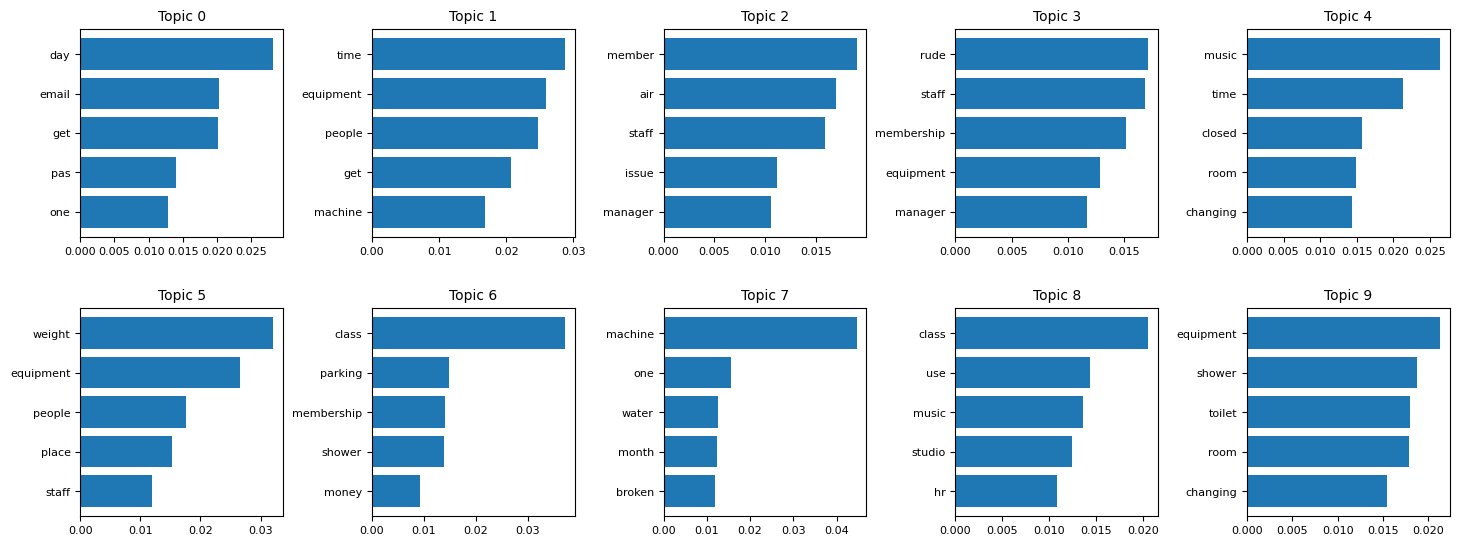

In [53]:
import matplotlib.pyplot as plt

def plot_lda_topics_grid(lda_model, num_topics=10, num_words=5, rows=2, cols=5):
    # Create figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    fig.tight_layout(pad=3.0)

    for topic_id in range(num_topics):
        # Calculate subplot position
        row = topic_id // cols
        col = topic_id % cols

        # Get top words for the topic
        top_words = lda_model.show_topic(topic_id, num_words)
        words = [word for word, _ in top_words]
        weights = [weight for _, weight in top_words]

        # Plot in the appropriate subplot
        ax = axes[row, col]
        ax.barh(words, weights)
        ax.set_title(f"Topic {topic_id}", fontsize=10)
        ax.invert_yaxis()

        # Adjust font sizes for compactness
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.xaxis.label.set_size(8)

    # Hide any empty subplots
    for i in range(num_topics, rows*cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.show()

plot_lda_topics_grid(lda_model)

In [54]:
pyLDAvis.display(pyldavis_display)


Topic Descriptions from lda_model:

Topic 0: weight, machine, cleaning, equipment, floor, station, puregym, one, staff, area
Topic 1: class, music, air, loud, instructor, hot, even, hear, workout, ac
Topic 2: parking, member, pure, puregym, car, park, staff, fine, time, issue
Topic 3: shower, equipment, time, machine, water, cold, good, get, use, month
Topic 4: class, manager, trainer, rude, people, get, staff, pt, time, personal
Topic 5: day, staff, get, membership, email, member, time, customer, pas, service
Topic 6: air, year, machine, conditioning, broken, working, puregym, issue, one, member
Topic 7: room, equipment, changing, machine, people, staff, like, toilet, place, smell
Topic 8: one, machine, price, weight, use, would, puregym, cable, equipment, pay
Topic 9: equipment, toilet, machine, disabled, time, water, people, broken, always, hand


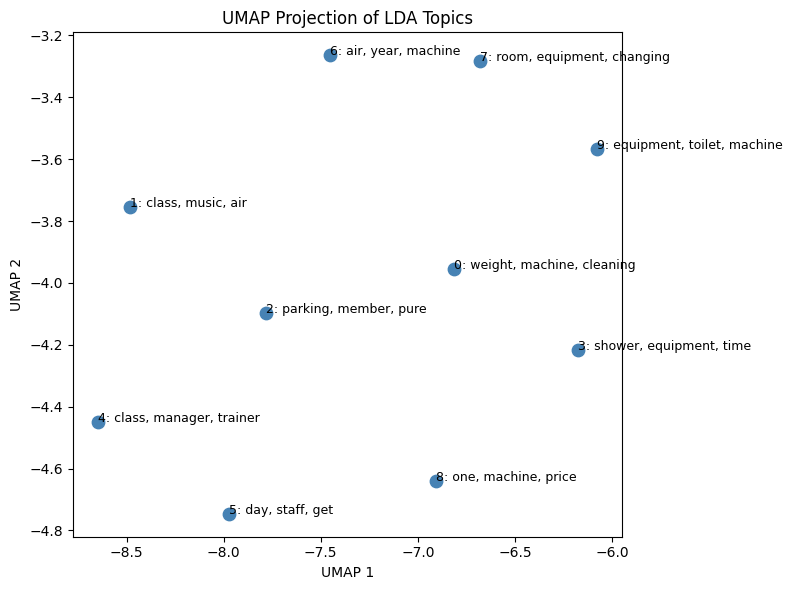

In [46]:
from collections import defaultdict
from umap import UMAP
import numpy as np

# Get topic-word distributions
topic_word_distributions = lda_model.get_topics()  # shape: (num_topics, vocab_size)

# Reduce dimensionality of topic-word distributions
umap_model = UMAP(
    n_neighbors=15,
    n_components=2,  # for 2D visualization
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
reduced_embeddings = umap_model.fit_transform(topic_word_distributions)

# Print topic keywords
print("\nTopic Descriptions from lda_model:\n")
for topic_id in range(lda_model.num_topics):
    terms = lda_model.show_topic(topic_id, topn=10)
    top_words = ", ".join([term for term, _ in terms])
    print(f"Topic {topic_id}: {top_words}")

# Optional: Visualize with matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='steelblue', s=80)

for topic_id, (x, y) in enumerate(reduced_embeddings):
    terms = lda_model.show_topic(topic_id, topn=3)
    label = ", ".join([term for term, _ in terms])
    plt.text(x, y, f"{topic_id}: {label}", fontsize=9)

plt.title("UMAP Projection of LDA Topics")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


Since the LDA model was limited to 10 topics, we will compare these 10 LDA topics with the top 10 BERTopic topics, using the combined negative reviews from both datasets.

### **Overall Similarity**

* Both **LDA (Gensim)** and **BERTopic** identified **similar core problem areas**:

  * Air conditioning and temperature
  * Pin/code access issues
  * Dirty toilets and changing rooms
  * Parking and fines
  * Loud music
  * Closure and opening times
  * Bad smells
  * Broken machines and equipment
  * Cold showers
  * Class cancellations and booking issues

* This **alignment suggests topic stability** across methods, validating these as **key pain points** in your negative reviews.


### **Differences and Extra Insights**

**BERTopic provided:**

* Slightly **cleaner topic labels** (e.g., “air\_conditioning\_hot\_aircon” instead of “air, hot, equipment…”).
* Detection of “cold\_shower\_showers\_temperature” as a separate clear topic.
* Better phrase-level grouping using embeddings, leading to:

  * **Rowing machines mentioned under broken equipment (Topic 7)**
  * “Ventilation” explicitly linked with smells (Topic 6)
  * The **closure topic included “Christmas” and “email,”** hinting at seasonal operational communication issues.

**LDA provided:**

* A **broader vocabulary** within each topic, occasionally mixing related complaints (e.g., “equipment, people, time” in the same topic).
* No clear separation of shower temperature issues as an isolated topic.
* Mixed class-related and booking issues across topics, while BERTopic kept them together.

## Comparison of BERTopic and LDA Models

Here's a summary comparing the topics identified by BERTopic and LDA models, and the insights gained from each:

### **Overall Similarity**

* Both **LDA (Gensim)** and **BERTopic** identified **similar core problem areas**:

  * Air conditioning and temperature
  * Pin/code access issues
  * Dirty toilets and changing rooms
  * Parking and fines
  * Loud music
  * Closure and opening times
  * Bad smells
  * Broken machines and equipment
  * Cold showers
  * Class cancellations and booking issues
* This **alignment suggests topic stability** across methods, validating these as **key pain points** in your negative reviews.

### **Differences and Extra Insights**

**BERTopic provided:**

* Slightly **cleaner topic labels** (e.g., “air\_conditioning\_hot\_aircon” instead of “air, hot, equipment…”).
* Detection of “cold\_shower\_showers\_temperature” as a separate clear topic.
* Better phrase-level grouping using embeddings, leading to:

  * **Rowing machines mentioned under broken equipment (Topic 7)**
  * “Ventilation” explicitly linked with smells (Topic 6)
  * The **closure topic included “Christmas” and “email,”** hinting at seasonal operational communication issues.

**LDA provided:**

* A **broader vocabulary** within each topic, occasionally mixing related complaints (e.g., “equipment, people, time” in the same topic).
* No clear separation of shower temperature issues as an isolated topic.
* Mixed class-related and booking issues across topics, while BERTopic kept them together.
* When extracting keywords for each topic, LDA included unrelated words in a topic. This may reflect limitations in fine-tuning. For instance, Topic 3 highlighted “member,” “air,” “staff,” “issue,” and “manager” as top keywords, even though they are unrelated. Similarly, the word “equipment” appeared frequently in many topics, reducing clarity in topic separation.